In [1]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

In [2]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl
!pip install RegscorePy

/tmp/ipykernel_684713/1105938615.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


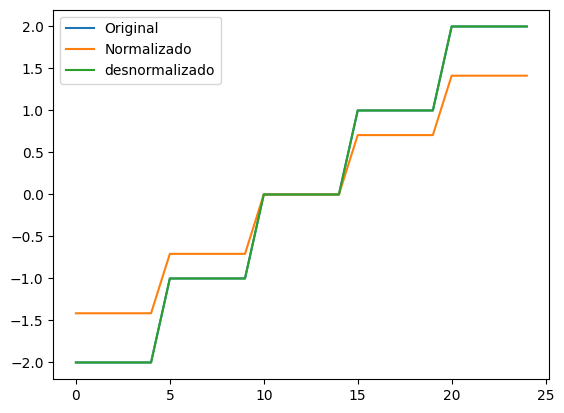

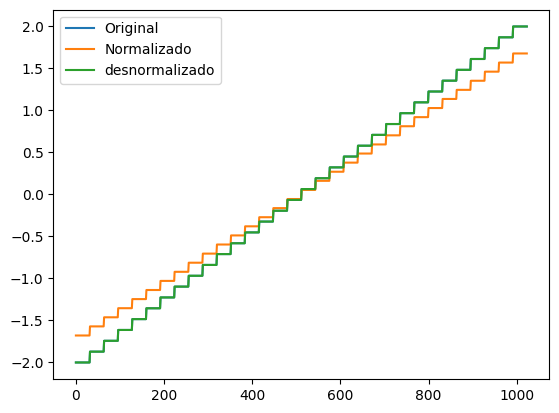

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def peaks(grid):
    x = np.linspace(-2, 2, grid)
    y = np.linspace(-2, 2, grid)
    x, y = np.meshgrid(x, y)
    z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x+1)**2 - y**2)
    return x, y, z

def create_dataframe(grid):
   x, y, z = peaks(grid)
   data = {'X': x.flatten(), 'Y': y.flatten(), 'Z': z.flatten()}
   df = pd.DataFrame(data)
   return df

def show_norm(df, label="Peaks", plot=False):
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["Y"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()


df_25 = create_dataframe(grid=5)
df_25_norm = show_norm(df_25)
test_out_scaler(df_25)

df_1000 = create_dataframe(grid=32)
df_1000_norm = show_norm(df_1000)
test_out_scaler(df_1000)



In [4]:
def split_df(df):
    _input = np.vstack([df['X'], df['Y']]).T
    _output = np.array(df['Z'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-05-04 02:35:37.471659: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-04 02:35:37.517051: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 02:35:37.517119: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 02:35:37.518228: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-04 02:35:37.524282: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-04 02:35:37.525168: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output, sup_input, sup_output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(sup_input, sup_output)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
      self._sup = (sup_input, sup_output)

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          vt_pred = self.lm_model.predict(self.vt_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))    
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_vt = r2_score(vt_denorm,  vt_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'r2_vt': r2_vt,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mse_vt': mse_vt,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product

class Tester:
  def __init__(self, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input_25, self.output_25 = split_df(df_25_norm)
    self.input_1000, self.output_1000 = split_df(df_1000_norm)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input_25, self.output_25, self.input_1000, self.output_1000)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando com 25 dados


In [8]:
tester = Tester(run_times=25, dataset_run_times=10)
tester.Loop(sort_by='mse_sup',
            boundarie = 0.25,
            hidden_sizes = [[40, 39], [20, 4], [15, 14], [26,18], [33, 21], [21, 12], [30, 21], [15, 2], [24, 7], [30, 16]],
            regularizers=[0.2, 0.0, 0.02, 0.5],
            learning_rate=[0.01, 0.1])

Testando combinacao1: Hidden Size=[40, 39], regularizer=0.2, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step


r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_3_10  0.895559  0.833315  0.913305  0.862175  0.905863  0.148239   
model_1_3_9   0.894320  0.832557  0.913024  0.862290  0.905802  0.149998   
model_1_3_8   0.893045  0.831765  0.912722  0.862372  0.905718  0.151807   
model_1_3_7   0.891734  0.830938  0.912399  0.862419  0.905610  0.153667   
model_1_3_6   0.890386  0.830077  0.912053  0.862431  0.905479  0.155581   
model_1_3_5   0.889000  0.829178  0.911683  0.862407  0.905322  0.157548   
model_1_3_4   0.887574  0.828242  0.911288  0.862344  0.905138  0.159572   
model_1_3_3   0.886108  0.827267  0.910867  0.862241  0.904927  0.161653   
model_1_3_2   0.884600  0.826251  0.910418  0.862097  0.904686  0.163793   
model_1_3_1   0.883049  0.825195  0.909938  0.861909  0.904415  0.165995   
model_1_3_0   0.881454  0.824095  0.909427  0.861676  0.904111  0.168259   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_3_10  0.236585  0.145246  0.253174  0.199210  0.472631  0.385018   
model_1_3_9   0.237661  0.145717  0.252962  0.199339  0.474048  0.387295   
model_1_3_8   0.238785  0.146223  0.252811  0.199517  0.475470  0.389624   
model_1_3_7   0.239958  0.146764  0.252724  0.199744  0.476896  0.392004   
model_1_3_6   0.241182  0.147344  0.252702  0.200023  0.479099  0.394437   
model_1_3_5   0.242457  0.147963  0.252747  0.200355  0.484253  0.396924   
model_1_3_4   0.243786  0.148624  0.252863  0.200743  0.489481  0.399465   
model_1_3_3   0.245170  0.149330  0.253051  0.201190  0.494777  0.402061   
model_1_3_2   0.246611  0.150083  0.253316  0.201699  0.500148  0.404714   
model_1_3_1   0.248111  0.150886  0.253661  0.202273  0.505591  0.407424   
model_1_3_0   0.249672  0.151743  0.254090  0.202917  0.511111  0.410194   

                r2_adj       rsd          aic          bic  
model_1_3_10  1.001445  0.401409  3521.817861  5665.820437  
model_1_3_9   1.001462  0.403783  3521.794271  5665.796847  
model_1_3_8   1.001479  0.406211  3521.770293  5665.772869  
model_1_3_7   1.001498  0.408693  3521.745930  5665.748506  
model_1_3_6   1.001516  0.411229  3521.721180  5665.723756  
model_1_3_5   1.001535  0.413822  3521.696045  5665.698620  
model_1_3_4   1.001555  0.416471  3521.670520  5665.673096  
model_1_3_3   1.001575  0.419177  3521.644607  5665.647183  
model_1_3_2   1.001596  0.421943  3521.618301  5665.620877  
model_1_3_1   1.001618  0.424769  3521.591600  5665.594176  
model_1_3_0   1.001640  0.427657  3521.564500  5665.567076

DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_4_9   0.906839  0.834331  0.840013  0.795146  0.866513  0.132228   
model_1_4_10  0.907803  0.834327  0.840128  0.791404  0.865913  0.130861   
model_1_4_8   0.905847  0.834317  0.839863  0.798892  0.867092  0.133636   
model_1_4_11  0.908738  0.834306  0.840207  0.787666  0.865292  0.129533   
model_1_4_7   0.904826  0.834285  0.839679  0.802640  0.867651  0.135086   
model_1_4_12  0.909646  0.834268  0.840251  0.783936  0.864652  0.128244   
model_1_4_6   0.903776  0.834234  0.839460  0.806388  0.868190  0.136577   
model_1_4_13  0.910527  0.834213  0.840260  0.780215  0.863991  0.126993   
model_1_4_5   0.902695  0.834164  0.839209  0.810133  0.868707  0.138110   
model_1_4_14  0.911382  0.834142  0.840232  0.776505  0.863310  0.125781   
model_1_4_4   0.901585  0.834074  0.838925  0.813875  0.869205  0.139686   
model_1_4_15  0.912210  0.834056  0.840168  0.772806  0.862609  0.124605   
model_1_4_3   0.900443  0.833964  0.838609  0.817610  0.869682  0.141307   
model_1_4_16  0.913013  0.833955  0.840068  0.769121  0.861890  0.123465   
model_1_4_17  0.913791  0.833839  0.839931  0.765452  0.861151  0.122361   
model_1_4_2   0.899270  0.833834  0.838262  0.821338  0.870139  0.142971   
model_1_4_18  0.914544  0.833708  0.839759  0.761799  0.860393  0.121292   
model_1_4_1   0.898066  0.833683  0.837885  0.825056  0.870576  0.144681   
model_1_4_19  0.915273  0.833564  0.839551  0.758164  0.859617  0.120258   
model_1_4_0   0.896829  0.833510  0.837479  0.828763  0.870993  0.146437   
model_1_4_20  0.915978  0.833406  0.839308  0.754550  0.858823  0.119257   
model_1_4_21  0.916660  0.833235  0.839030  0.750956  0.858011  0.118288   
model_1_4_22  0.917320  0.833052  0.838716  0.747384  0.857183  0.117352   
model_1_4_23  0.917958  0.832856  0.838369  0.743836  0.856337  0.116447   
model_1_4_24  0.918573  0.832648  0.837987  0.740313  0.855476  0.115573   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_4_9   0.235143  0.234796  0.088866  0.161831  0.555391  0.363632   
model_1_4_10  0.235149  0.234628  0.090490  0.162559  0.563281  0.361747   
model_1_4_8   0.235163  0.235016  0.087241  0.161129  0.547423  0.365563   
model_1_4_11  0.235179  0.234511  0.092111  0.163311  0.571088  0.359907   
model_1_4_7   0.235209  0.235287  0.085615  0.160451  0.539379  0.367540   
model_1_4_12  0.235233  0.234446  0.093729  0.164087  0.578808  0.358112   
model_1_4_6   0.235281  0.235607  0.083990  0.159798  0.531259  0.369563   
model_1_4_13  0.235310  0.234434  0.095343  0.164889  0.586440  0.356361   
model_1_4_5   0.235381  0.235976  0.082365  0.159170  0.523071  0.371631   
model_1_4_14  0.235411  0.234475  0.096953  0.165714  0.593979  0.354656   
model_1_4_4   0.235508  0.236393  0.080742  0.158567  0.514815  0.373746   
model_1_4_15  0.235533  0.234569  0.098557  0.166563  0.601427  0.352994   
model_1_4_3   0.235664  0.236857  0.079121  0.157989  0.506496  0.375908   
model_1_4_16  0.235677  0.234716  0.100156  0.167436  0.608778  0.351376   
model_1_4_17  0.235842  0.234916  0.101748  0.168332  0.616031  0.349802   
model_1_4_2   0.235848  0.237366  0.077504  0.157435  0.498112  0.378116   
model_1_4_18  0.236027  0.235168  0.103332  0.169250  0.623179  0.348271   
model_1_4_1   0.236063  0.237919  0.075891  0.156905  0.489672  0.380370   
model_1_4_19  0.236232  0.235473  0.104909  0.170191  0.630226  0.346782   
model_1_4_0   0.236308  0.238515  0.074283  0.156399  0.481179  0.382671   
model_1_4_20  0.236456  0.235831  0.106477  0.171154  0.637166  0.345336   
model_1_4_21  0.236698  0.236239  0.108036  0.172138  0.643998  0.343931   
model_1_4_22  0.236959  0.236699  0.109585  0.173142  0.650720  0.342567   
model_1_4_23  0.237237  0.237209  0.111125  0.174167  0.657327  0.341244   
model_1_4_24  0.237532  0.237769  0.112653  0.175211  0.663824  0.339961   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_5_19  0.939737  0.837000  0.793123  0.930705  0.867416  0.085535   
model_1_5_18  0.938961  0.836998  0.795034  0.929143  0.867767  0.086636   
model_1_5_20  0.940488  0.836985  0.791188  0.932155  0.867009  0.084468   
model_1_5_17  0.938159  0.836978  0.796921  0.927465  0.868058  0.087774   
model_1_5_21  0.941216  0.836952  0.789232  0.933497  0.866549  0.083436   
model_1_5_16  0.937332  0.836939  0.798782  0.925666  0.868290  0.088948   
model_1_5_22  0.941919  0.836903  0.787254  0.934734  0.866035  0.082437   
model_1_5_15  0.936478  0.836881  0.800616  0.923744  0.868458  0.090161   
model_1_5_23  0.942600  0.836839  0.785257  0.935871  0.865472  0.081470   
model_1_5_14  0.935596  0.836802  0.802423  0.921692  0.868561  0.091412   
model_1_5_24  0.943259  0.836759  0.783241  0.936910  0.864861  0.080535   
model_1_5_13  0.934686  0.836702  0.804200  0.919508  0.868597  0.092703   
model_1_5_12  0.933748  0.836581  0.805946  0.917187  0.868562  0.094036   
model_1_5_11  0.932780  0.836437  0.807661  0.914725  0.868455  0.095410   
model_1_5_10  0.931781  0.836270  0.809341  0.912116  0.868273  0.096827   
model_1_5_9   0.930752  0.836079  0.810987  0.909357  0.868014  0.098288   
model_1_5_8   0.929690  0.835863  0.812596  0.906444  0.867674  0.099794   
model_1_5_7   0.928597  0.835621  0.814166  0.903371  0.867251  0.101347   
model_1_5_6   0.927469  0.835352  0.815697  0.900134  0.866744  0.102947   
model_1_5_5   0.926308  0.835056  0.817186  0.896729  0.866148  0.104596   
model_1_5_4   0.925111  0.834732  0.818631  0.893152  0.865462  0.106294   
model_1_5_3   0.923879  0.834378  0.820031  0.889398  0.864682  0.108043   
model_1_5_2   0.922610  0.833993  0.821383  0.885462  0.863806  0.109844   
model_1_5_1   0.921303  0.833578  0.822684  0.881342  0.862831  0.111699   
model_1_5_0   0.919958  0.833129  0.823933  0.877034  0.861755  0.113608   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_5_19  0.231354  0.137044  0.035884  0.086464  0.491313  0.292463   
model_1_5_18  0.231357  0.135779  0.036693  0.086236  0.486209  0.294341   
model_1_5_20  0.231377  0.138326  0.035133  0.086730  0.496337  0.290634   
model_1_5_17  0.231386  0.134529  0.037562  0.086045  0.485661  0.296267   
model_1_5_21  0.231423  0.139622  0.034438  0.087030  0.501279  0.288853   
model_1_5_16  0.231441  0.133295  0.038493  0.085894  0.494561  0.298242   
model_1_5_22  0.231492  0.140932  0.033798  0.087365  0.506142  0.287118   
model_1_5_15  0.231524  0.132080  0.039489  0.085785  0.503569  0.300268   
model_1_5_23  0.231584  0.142255  0.033209  0.087732  0.510929  0.285430   
model_1_5_14  0.231636  0.130884  0.040551  0.085717  0.512693  0.302345   
model_1_5_24  0.231697  0.143591  0.032671  0.088131  0.515640  0.283788   
model_1_5_13  0.231778  0.129706  0.041682  0.085694  0.521929  0.304472   
model_1_5_12  0.231950  0.128550  0.042884  0.085717  0.531284  0.306652   
model_1_5_11  0.232154  0.127414  0.044160  0.085787  0.540754  0.308885   
model_1_5_10  0.232391  0.126301  0.045510  0.085906  0.550340  0.311170   
model_1_5_9   0.232663  0.125210  0.046939  0.086075  0.560045  0.313509   
model_1_5_8   0.232969  0.124145  0.048448  0.086296  0.569869  0.315902   
model_1_5_7   0.233313  0.123104  0.050039  0.086572  0.579814  0.318350   
model_1_5_6   0.233694  0.122090  0.051715  0.086903  0.589879  0.320853   
model_1_5_5   0.234114  0.121104  0.053478  0.087291  0.600067  0.323412   
model_1_5_4   0.234574  0.120146  0.055331  0.087739  0.610377  0.326027   
model_1_5_3   0.235077  0.119220  0.057275  0.088247  0.620812  0.328699   
model_1_5_2   0.235622  0.118324  0.059313  0.088818  0.631374  0.331428   
model_1_5_1   0.236213  0.117462  0.061446  0.089454  0.642061  0.334214   
model_1_5_0   0.236849  0.116635  0.063678  0.090156  0.652877  0.337058   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_6_24  0.950155  0.839880  0.720438  0.900001  0.900521  0.070748   
model_1_6_23  0.950021  0.839873  0.723886  0.900660  0.901433  0.070938   
model_1_6_22  0.949879  0.839858  0.727341  0.901315  0.902343  0.071140   
model_1_6_21  0.949728  0.839836  0.730799  0.901965  0.903251  0.071354   
model_1_6_20  0.949567  0.839805  0.734260  0.902610  0.904157  0.071582   
model_1_6_19  0.949397  0.839767  0.737719  0.903250  0.905059  0.071823   
model_1_6_18  0.949217  0.839720  0.741173  0.903885  0.905958  0.072079   
model_1_6_17  0.949026  0.839665  0.744620  0.904514  0.906853  0.072350   
model_1_6_16  0.948825  0.839600  0.748056  0.905136  0.907743  0.072636   
model_1_6_15  0.948612  0.839526  0.751477  0.905753  0.908627  0.072937   
model_1_6_14  0.948388  0.839442  0.754879  0.906363  0.909504  0.073256   
model_1_6_13  0.948152  0.839348  0.758258  0.906966  0.910373  0.073591   
model_1_6_12  0.947902  0.839244  0.761607  0.907561  0.911234  0.073945   
model_1_6_11  0.947640  0.839129  0.764925  0.908149  0.912085  0.074317   
model_1_6_10  0.947364  0.839002  0.768204  0.908728  0.912926  0.074709   
model_1_6_9   0.947074  0.838864  0.771440  0.909299  0.913755  0.075121   
model_1_6_8   0.946769  0.838715  0.774626  0.909861  0.914572  0.075553   
model_1_6_7   0.946449  0.838552  0.777757  0.910413  0.915374  0.076008   
model_1_6_6   0.946113  0.838377  0.780827  0.910955  0.916161  0.076485   
model_1_6_5   0.945760  0.838189  0.783827  0.911487  0.916931  0.076985   
model_1_6_4   0.945390  0.837988  0.786753  0.912007  0.917683  0.077511   
model_1_6_3   0.945003  0.837772  0.789597  0.912517  0.918416  0.078061   
model_1_6_2   0.944596  0.837541  0.792351  0.913014  0.919128  0.078638   
model_1_6_1   0.944171  0.837296  0.795008  0.913499  0.919818  0.079242   
model_1_6_0   0.943725  0.837035  0.797561  0.913970  0.920483  0.079874   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_6_24  0.227267  0.118415  0.146057  0.132236  0.579667  0.265986   
model_1_6_23  0.227278  0.116955  0.145094  0.131024  0.577574  0.266342   
model_1_6_22  0.227298  0.115491  0.144138  0.129815  0.575445  0.266720   
model_1_6_21  0.227330  0.114026  0.143189  0.128608  0.573282  0.267122   
model_1_6_20  0.227373  0.112561  0.142247  0.127404  0.571104  0.267548   
model_1_6_19  0.227427  0.111096  0.141312  0.126204  0.569022  0.267999   
model_1_6_18  0.227494  0.109632  0.140385  0.125009  0.566892  0.268476   
model_1_6_17  0.227573  0.108172  0.139466  0.123819  0.564725  0.268979   
model_1_6_16  0.227665  0.106717  0.138556  0.122637  0.562509  0.269510   
model_1_6_15  0.227770  0.105268  0.137655  0.121462  0.560245  0.270069   
model_1_6_14  0.227889  0.103827  0.136765  0.120296  0.557931  0.270658   
model_1_6_13  0.228022  0.102396  0.135884  0.119140  0.555565  0.271277   
model_1_6_12  0.228170  0.100977  0.135015  0.117996  0.553143  0.271928   
model_1_6_11  0.228334  0.099572  0.134156  0.116864  0.550665  0.272612   
model_1_6_10  0.228513  0.098183  0.133310  0.115747  0.548129  0.273329   
model_1_6_9   0.228708  0.096812  0.132477  0.114644  0.545528  0.274081   
model_1_6_8   0.228921  0.095462  0.131656  0.113559  0.542865  0.274870   
model_1_6_7   0.229151  0.094136  0.130850  0.112493  0.540137  0.275695   
model_1_6_6   0.229400  0.092836  0.130058  0.111447  0.537337  0.276559   
model_1_6_5   0.229667  0.091565  0.129281  0.110423  0.534470  0.277463   
model_1_6_4   0.229953  0.090326  0.128521  0.109423  0.531524  0.278407   
model_1_6_3   0.230260  0.089121  0.127777  0.108449  0.528506  0.279394   
model_1_6_2   0.230586  0.087955  0.127051  0.107503  0.525409  0.280424   
model_1_6_1   0.230935  0.086829  0.126342  0.106586  0.522235  0.281499   
model_1_6_0   0.231305  0.085748  0.125654  0.105701  0.518979  0.282620   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_7_0   0.950265  0.839604  0.945907  0.680966  0.947433  0.070592   
model_1_7_1   0.950329  0.839287  0.944303  0.659451  0.945056  0.070500   
model_1_7_2   0.950349  0.838931  0.942584  0.637250  0.942567  0.070472   
model_1_7_3   0.950326  0.838536  0.940754  0.614387  0.939969  0.070505   
model_1_7_4   0.950262  0.838105  0.938819  0.590885  0.937268  0.070596   
model_1_7_5   0.950157  0.837637  0.936782  0.566767  0.934468  0.070745   
model_1_7_6   0.950014  0.837135  0.934650  0.542054  0.931572  0.070948   
model_1_7_7   0.949833  0.836600  0.932427  0.516771  0.928585  0.071204   
model_1_7_8   0.949617  0.836032  0.930116  0.490938  0.925512  0.071512   
model_1_7_9   0.949366  0.835433  0.927724  0.464579  0.922355  0.071868   
model_1_7_10  0.949081  0.834804  0.925254  0.437712  0.919120  0.072272   
model_1_7_11  0.948765  0.834146  0.922710  0.410364  0.915810  0.072721   
model_1_7_12  0.948418  0.833460  0.920097  0.382553  0.912430  0.073213   
model_1_7_13  0.948042  0.832747  0.917419  0.354301  0.908982  0.073747   
model_1_7_14  0.947637  0.832008  0.914680  0.325630  0.905471  0.074321   
model_1_7_15  0.947206  0.831244  0.911884  0.296561  0.901900  0.074934   
model_1_7_16  0.946749  0.830456  0.909034  0.267113  0.898273  0.075582   
model_1_7_17  0.946267  0.829645  0.906135  0.237308  0.894593  0.076266   
model_1_7_18  0.945762  0.828812  0.903190  0.207166  0.890864  0.076983   
model_1_7_19  0.945234  0.827958  0.900203  0.176706  0.887090  0.077732   
model_1_7_20  0.944685  0.827084  0.897177  0.145948  0.883273  0.078511   
model_1_7_21  0.944116  0.826190  0.894115  0.114913  0.879417  0.079319   
model_1_7_22  0.943528  0.825279  0.891021  0.083617  0.875524  0.080154   
model_1_7_23  0.942922  0.824350  0.887897  0.052081  0.871599  0.081015   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_7_0   0.227659  0.074113  0.051903  0.063008  0.592318  0.265691   
model_1_7_1   0.228109  0.076311  0.055403  0.065857  0.604828  0.265519   
model_1_7_2   0.228615  0.078667  0.059015  0.068841  0.617193  0.265466   
model_1_7_3   0.229175  0.081174  0.062735  0.071954  0.629420  0.265527   
model_1_7_4   0.229787  0.083826  0.066558  0.075192  0.641505  0.265700   
model_1_7_5   0.230450  0.086615  0.070482  0.078549  0.653444  0.265979   
model_1_7_6   0.231163  0.089537  0.074503  0.082020  0.665246  0.266361   
model_1_7_7   0.231922  0.092583  0.078616  0.085600  0.676904  0.266842   
model_1_7_8   0.232728  0.095749  0.082819  0.089283  0.689671  0.267417   
model_1_7_9   0.233578  0.099026  0.087107  0.093067  0.703873  0.268082   
model_1_7_10  0.234471  0.102411  0.091478  0.096945  0.717908  0.268834   
model_1_7_11  0.235406  0.105896  0.095927  0.100912  0.731778  0.269668   
model_1_7_12  0.236380  0.109476  0.100452  0.104964  0.745481  0.270579   
model_1_7_13  0.237392  0.113146  0.105048  0.109097  0.759015  0.271564   
model_1_7_14  0.238441  0.116899  0.109712  0.113305  0.772383  0.272619   
model_1_7_15  0.239525  0.120730  0.114442  0.117586  0.785586  0.273740   
model_1_7_16  0.240644  0.124634  0.119232  0.121933  0.798621  0.274923   
model_1_7_17  0.241795  0.128606  0.124081  0.126344  0.811491  0.276164   
model_1_7_18  0.242977  0.132641  0.128985  0.130813  0.824193  0.277459   
model_1_7_19  0.244189  0.136734  0.133941  0.135337  0.836732  0.278805   
model_1_7_20  0.245430  0.140880  0.138944  0.139912  0.849101  0.280199   
model_1_7_21  0.246698  0.145075  0.143994  0.144534  0.861306  0.281636   
model_1_7_22  0.247991  0.149314  0.149085  0.149200  0.873345  0.283114   
model_1_7_23  0.249310  0.153593  0.154216  0.153905  0.885216  0.284631   

                r2_adj       rsd          aic          bic  
model_1_7_0   1.000688  0.277002  3523.301684  5667.304260  
model_1_7_1   1.000687  0.276823  3523.304277  5667.306853  
model_1_7_2   1.000687  0.276767  3

DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_8_24  0.953938  0.832534  0.964145  0.732154  0.906837  0.065378   
model_1_8_23  0.953683  0.832388  0.965087  0.733310  0.907775  0.065740   
model_1_8_22  0.953415  0.832229  0.966018  0.734429  0.908696  0.066120   
model_1_8_21  0.953133  0.832056  0.966938  0.735507  0.909599  0.066522   
model_1_8_20  0.952835  0.831867  0.967845  0.736544  0.910482  0.066944   
model_1_8_19  0.952523  0.831663  0.968739  0.737539  0.911346  0.067387   
model_1_8_18  0.952195  0.831443  0.969618  0.738491  0.912189  0.067853   
model_1_8_17  0.951850  0.831206  0.970483  0.739396  0.913010  0.068341   
model_1_8_16  0.951490  0.830952  0.971332  0.740254  0.913808  0.068854   
model_1_8_15  0.951112  0.830681  0.972164  0.741064  0.914582  0.069390   
model_1_8_14  0.950716  0.830391  0.972977  0.741822  0.915330  0.069951   
model_1_8_13  0.950303  0.830082  0.973773  0.742529  0.916053  0.070537   
model_1_8_12  0.949871  0.829754  0.974548  0.743179  0.916747  0.071151   
model_1_8_11  0.949420  0.829406  0.975302  0.743774  0.917413  0.071791   
model_1_8_10  0.948949  0.829037  0.976034  0.744309  0.918049  0.072459   
model_1_8_9   0.948459  0.828647  0.976744  0.744783  0.918654  0.073156   
model_1_8_8   0.947947  0.828235  0.977429  0.745194  0.919226  0.073882   
model_1_8_7   0.947414  0.827799  0.978089  0.745537  0.919763  0.074639   
model_1_8_6   0.946858  0.827341  0.978723  0.745813  0.920265  0.075427   
model_1_8_5   0.946281  0.826858  0.979329  0.746016  0.920730  0.076247   
model_1_8_4   0.945679  0.826350  0.979907  0.746144  0.921156  0.077100   
model_1_8_3   0.945054  0.825816  0.980455  0.746194  0.921541  0.077988   
model_1_8_2   0.944404  0.825255  0.980972  0.746162  0.921885  0.078910   
model_1_8_1   0.943729  0.824667  0.981456  0.746044  0.922185  0.079869   
model_1_8_0   0.943027  0.824050  0.981908  0.745837  0.922439  0.080865   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_8_24  0.237694  0.052103  0.146820  0.099462  0.707408  0.255692   
model_1_8_23  0.237900  0.050734  0.146186  0.098460  0.713902  0.256397   
model_1_8_22  0.238126  0.049381  0.145573  0.097477  0.720438  0.257139   
model_1_8_21  0.238373  0.048045  0.144982  0.096514  0.727018  0.257918   
model_1_8_20  0.238640  0.046727  0.144414  0.095570  0.733643  0.258735   
model_1_8_19  0.238930  0.045428  0.143868  0.094648  0.740717  0.259590   
model_1_8_18  0.239243  0.044149  0.143347  0.093748  0.747906  0.260486   
model_1_8_17  0.239579  0.042893  0.142850  0.092872  0.755149  0.261422   
model_1_8_16  0.239939  0.041660  0.142380  0.092020  0.762440  0.262400   
model_1_8_15  0.240324  0.040451  0.141936  0.091194  0.769784  0.263419   
model_1_8_14  0.240736  0.039268  0.141521  0.090394  0.777182  0.264482   
model_1_8_13  0.241174  0.038113  0.141133  0.089623  0.784632  0.265589   
model_1_8_12  0.241639  0.036986  0.140777  0.088881  0.792142  0.266741   
model_1_8_11  0.242133  0.035890  0.140451  0.088171  0.799709  0.267938   
model_1_8_10  0.242657  0.034826  0.140157  0.087492  0.807330  0.269182   
model_1_8_9   0.243211  0.033795  0.139898  0.086846  0.815015  0.270473   
model_1_8_8   0.243796  0.032799  0.139672  0.086236  0.822762  0.271812   
model_1_8_7   0.244414  0.031840  0.139484  0.085662  0.830572  0.273201   
model_1_8_6   0.245065  0.030919  0.139333  0.085126  0.838447  0.274639   
model_1_8_5   0.245750  0.030038  0.139222  0.084630  0.846387  0.276128   
model_1_8_4   0.246471  0.029198  0.139151  0.084175  0.854395  0.277669   
model_1_8_3   0.247229  0.028402  0.139124  0.083763  0.862478  0.279263   
model_1_8_2   0.248025  0.027651  0.139142  0.083396  0.870636  0.280910   
model_1_8_1   0.248860  0.026947  0.139206  0.083076  0.879274  0.282611   
model_1_8_0   0.249735  0.026291  0.139320  0.082806  0.888058  0.284368   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_9_24  0.962966  0.834663  0.645757  0.954429  0.942171  0.052564   
model_1_9_23  0.962725  0.834650  0.646136  0.955079  0.942685  0.052907   
model_1_9_22  0.962474  0.834633  0.646511  0.955729  0.943199  0.053262   
model_1_9_21  0.962216  0.834610  0.646881  0.956378  0.943713  0.053629   
model_1_9_20  0.961949  0.834583  0.647244  0.957027  0.944225  0.054008   
model_1_9_19  0.961673  0.834550  0.647603  0.957675  0.944737  0.054400   
model_1_9_18  0.961388  0.834511  0.647955  0.958323  0.945248  0.054804   
model_1_9_17  0.961094  0.834467  0.648301  0.958969  0.945757  0.055222   
model_1_9_16  0.960790  0.834417  0.648641  0.959615  0.946266  0.055653   
model_1_9_15  0.960476  0.834361  0.648976  0.960259  0.946773  0.056098   
model_1_9_14  0.960153  0.834300  0.649304  0.960902  0.947279  0.056557   
model_1_9_13  0.959819  0.834232  0.649624  0.961544  0.947783  0.057030   
model_1_9_12  0.959476  0.834157  0.649939  0.962184  0.948286  0.057519   
model_1_9_11  0.959121  0.834076  0.650248  0.962822  0.948787  0.058022   
model_1_9_10  0.958756  0.833989  0.650549  0.963458  0.949285  0.058541   
model_1_9_9   0.958379  0.833894  0.650843  0.964092  0.949782  0.059075   
model_1_9_8   0.957991  0.833793  0.651131  0.964724  0.950276  0.059626   
model_1_9_7   0.957591  0.833684  0.651409  0.965353  0.950768  0.060193   
model_1_9_6   0.957179  0.833568  0.651680  0.965979  0.951258  0.060778   
model_1_9_5   0.956755  0.833444  0.651944  0.966602  0.951744  0.061379   
model_1_9_4   0.956319  0.833313  0.652199  0.967222  0.952228  0.061999   
model_1_9_3   0.955870  0.833174  0.652444  0.967839  0.952708  0.062637   
model_1_9_2   0.955407  0.833026  0.652680  0.968451  0.953185  0.063293   
model_1_9_1   0.954931  0.832871  0.652906  0.969060  0.953659  0.063968   
model_1_9_0   0.954442  0.832706  0.653122  0.969665  0.954128  0.064663   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_9_24  0.234672  0.063077  0.091951  0.077514  0.595134  0.229268   
model_1_9_23  0.234690  0.063009  0.090640  0.076825  0.599018  0.230015   
model_1_9_22  0.234715  0.062942  0.089329  0.076136  0.602950  0.230786   
model_1_9_21  0.234747  0.062876  0.088019  0.075448  0.606927  0.231579   
model_1_9_20  0.234786  0.062812  0.086710  0.074761  0.610951  0.232396   
model_1_9_19  0.234833  0.062748  0.085402  0.074075  0.615020  0.233238   
model_1_9_18  0.234887  0.062685  0.084095  0.073390  0.619135  0.234103   
model_1_9_17  0.234950  0.062624  0.082790  0.072707  0.623302  0.234994   
model_1_9_16  0.235021  0.062563  0.081488  0.072025  0.627520  0.235909   
model_1_9_15  0.235100  0.062503  0.080188  0.071346  0.631781  0.236850   
model_1_9_14  0.235188  0.062445  0.078890  0.070667  0.636098  0.237817   
model_1_9_13  0.235284  0.062388  0.077595  0.069992  0.640462  0.238810   
model_1_9_12  0.235390  0.062332  0.076304  0.069318  0.644879  0.239830   
model_1_9_11  0.235504  0.062277  0.075016  0.068647  0.649351  0.240877   
model_1_9_10  0.235629  0.062223  0.073733  0.067978  0.653872  0.241952   
model_1_9_9   0.235763  0.062171  0.072454  0.067312  0.658450  0.243054   
model_1_9_8   0.235907  0.062120  0.071179  0.066650  0.663083  0.244184   
model_1_9_7   0.236061  0.062070  0.069910  0.065990  0.667772  0.245343   
model_1_9_6   0.236226  0.062022  0.068647  0.065334  0.672518  0.246531   
model_1_9_5   0.236401  0.061975  0.067389  0.064682  0.677321  0.247749   
model_1_9_4   0.236588  0.061930  0.066138  0.064034  0.682184  0.248996   
model_1_9_3   0.236786  0.061886  0.064894  0.063390  0.687107  0.250273   
model_1_9_2   0.236995  0.061844  0.063658  0.062751  0.692090  0.251581   
model_1_9_1   0.237216  0.061804  0.062429  0.062116  0.697132  0.252920   
model_1_9_0   0.237449  0.061765  0.061208  0.061487  0.702240  0.254290   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_1_9
Testando combinacao2: Hidden Size=[40, 39], regularizer=0.2, learning_rate=0.1
+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [====

2024-05-04 02:44:04.004996: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled
2024-05-04 02:44:48.379917: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  936
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Stopped at epoch:  41
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_7_4  0.960920  0.827359  0.984179  0.843701  0.919633  0.055469   
model_3_7_3  0.960766  0.826575  0.985149  0.847281  0.921730  0.055687   
model_3_7_2  0.960598  0.825771  0.986086  0.850849  0.923807  0.055925   
model_3_7_1  0.960417  0.824949  0.986989  0.854404  0.925864  0.056182   
model_3_7_0  0.960221  0.824106  0.987857  0.857943  0.927898  0.056461   

              mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_7_4  0.245039  0.010151  0.112239  0.061195  0.375549  0.235519   
model_3_7_3  0.246152  0.009529  0.109669  0.059599  0.376262  0.235981   
model_3_7_2  0.247292  0.008928  0.107106  0.058017  0.377007  0.236484   
model_3_7_1  0.248460  0.008348  0.104553  0.056451  0.378021  0.237028   
model_3_7_0  0.249656  0.007792  0.102012  0.054902  0.379033  0.237616   

               r2_adj       rsd          aic          bic  
model_3_7_4  1.000541  0.245545  3523.783861  5667.786437  
model_3_7_3  1.000543  0.246027  3523.776012  5667.778588  
model_3_7_2  1.000545  0.246552  3523.767498  5667.770074  
model_3_7_1  1.000548  0.247119  3523.758301  5667.760877  
model_3_7_0  1.000550  0.247731  3523.748403  5667.750979

DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_8_24  0.965780  0.833603  0.918469  0.816289  0.853917  0.048571   
model_3_8_23  0.965783  0.833546  0.922462  0.819121  0.857174  0.048565   
model_3_8_22  0.965775  0.833476  0.926393  0.821923  0.860388  0.048577   
model_3_8_21  0.965754  0.833394  0.930257  0.824693  0.863558  0.048607   
model_3_8_20  0.965720  0.833299  0.934050  0.827431  0.866682  0.048655   
model_3_8_19  0.965673  0.833191  0.937767  0.830133  0.869754  0.048722   
model_3_8_18  0.965612  0.833070  0.941403  0.832797  0.872773  0.048809   
model_3_8_17  0.965536  0.832934  0.944954  0.835422  0.875737  0.048917   
model_3_8_16  0.965445  0.832783  0.948413  0.838006  0.878640  0.049046   
model_3_8_15  0.965338  0.832618  0.951775  0.840546  0.881480  0.049197   
model_3_8_14  0.965216  0.832436  0.955034  0.843039  0.884252  0.049371   
model_3_8_13  0.965076  0.832238  0.958183  0.845482  0.886953  0.049570   
model_3_8_12  0.964919  0.832023  0.961215  0.847874  0.889578  0.049793   
model_3_8_11  0.964744  0.831791  0.964123  0.850211  0.892123  0.050041   
model_3_8_10  0.964549  0.831540  0.966899  0.852490  0.894584  0.050317   
model_3_8_9   0.964335  0.831270  0.969535  0.854710  0.896954  0.050621   
model_3_8_8   0.964101  0.830981  0.972022  0.856865  0.899230  0.050953   
model_3_8_7   0.963845  0.830672  0.974350  0.858953  0.901405  0.051316   
model_3_8_6   0.963567  0.830341  0.976509  0.860971  0.903473  0.051711   
model_3_8_5   0.963266  0.829988  0.978490  0.862914  0.905429  0.052138   
model_3_8_4   0.962942  0.829612  0.980279  0.864779  0.907265  0.052599   
model_3_8_3   0.962592  0.829213  0.981866  0.866562  0.908975  0.053096   
model_3_8_2   0.962215  0.828789  0.983236  0.868259  0.910551  0.053630   
model_3_8_1   0.961812  0.828339  0.984378  0.869866  0.911985  0.054202   
model_3_8_0   0.961381  0.827863  0.985275  0.871377  0.913270  0.054815   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_8_24  0.236176  0.029822  0.115742  0.072782  0.470867  0.220387   
model_3_8_23  0.236258  0.028361  0.113958  0.071159  0.467044  0.220376   
model_3_8_22  0.236357  0.026923  0.112192  0.069558  0.463149  0.220402   
model_3_8_21  0.236473  0.025510  0.110447  0.067978  0.459174  0.220470   
model_3_8_20  0.236607  0.024122  0.108722  0.066422  0.455120  0.220579   
model_3_8_19  0.236761  0.022763  0.107020  0.064891  0.450987  0.220731   
model_3_8_18  0.236933  0.021433  0.105341  0.063387  0.446892  0.220928   
model_3_8_17  0.237126  0.020134  0.103687  0.061911  0.442979  0.221172   
model_3_8_16  0.237340  0.018869  0.102059  0.060464  0.438977  0.221463   
model_3_8_15  0.237575  0.017639  0.100460  0.059049  0.434881  0.221804   
model_3_8_14  0.237833  0.016447  0.098889  0.057668  0.430692  0.222197   
model_3_8_13  0.238114  0.015295  0.097350  0.056322  0.426404  0.222642   
model_3_8_12  0.238419  0.014186  0.095843  0.055015  0.422013  0.223142   
model_3_8_11  0.238749  0.013123  0.094370  0.053746  0.417517  0.223699   
model_3_8_10  0.239104  0.012107  0.092934  0.052521  0.412914  0.224315   
model_3_8_9   0.239487  0.011143  0.091536  0.051339  0.408198  0.224991   
model_3_8_8   0.239898  0.010233  0.090178  0.050206  0.403369  0.225729   
model_3_8_7   0.240337  0.009382  0.088863  0.049122  0.398418  0.226531   
model_3_8_6   0.240807  0.008592  0.087591  0.048092  0.393347  0.227400   
model_3_8_5   0.241307  0.007868  0.086367  0.047117  0.389859  0.228337   
model_3_8_4   0.241841  0.007213  0.085192  0.046203  0.387633  0.229345   
model_3_8_3   0.242407  0.006633  0.084069  0.045351  0.385342  0.230425   
model_3_8_2   0.243009  0.006132  0.082999  0.044565  0.382991  0.231581   
model_3_8_1   0.243647  0.005714  0.081987  0.043851  0.380577  0.232813   
model_3_8_0   0.244323  0.005386  0.081035  0.043211  0.378099  0.234125   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_9_0   0.965914  0.833609  0.951562  0.297119  0.745716  0.048380   
model_3_9_1   0.966040  0.833606  0.949375  0.288265  0.741445  0.048201   
model_3_9_2   0.966157  0.833596  0.947126  0.279491  0.737156  0.048035   
model_3_9_3   0.966266  0.833579  0.944818  0.270800  0.732853  0.047880   
model_3_9_4   0.966367  0.833556  0.942454  0.262186  0.728537  0.047737   
model_3_9_5   0.966460  0.833525  0.940037  0.253654  0.724211  0.047604   
model_3_9_6   0.966546  0.833488  0.937569  0.245203  0.719876  0.047483   
model_3_9_7   0.966625  0.833445  0.935053  0.236831  0.715533  0.047371   
model_3_9_8   0.966696  0.833395  0.932492  0.228535  0.711184  0.047270   
model_3_9_9   0.966761  0.833340  0.929887  0.220320  0.706830  0.047178   
model_3_9_10  0.966819  0.833279  0.927242  0.212184  0.702473  0.047096   
model_3_9_11  0.966871  0.833213  0.924558  0.204126  0.698117  0.047022   
model_3_9_12  0.966916  0.833142  0.921838  0.196144  0.693758  0.046958   
model_3_9_13  0.966956  0.833065  0.919085  0.188239  0.689402  0.046902   
model_3_9_14  0.966989  0.832983  0.916300  0.180410  0.685047  0.046854   
model_3_9_15  0.967018  0.832897  0.913484  0.172656  0.680697  0.046814   
model_3_9_16  0.967040  0.832806  0.910641  0.164975  0.676350  0.046782   
model_3_9_17  0.967058  0.832711  0.907772  0.157369  0.672009  0.046757   
model_3_9_18  0.967070  0.832612  0.904879  0.149835  0.667674  0.046739   
model_3_9_19  0.967078  0.832508  0.901964  0.142372  0.663347  0.046728   
model_3_9_20  0.967080  0.832400  0.899028  0.134981  0.659029  0.046725   
model_3_9_21  0.967079  0.832289  0.896073  0.127661  0.654720  0.046727   
model_3_9_22  0.967072  0.832174  0.893101  0.120409  0.650421  0.046736   
model_3_9_23  0.967062  0.832055  0.890114  0.113227  0.646134  0.046751   
model_3_9_24  0.967047  0.831933  0.887112  0.106111  0.641858  0.046772   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_9_0   0.236168  0.017244  0.116338  0.066791  0.467163  0.219954   
model_3_9_1   0.236172  0.018023  0.117803  0.067913  0.469306  0.219548   
model_3_9_2   0.236186  0.018823  0.119255  0.069039  0.471430  0.219169   
model_3_9_3   0.236210  0.019645  0.120694  0.070169  0.473493  0.218815   
model_3_9_4   0.236244  0.020487  0.122120  0.071303  0.475500  0.218488   
model_3_9_5   0.236287  0.021347  0.123532  0.072440  0.477451  0.218185   
model_3_9_6   0.236340  0.022226  0.124931  0.073578  0.479341  0.217905   
model_3_9_7   0.236401  0.023121  0.126316  0.074719  0.481182  0.217650   
model_3_9_8   0.236471  0.024033  0.127689  0.075861  0.482973  0.217417   
model_3_9_9   0.236549  0.024961  0.129049  0.077005  0.484714  0.217205   
model_3_9_10  0.236636  0.025902  0.130396  0.078149  0.486404  0.217016   
model_3_9_11  0.236730  0.026858  0.131729  0.079293  0.488048  0.216846   
model_3_9_12  0.236831  0.027826  0.133051  0.080438  0.489645  0.216697   
model_3_9_13  0.236940  0.028806  0.134359  0.081583  0.491197  0.216568   
model_3_9_14  0.237056  0.029798  0.135655  0.082726  0.492711  0.216457   
model_3_9_15  0.237178  0.030800  0.136938  0.083869  0.494178  0.216365   
model_3_9_16  0.237307  0.031812  0.138210  0.085011  0.495609  0.216290   
model_3_9_17  0.237442  0.032834  0.139468  0.086151  0.496997  0.216233   
model_3_9_18  0.237584  0.033864  0.140715  0.087290  0.498352  0.216192   
model_3_9_19  0.237731  0.034901  0.141951  0.088426  0.499669  0.216168   
model_3_9_20  0.237883  0.035946  0.143174  0.089560  0.500949  0.216159   
model_3_9_21  0.238041  0.036998  0.144386  0.090692  0.502195  0.216165   
model_3_9_22  0.238205  0.038056  0.145586  0.091821  0.503409  0.216185   
model_3_9_23  0.238373  0.039120  0.146775  0.092947  0.504590  0.216220   
model_3_9_24  0.238546  0.040189  0.147952  0.094071  0.505742  0.216268   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_3_9
Testando combinacao4: Hidden Size=[40, 39], regularizer=0.0, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [====

2024-05-04 02:49:33.470365: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_0] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_0] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_0] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_0] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/ste

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_1_4   0.954572  0.825557  0.395345  0.940279  0.788434  0.064479   
model_4_1_5   0.953515  0.825553  0.377592  0.936353  0.780701  0.065979   
model_4_1_6   0.952489  0.825473  0.361350  0.932721  0.773597  0.067435   
model_4_1_3   0.955641  0.825454  0.414685  0.944494  0.796815  0.062961   
model_4_1_7   0.951507  0.825339  0.346527  0.929378  0.767094  0.068829   
model_4_1_2   0.956696  0.825209  0.435675  0.948983  0.805852  0.061464   
model_4_1_8   0.950576  0.825169  0.333027  0.926314  0.761159  0.070150   
model_4_1_9   0.949701  0.824977  0.320755  0.923516  0.755753  0.071392   
model_4_1_10  0.948884  0.824772  0.309612  0.920967  0.750840  0.072551   
model_4_1_1   0.957699  0.824772  0.458347  0.953715  0.815531  0.060041   
model_4_1_11  0.948126  0.824562  0.299511  0.918650  0.746381  0.073627   
model_4_1_0   0.958600  0.824085  0.482696  0.958641  0.825816  0.058761   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_1_4   0.247597  0.304347  0.075013  0.189680  0.294951  0.253927   
model_4_1_5   0.247602  0.313283  0.079944  0.196613  0.287855  0.256864   
model_4_1_6   0.247716  0.321458  0.084507  0.202982  0.281452  0.259683   
model_4_1_3   0.247742  0.294612  0.069719  0.182165  0.302812  0.250921   
model_4_1_7   0.247906  0.328919  0.088705  0.208812  0.275669  0.262353   
model_4_1_2   0.248091  0.284047  0.064081  0.174064  0.311540  0.247920   
model_4_1_8   0.248147  0.335714  0.092553  0.214134  0.270444  0.264859   
model_4_1_9   0.248420  0.341891  0.096068  0.218980  0.265723  0.267193   
model_4_1_10  0.248711  0.347500  0.099270  0.223385  0.261457  0.269353   
model_4_1_1   0.248711  0.272636  0.058137  0.165386  0.321238  0.245032   
model_4_1_11  0.249009  0.352584  0.102181  0.227382  0.257605  0.271344   
model_4_1_0   0.249686  0.260380  0.051950  0.156165  0.332040  0.242407   

                r2_adj       rsd          aic          bic  
model_4_1_4   1.000628  0.264737  3523.482838  5667.485414  
model_4_1_5   1.000643  0.267799  3523.436840  5667.439416  
model_4_1_6   1.000657  0.270738  3523.393180  5667.395756  
model_4_1_3   1.000614  0.261603  3523.530470  5667.533046  
model_4_1_7   1.000671  0.273522  3523.352251  5667.354827  
model_4_1_2   1.000599  0.258475  3523.578595  5667.581171  
model_4_1_8   1.000684  0.276135  3523.314226  5667.316802  
model_4_1_9   1.000696  0.278568  3523.279141  5667.281717  
model_4_1_10  1.000707  0.280820  3523.246927  5667.249503  
model_4_1_1   1.000585  0.255464  3523.625465  5667.628041  
model_4_1_11  1.000718  0.282895  3523.217474  5667.220050  
model_4_1_0   1.000573  0.252727  3523.668551  5667.671127

DataFrame salvo em ../results/metrics_4_1
+++++++++++ [4_2] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_2_0  0.964098  0.830488  0.937102  0.987479  0.965151  0.050958   
model_4_2_1  0.967967  0.830296  0.900476  0.984769  0.947056  0.045467   
model_4_2_2  0.970021  0.828704  0.856203  0.979055  0.924014  0.042551   
model_4_2_3  0.970771  0.826118  0.808360  0.970965  0.898194  0.041487   

              mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_2_0  0.240597  0.031806  0.006626  0.019216  0.486282  0.225738   
model_4_2_1  0.240870  0.050327  0.008061  0.029194  0.613645  0.213229   
model_4_2_2  0.243129  0.072714  0.011085  0.041899  0.729198  0.206278   
model_4_2_3  0.246800  0.096907  0.015366  0.056137  0.832259  0.203684   

               r2_adj       rsd          aic          bic  
model_4_2_0  1.000497  0.235348  3523.953524  5667.956100  
model_4_2_1  1.000443  0.222307  3524.181549  5668.184125  
model_4_2_2  1.000415  0.215059  3524.314126  5668.316702  
model_4_2_3  1.000404  0.212355  3524.364751  5668.367327

DataFrame salvo em ../results/metrics_4_2
+++++++++++ [4_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_3_15  0.992225  0.832114  0.989132  0.930078  0.981479  0.011035   
model_4_3_14  0.992255  0.831984  0.989259  0.930862  0.981691  0.010993   
model_4_3_13  0.992281  0.831832  0.989399  0.931734  0.981926  0.010956   
model_4_3_12  0.992301  0.831654  0.989554  0.932704  0.982186  0.010927   
model_4_3_11  0.992312  0.831444  0.989724  0.933783  0.982474  0.010911   
model_4_3_10  0.992311  0.831197  0.989911  0.934983  0.982792  0.010913   
model_4_3_9   0.992293  0.830906  0.990116  0.936315  0.983144  0.010939   
model_4_3_8   0.992251  0.830561  0.990341  0.937794  0.983531  0.010998   
model_4_3_7   0.992180  0.830151  0.990588  0.939434  0.983959  0.011100   
model_4_3_6   0.992068  0.829664  0.990858  0.941250  0.984429  0.011259   
model_4_3_5   0.991904  0.829084  0.991153  0.943256  0.984946  0.011492   
model_4_3_4   0.991672  0.828391  0.991473  0.945469  0.985511  0.011820   
model_4_3_3   0.991354  0.827563  0.991820  0.947902  0.986129  0.012272   
model_4_3_2   0.990924  0.826570  0.992196  0.950567  0.986802  0.012882   
model_4_3_1   0.990353  0.825377  0.992601  0.953472  0.987532  0.013692   
model_4_3_0   0.989602  0.823941  0.993036  0.956623  0.988318  0.014759   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_3_15  0.238290  0.033867  0.032968  0.033418  0.236749  0.105047   
model_4_3_14  0.238475  0.033472  0.032599  0.033035  0.249618  0.104845   
model_4_3_13  0.238690  0.033035  0.032188  0.032611  0.263912  0.104669   
model_4_3_12  0.238943  0.032554  0.031730  0.032142  0.279789  0.104534   
model_4_3_11  0.239241  0.032024  0.031221  0.031623  0.297424  0.104458   
model_4_3_10  0.239591  0.031442  0.030656  0.031049  0.317015  0.104467   
model_4_3_9   0.240005  0.030802  0.030028  0.030415  0.338773  0.104591   
model_4_3_8   0.240495  0.030099  0.029330  0.029715  0.362939  0.104871   
model_4_3_7   0.241076  0.029330  0.028557  0.028943  0.389781  0.105356   
model_4_3_6   0.241767  0.028489  0.027701  0.028095  0.419593  0.106108   
model_4_3_5   0.242590  0.027572  0.026755  0.027163  0.452704  0.107199   
model_4_3_4   0.243574  0.026573  0.025711  0.026142  0.489479  0.108722   
model_4_3_3   0.244749  0.025490  0.024564  0.025027  0.530322  0.110780   
model_4_3_2   0.246159  0.024318  0.023308  0.023813  0.575688  0.113498   
model_4_3_1   0.247852  0.023056  0.021938  0.022497  0.626080  0.117015   
model_4_3_0   0.249890  0.021703  0.020452  0.021078  0.682053  0.121485   

                r2_adj       rsd          aic          bic  
model_4_3_15  1.000108  0.109519  3527.013377  5671.015953  
model_4_3_14  1.000107  0.109309  3527.021079  5671.023655  
model_4_3_13  1.000107  0.109125  3527.027808  5671.030383  
model_4_3_12  1.000106  0.108984  3527.032988  5671.035564  
model_4_3_11  1.000106  0.108905  3527.035885  5671.038461  
model_4_3_10  1.000106  0.108914  3527.035546  5671.038122  
model_4_3_9   1.000107  0.109044  3527.030777  5671.033353  
model_4_3_8   1.000107  0.109336  3527.020081  5671.022657  
model_4_3_7   1.000108  0.109842  3527.001627  5671.004202  
model_4_3_6   1.000110  0.110625  3526.973210  5670.975785  
model_4_3_5   1.000112  0.111763  3526.932260  5670.934836  
model_4_3_4   1.000115  0.113350  3526.875859  5670.878435  
model_4_3_3   1.000120  0.115496  3526.800824  5670.803400  
model_4_3_2   1.000126  0.118330  3526.703877  5670.706453  
model_4_3_1   1.000133  0.121996  3526.581825  5670.584401  
model_4_3_0   1.000144  0.126657  3526.431856  5670.434432

DataFrame salvo em ../results/metrics_4_3
+++++++++++ [4_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_4_13  0.992941  0.835793  0.956385  0.919367  0.939404  0.010019   
model_4_4_12  0.993030  0.835793  0.957269  0.920742  0.940513  0.009893   
model_4_4_14  0.992854  0.835786  0.955558  0.918092  0.938373  0.010142   
model_4_4_11  0.993119  0.835782  0.958210  0.922218  0.941700  0.009767   
model_4_4_15  0.992770  0.835773  0.954789  0.916914  0.937416  0.010262   
model_4_4_10  0.993206  0.835757  0.959207  0.923797  0.942963  0.009644   
model_4_4_16  0.992690  0.835756  0.954076  0.915828  0.936533  0.010376   
model_4_4_17  0.992613  0.835736  0.953417  0.914831  0.935719  0.010485   
model_4_4_18  0.992541  0.835715  0.952810  0.913916  0.934971  0.010587   
model_4_4_9   0.993288  0.835714  0.960255  0.925478  0.944301  0.009527   
model_4_4_19  0.992474  0.835693  0.952253  0.913077  0.934285  0.010683   
model_4_4_20  0.992411  0.835671  0.951741  0.912312  0.933657  0.010772   
model_4_4_21  0.992352  0.835649  0.951273  0.911614  0.933083  0.010855   
model_4_4_8   0.993361  0.835647  0.961348  0.927255  0.945708  0.009423   
model_4_4_22  0.992299  0.835628  0.950845  0.910978  0.932560  0.010931   
model_4_4_23  0.992249  0.835607  0.950455  0.910399  0.932084  0.011002   
model_4_4_24  0.992203  0.835588  0.950099  0.909873  0.931650  0.011066   
model_4_4_7   0.993421  0.835549  0.962477  0.929121  0.947175  0.009338   
model_4_4_6   0.993461  0.835413  0.963629  0.931066  0.948690  0.009281   
model_4_4_5   0.993475  0.835227  0.964788  0.933070  0.950236  0.009262   
model_4_4_4   0.993451  0.834980  0.965931  0.935109  0.951790  0.009295   
model_4_4_3   0.993378  0.834655  0.967031  0.937152  0.953323  0.009399   
model_4_4_2   0.993240  0.834233  0.968051  0.939156  0.954794  0.009594   
model_4_4_1   0.993019  0.833690  0.968949  0.941066  0.956157  0.009908   
model_4_4_0   0.992690  0.832996  0.969671  0.942814  0.957350  0.010375   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_4_13  0.233067  0.023721  0.037472  0.030597  0.154735  0.100093   
model_4_4_12  0.233068  0.023240  0.036833  0.030037  0.157218  0.099462   
model_4_4_14  0.233078  0.024170  0.038065  0.031117  0.152507  0.100708   
model_4_4_11  0.233083  0.022728  0.036147  0.029438  0.159996  0.098827   
model_4_4_15  0.233097  0.024588  0.038612  0.031600  0.150512  0.101300   
model_4_4_10  0.233119  0.022186  0.035413  0.028800  0.163094  0.098202   
model_4_4_16  0.233121  0.024976  0.039117  0.032047  0.148722  0.101863   
model_4_4_17  0.233149  0.025335  0.039580  0.032458  0.147116  0.102395   
model_4_4_18  0.233179  0.025665  0.040006  0.032835  0.145678  0.102893   
model_4_4_9   0.233180  0.021616  0.034632  0.028124  0.166564  0.097608   
model_4_4_19  0.233210  0.025968  0.040395  0.033182  0.144382  0.103357   
model_4_4_20  0.233242  0.026246  0.040751  0.033499  0.143221  0.103787   
model_4_4_21  0.233273  0.026501  0.041075  0.033788  0.142181  0.104185   
model_4_4_8   0.233276  0.021021  0.033806  0.027414  0.170441  0.097073   
model_4_4_22  0.233303  0.026734  0.041371  0.034052  0.141244  0.104552   
model_4_4_23  0.233332  0.026946  0.041640  0.034293  0.140400  0.104888   
model_4_4_24  0.233359  0.027139  0.041884  0.034512  0.139643  0.105196   
model_4_4_7   0.233414  0.020407  0.032939  0.026673  0.174788  0.096634   
model_4_4_6   0.233608  0.019781  0.032036  0.025908  0.179653  0.096336   
model_4_4_5   0.233871  0.019150  0.031104  0.025127  0.185116  0.096237   
model_4_4_4   0.234222  0.018529  0.030156  0.024343  0.191255  0.096412   
model_4_4_3   0.234683  0.017931  0.029207  0.023569  0.198163  0.096948   
model_4_4_2   0.235282  0.017376  0.028276  0.022826  0.205946  0.097951   
model_4_4_1   0.236053  0.016887  0.027388  0.022138  0.214731  0.099541   
model_4_4_0   0.237038  0.016495  0.026576  0.021536  0.224666  0.101857   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_5_0   0.993348  0.835664  0.991234  0.999690  0.995329  0.009441   
model_4_5_1   0.994208  0.835593  0.990548  0.998921  0.994908  0.008220   
model_4_5_2   0.994844  0.835416  0.989693  0.997787  0.994372  0.007318   
model_4_5_3   0.995304  0.835165  0.988728  0.996413  0.993759  0.006666   
model_4_5_4   0.995626  0.834863  0.987701  0.994893  0.993103  0.006208   
model_4_5_5   0.995842  0.834529  0.986646  0.993296  0.992426  0.005901   
model_4_5_6   0.995977  0.834179  0.985591  0.991674  0.991748  0.005710   
model_4_5_7   0.996050  0.833823  0.984555  0.990066  0.991080  0.005607   
model_4_5_8   0.996076  0.833470  0.983554  0.988497  0.990434  0.005570   
model_4_5_9   0.996067  0.833125  0.982596  0.986987  0.989816  0.005582   
model_4_5_10  0.996034  0.832792  0.981689  0.985548  0.989229  0.005629   
model_4_5_11  0.995983  0.832475  0.980836  0.984189  0.988677  0.005701   
model_4_5_12  0.995921  0.832175  0.980038  0.982913  0.988160  0.005790   
model_4_5_13  0.995851  0.831893  0.979297  0.981723  0.987679  0.005889   
model_4_5_14  0.995777  0.831630  0.978610  0.980616  0.987234  0.005994   
model_4_5_15  0.995701  0.831386  0.977977  0.979593  0.986823  0.006101   
model_4_5_16  0.995626  0.831160  0.977394  0.978648  0.986445  0.006208   
model_4_5_17  0.995552  0.830951  0.976860  0.977780  0.986098  0.006313   
model_4_5_18  0.995482  0.830759  0.976371  0.976984  0.985780  0.006413   
model_4_5_19  0.995414  0.830583  0.975924  0.976255  0.985489  0.006509   
model_4_5_20  0.995350  0.830422  0.975517  0.975589  0.985225  0.006600   
model_4_5_21  0.995290  0.830275  0.975146  0.974982  0.984983  0.006685   
model_4_5_22  0.995234  0.830141  0.974809  0.974429  0.984764  0.006765   
model_4_5_23  0.995182  0.830019  0.974503  0.973926  0.984565  0.006839   
model_4_5_24  0.995133  0.829908  0.974225  0.973469  0.984384  0.006907   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_5_0   0.233252  0.012763  0.000062  0.006413  0.239555  0.097166   
model_4_5_1   0.233352  0.013763  0.000218  0.006990  0.333747  0.090666   
model_4_5_2   0.233603  0.015007  0.000446  0.007727  0.419472  0.085546   
model_4_5_3   0.233960  0.016411  0.000723  0.008567  0.497318  0.081644   
model_4_5_4   0.234388  0.017907  0.001030  0.009469  0.567862  0.078791   
model_4_5_5   0.234861  0.019443  0.001352  0.010397  0.631691  0.076818   
model_4_5_6   0.235358  0.020979  0.001679  0.011329  0.689366  0.075564   
model_4_5_7   0.235864  0.022487  0.002003  0.012245  0.741438  0.074879   
model_4_5_8   0.236366  0.023946  0.002319  0.013132  0.788399  0.074631   
model_4_5_9   0.236856  0.025340  0.002624  0.013982  0.830732  0.074711   
model_4_5_10  0.237328  0.026661  0.002914  0.014787  0.868868  0.075026   
model_4_5_11  0.237778  0.027903  0.003188  0.015545  0.903216  0.075505   
model_4_5_12  0.238203  0.029064  0.003445  0.016254  0.934141  0.076092   
model_4_5_13  0.238603  0.030144  0.003685  0.016914  0.961977  0.076741   
model_4_5_14  0.238976  0.031143  0.003908  0.017526  0.987023  0.077423   
model_4_5_15  0.239323  0.032065  0.004114  0.018090  1.009563  0.078112   
model_4_5_16  0.239644  0.032914  0.004305  0.018609  1.029844  0.078792   
model_4_5_17  0.239940  0.033691  0.004480  0.019086  1.048090  0.079452   
model_4_5_18  0.240212  0.034404  0.004640  0.019522  1.064509  0.080083   
model_4_5_19  0.240462  0.035054  0.004787  0.019921  1.079275  0.080680   
model_4_5_20  0.240691  0.035647  0.004922  0.020284  1.092564  0.081240   
model_4_5_21  0.240900  0.036187  0.005044  0.020615  1.104517  0.081763   
model_4_5_22  0.241090  0.036678  0.005156  0.020917  1.115270  0.082249   
model_4_5_23  0.241264  0.037124  0.005257  0.021190  1.124942  0.082697   
model_4_5_24  0.241422  0.037528  0.005349  0.021439  1.133646  0.083110   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_6_24  0.995877  0.838558  0.859196  0.998734  0.984542  0.005852   
model_4_6_23  0.995935  0.838552  0.861366  0.998756  0.984781  0.005770   
model_4_6_22  0.995998  0.838543  0.863764  0.998780  0.985045  0.005681   
model_4_6_21  0.996066  0.838532  0.866408  0.998807  0.985337  0.005583   
model_4_6_20  0.996141  0.838517  0.869323  0.998836  0.985658  0.005478   
model_4_6_19  0.996221  0.838499  0.872532  0.998868  0.986012  0.005363   
model_4_6_18  0.996308  0.838475  0.876061  0.998904  0.986401  0.005240   
model_4_6_17  0.996401  0.838446  0.879936  0.998942  0.986828  0.005108   
model_4_6_16  0.996500  0.838408  0.884183  0.998984  0.987295  0.004968   
model_4_6_15  0.996605  0.838361  0.888828  0.999030  0.987807  0.004819   
model_4_6_14  0.996715  0.838301  0.893897  0.999080  0.988365  0.004663   
model_4_6_13  0.996829  0.838227  0.899412  0.999134  0.988972  0.004501   
model_4_6_12  0.996946  0.838133  0.905391  0.999192  0.989630  0.004335   
model_4_6_11  0.997063  0.838015  0.911846  0.999254  0.990341  0.004169   
model_4_6_10  0.997177  0.837867  0.918782  0.999320  0.991104  0.004007   
model_4_6_9   0.997284  0.837682  0.926185  0.999390  0.991918  0.003856   
model_4_6_8   0.997378  0.837450  0.934026  0.999464  0.992780  0.003722   
model_4_6_7   0.997451  0.837160  0.942247  0.999540  0.993683  0.003618   
model_4_6_6   0.997494  0.836797  0.950756  0.999618  0.994618  0.003557   
model_4_6_5   0.997493  0.836344  0.959411  0.999697  0.995569  0.003559   
model_4_6_4   0.997430  0.835775  0.968008  0.999773  0.996512  0.003648   
model_4_6_3   0.997283  0.835064  0.976254  0.999844  0.997416  0.003856   
model_4_6_2   0.997024  0.834174  0.983748  0.999904  0.998236  0.004225   
model_4_6_1   0.996613  0.833059  0.989942  0.999948  0.998911  0.004807   
model_4_6_0   0.996004  0.831661  0.994102  0.999964  0.999359  0.005672   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_6_24  0.229143  0.035165  0.001195  0.018180  0.171752  0.076500   
model_4_6_23  0.229153  0.034623  0.001174  0.017899  0.179763  0.075962   
model_4_6_22  0.229165  0.034024  0.001151  0.017588  0.188667  0.075371   
model_4_6_21  0.229181  0.033364  0.001126  0.017245  0.198559  0.074722   
model_4_6_20  0.229201  0.032636  0.001098  0.016867  0.209546  0.074011   
model_4_6_19  0.229228  0.031835  0.001068  0.016451  0.221750  0.073235   
model_4_6_18  0.229261  0.030953  0.001035  0.015994  0.235307  0.072390   
model_4_6_17  0.229303  0.029986  0.000998  0.015492  0.250368  0.071472   
model_4_6_16  0.229356  0.028925  0.000959  0.014942  0.267101  0.070481   
model_4_6_15  0.229423  0.027765  0.000915  0.014340  0.285680  0.069417   
model_4_6_14  0.229508  0.026499  0.000869  0.013684  0.306328  0.068283   
model_4_6_13  0.229614  0.025122  0.000818  0.012970  0.329253  0.067087   
model_4_6_12  0.229747  0.023628  0.000763  0.012196  0.354722  0.065842   
model_4_6_11  0.229915  0.022016  0.000704  0.011360  0.383007  0.064570   
model_4_6_10  0.230124  0.020284  0.000642  0.010463  0.414428  0.063304   
model_4_6_9   0.230387  0.018435  0.000576  0.009505  0.449332  0.062094   
model_4_6_8   0.230716  0.016477  0.000506  0.008492  0.488103  0.061009   
model_4_6_7   0.231127  0.014424  0.000434  0.007429  0.531169  0.060148   
model_4_6_6   0.231642  0.012298  0.000360  0.006329  0.579016  0.059642   
model_4_6_5   0.232287  0.010137  0.000286  0.005212  0.632170  0.059657   
model_4_6_4   0.233093  0.007990  0.000214  0.004102  0.691579  0.060397   
model_4_6_3   0.234102  0.005931  0.000148  0.003039  0.762128  0.062096   
model_4_6_2   0.235366  0.004059  0.000091  0.002075  0.840590  0.064996   
model_4_6_1   0.236949  0.002512  0.000049  0.001281  0.927974  0.069333   
model_4_6_0   0.238933  0.001473  0.000034  0.000753  1.025285  0.075313   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_7_24  0.999176  0.844050  0.993283  0.999097  0.998661  0.001170   
model_4_7_23  0.999182  0.844036  0.993390  0.999109  0.998680  0.001161   
model_4_7_22  0.999188  0.844020  0.993509  0.999122  0.998701  0.001152   
model_4_7_21  0.999195  0.844001  0.993639  0.999136  0.998724  0.001143   
model_4_7_20  0.999201  0.843979  0.993783  0.999151  0.998749  0.001135   
model_4_7_19  0.999206  0.843954  0.993941  0.999168  0.998776  0.001127   
model_4_7_18  0.999210  0.843924  0.994114  0.999187  0.998807  0.001121   
model_4_7_17  0.999213  0.843890  0.994304  0.999207  0.998840  0.001118   
model_4_7_16  0.999213  0.843849  0.994511  0.999230  0.998876  0.001117   
model_4_7_15  0.999211  0.843800  0.994737  0.999255  0.998916  0.001120   
model_4_7_14  0.999204  0.843743  0.994983  0.999282  0.998960  0.001129   
model_4_7_13  0.999192  0.843675  0.995250  0.999312  0.999007  0.001146   
model_4_7_12  0.999174  0.843594  0.995539  0.999344  0.999059  0.001173   
model_4_7_11  0.999146  0.843497  0.995849  0.999379  0.999114  0.001212   
model_4_7_10  0.999106  0.843381  0.996183  0.999416  0.999174  0.001269   
model_4_7_9   0.999051  0.843243  0.996537  0.999457  0.999238  0.001347   
model_4_7_8   0.998976  0.843076  0.996913  0.999500  0.999306  0.001453   
model_4_7_7   0.998877  0.842874  0.997306  0.999546  0.999378  0.001594   
model_4_7_6   0.998746  0.842631  0.997714  0.999595  0.999454  0.001780   
model_4_7_5   0.998575  0.842336  0.998130  0.999645  0.999532  0.002022   
model_4_7_4   0.998354  0.841978  0.998547  0.999696  0.999610  0.002337   
model_4_7_3   0.998068  0.841542  0.998951  0.999747  0.999688  0.002742   
model_4_7_2   0.997702  0.841009  0.999326  0.999797  0.999762  0.003262   
model_4_7_1   0.997233  0.840355  0.999649  0.999842  0.999828  0.003927   
model_4_7_0   0.996636  0.839551  0.999885  0.999879  0.999880  0.004774   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_7_24  0.221349  0.002696  0.004431  0.003564  0.032432  0.034205   
model_4_7_23  0.221369  0.002653  0.004375  0.003514  0.033610  0.034073   
model_4_7_22  0.221391  0.002605  0.004312  0.003459  0.034926  0.033940   
model_4_7_21  0.221418  0.002553  0.004243  0.003398  0.036383  0.033809   
model_4_7_20  0.221449  0.002495  0.004168  0.003331  0.038004  0.033686   
model_4_7_19  0.221485  0.002432  0.004084  0.003258  0.039804  0.033576   
model_4_7_18  0.221527  0.002362  0.003992  0.003177  0.041806  0.033487   
model_4_7_17  0.221576  0.002286  0.003891  0.003088  0.044026  0.033430   
model_4_7_16  0.221634  0.002203  0.003779  0.002991  0.046504  0.033419   
model_4_7_15  0.221703  0.002112  0.003658  0.002885  0.049249  0.033470   
model_4_7_14  0.221784  0.002014  0.003525  0.002769  0.052304  0.033607   
model_4_7_13  0.221881  0.001906  0.003380  0.002643  0.055700  0.033855   
model_4_7_12  0.221996  0.001791  0.003222  0.002506  0.059478  0.034246   
model_4_7_11  0.222133  0.001666  0.003050  0.002358  0.063671  0.034821   
model_4_7_10  0.222297  0.001532  0.002865  0.002199  0.068336  0.035623   
model_4_7_9   0.222494  0.001390  0.002667  0.002028  0.073526  0.036703   
model_4_7_8   0.222731  0.001239  0.002454  0.001846  0.079296  0.038116   
model_4_7_7   0.223017  0.001081  0.002228  0.001655  0.085711  0.039923   
model_4_7_6   0.223362  0.000918  0.001991  0.001454  0.092854  0.042186   
model_4_7_5   0.223781  0.000750  0.001744  0.001247  0.100797  0.044970   
model_4_7_4   0.224289  0.000583  0.001492  0.001037  0.109639  0.048341   
model_4_7_3   0.224909  0.000421  0.001240  0.000830  0.119479  0.052366   
model_4_7_2   0.225665  0.000270  0.000997  0.000634  0.130445  0.057115   
model_4_7_1   0.226593  0.000141  0.000776  0.000458  0.142661  0.062664   
model_4_7_0   0.227734  0.000046  0.000595  0.000320  0.156282  0.069095   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_8_0   0.999322  0.843287  0.999977  0.999485  0.999940  0.000963   
model_4_8_1   0.999426  0.842576  0.999922  0.998520  0.999816  0.000814   
model_4_8_2   0.999498  0.841916  0.999845  0.997213  0.999646  0.000712   
model_4_8_3   0.999545  0.841305  0.999753  0.995682  0.999445  0.000646   
model_4_8_4   0.999573  0.840742  0.999652  0.994014  0.999226  0.000606   
model_4_8_5   0.999586  0.840224  0.999545  0.992278  0.998996  0.000588   
model_4_8_6   0.999588  0.839749  0.999437  0.990524  0.998764  0.000585   
model_4_8_7   0.999582  0.839315  0.999330  0.988791  0.998534  0.000593   
model_4_8_8   0.999571  0.838918  0.999225  0.987105  0.998309  0.000609   
model_4_8_9   0.999556  0.838556  0.999124  0.985485  0.998094  0.000631   
model_4_8_10  0.999538  0.838227  0.999028  0.983945  0.997889  0.000656   
model_4_8_11  0.999518  0.837927  0.998937  0.982490  0.997695  0.000684   
model_4_8_12  0.999498  0.837655  0.998852  0.981127  0.997513  0.000713   
model_4_8_13  0.999477  0.837408  0.998772  0.979856  0.997343  0.000742   
model_4_8_14  0.999457  0.837184  0.998699  0.978676  0.997186  0.000771   
model_4_8_15  0.999437  0.836981  0.998630  0.977585  0.997040  0.000799   
model_4_8_16  0.999418  0.836797  0.998567  0.976580  0.996906  0.000825   
model_4_8_17  0.999400  0.836631  0.998509  0.975656  0.996782  0.000851   
model_4_8_18  0.999384  0.836481  0.998455  0.974809  0.996669  0.000875   
model_4_8_19  0.999368  0.836345  0.998407  0.974034  0.996565  0.000897   
model_4_8_20  0.999353  0.836222  0.998362  0.973326  0.996471  0.000918   
model_4_8_21  0.999339  0.836112  0.998321  0.972681  0.996384  0.000938   
model_4_8_22  0.999327  0.836011  0.998284  0.972094  0.996306  0.000956   
model_4_8_23  0.999315  0.835921  0.998251  0.971559  0.996234  0.000972   
model_4_8_24  0.999304  0.835840  0.998220  0.971074  0.996169  0.000988   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_8_0   0.222431  0.000034  0.000063  0.000048  0.063851  0.031026   
model_4_8_1   0.223441  0.000114  0.000180  0.000147  0.092246  0.028538   
model_4_8_2   0.224378  0.000227  0.000340  0.000283  0.117838  0.026688   
model_4_8_3   0.225245  0.000362  0.000526  0.000444  0.140901  0.025411   
model_4_8_4   0.226044  0.000511  0.000730  0.000620  0.161688  0.024625   
model_4_8_5   0.226779  0.000667  0.000941  0.000804  0.180416  0.024243   
model_4_8_6   0.227453  0.000825  0.001155  0.000990  0.197287  0.024177   
model_4_8_7   0.228070  0.000982  0.001366  0.001174  0.212491  0.024345   
model_4_8_8   0.228633  0.001136  0.001572  0.001354  0.226179  0.024676   
model_4_8_9   0.229146  0.001283  0.001769  0.001526  0.238511  0.025115   
model_4_8_10  0.229614  0.001424  0.001957  0.001691  0.249617  0.025619   
model_4_8_11  0.230039  0.001557  0.002134  0.001846  0.259619  0.026155   
model_4_8_12  0.230425  0.001683  0.002301  0.001992  0.268626  0.026701   
model_4_8_13  0.230776  0.001799  0.002456  0.002127  0.276739  0.027240   
model_4_8_14  0.231094  0.001908  0.002599  0.002254  0.284038  0.027763   
model_4_8_15  0.231382  0.002008  0.002732  0.002370  0.290614  0.028261   
model_4_8_16  0.231643  0.002101  0.002855  0.002478  0.296534  0.028731   
model_4_8_17  0.231878  0.002186  0.002968  0.002577  0.301861  0.029171   
model_4_8_18  0.232092  0.002264  0.003071  0.002667  0.306662  0.029580   
model_4_8_19  0.232284  0.002336  0.003165  0.002750  0.310981  0.029957   
model_4_8_20  0.232459  0.002401  0.003252  0.002826  0.314866  0.030305   
model_4_8_21  0.232616  0.002460  0.003330  0.002895  0.318369  0.030625   
model_4_8_22  0.232758  0.002515  0.003402  0.002958  0.321518  0.030917   
model_4_8_23  0.232886  0.002564  0.003467  0.003016  0.324355  0.031184   
model_4_8_24  0.233002  0.002609  0.003526  0.003067  0.326908  0.031427   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_9_24  0.999585  0.840719  0.998157  0.999736  0.999283  0.000589   
model_4_9_23  0.999587  0.840681  0.998169  0.999740  0.999288  0.000586   
model_4_9_22  0.999590  0.840638  0.998182  0.999744  0.999295  0.000581   
model_4_9_21  0.999594  0.840591  0.998197  0.999749  0.999302  0.000577   
model_4_9_20  0.999597  0.840538  0.998212  0.999754  0.999309  0.000572   
model_4_9_19  0.999600  0.840479  0.998230  0.999759  0.999318  0.000567   
model_4_9_18  0.999604  0.840414  0.998248  0.999765  0.999327  0.000562   
model_4_9_17  0.999608  0.840341  0.998269  0.999772  0.999336  0.000557   
model_4_9_16  0.999611  0.840260  0.998291  0.999779  0.999347  0.000552   
model_4_9_15  0.999615  0.840169  0.998315  0.999787  0.999359  0.000546   
model_4_9_14  0.999619  0.840068  0.998341  0.999795  0.999372  0.000541   
model_4_9_13  0.999622  0.839955  0.998369  0.999805  0.999385  0.000537   
model_4_9_12  0.999625  0.839829  0.998398  0.999815  0.999400  0.000533   
model_4_9_11  0.999627  0.839688  0.998430  0.999826  0.999416  0.000530   
model_4_9_10  0.999628  0.839531  0.998463  0.999837  0.999432  0.000529   
model_4_9_9   0.999627  0.839355  0.998498  0.999850  0.999450  0.000529   
model_4_9_8   0.999624  0.839158  0.998534  0.999863  0.999468  0.000533   
model_4_9_7   0.999619  0.838937  0.998570  0.999877  0.999487  0.000541   
model_4_9_6   0.999610  0.838690  0.998607  0.999892  0.999507  0.000554   
model_4_9_5   0.999596  0.838412  0.998642  0.999907  0.999526  0.000573   
model_4_9_4   0.999576  0.838100  0.998675  0.999923  0.999545  0.000602   
model_4_9_3   0.999548  0.837749  0.998704  0.999938  0.999562  0.000641   
model_4_9_2   0.999510  0.837355  0.998727  0.999954  0.999577  0.000695   
model_4_9_1   0.999459  0.836910  0.998741  0.999968  0.999589  0.000767   
model_4_9_0   0.999392  0.836407  0.998743  0.999981  0.999597  0.000863   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_9_24  0.226076  0.002940  0.000722  0.001831  0.305453  0.024277   
model_4_9_23  0.226130  0.002921  0.000712  0.001817  0.305639  0.024197   
model_4_9_22  0.226191  0.002900  0.000701  0.001801  0.305846  0.024111   
model_4_9_21  0.226258  0.002877  0.000689  0.001783  0.306074  0.024020   
model_4_9_20  0.226333  0.002852  0.000675  0.001764  0.306333  0.023922   
model_4_9_19  0.226416  0.002825  0.000660  0.001743  0.306616  0.023819   
model_4_9_18  0.226509  0.002795  0.000644  0.001719  0.306931  0.023711   
model_4_9_17  0.226613  0.002763  0.000625  0.001694  0.307283  0.023599   
model_4_9_16  0.226728  0.002727  0.000606  0.001667  0.307672  0.023486   
model_4_9_15  0.226857  0.002689  0.000584  0.001637  0.308105  0.023374   
model_4_9_14  0.227000  0.002648  0.000561  0.001604  0.308582  0.023265   
model_4_9_13  0.227160  0.002603  0.000535  0.001569  0.309113  0.023166   
model_4_9_12  0.227339  0.002556  0.000508  0.001532  0.309705  0.023081   
model_4_9_11  0.227539  0.002506  0.000478  0.001492  0.310364  0.023019   
model_4_9_10  0.227762  0.002453  0.000446  0.001449  0.311095  0.022991   
model_4_9_9   0.228012  0.002397  0.000411  0.001404  0.311903  0.023009   
model_4_9_8   0.228292  0.002340  0.000375  0.001357  0.312801  0.023091   
model_4_9_7   0.228605  0.002282  0.000336  0.001309  0.313801  0.023257   
model_4_9_6   0.228957  0.002224  0.000296  0.001260  0.314911  0.023532   
model_4_9_5   0.229351  0.002167  0.000254  0.001211  0.316138  0.023945   
model_4_9_4   0.229793  0.002114  0.000211  0.001163  0.317501  0.024530   
model_4_9_3   0.230291  0.002068  0.000169  0.001118  0.319014  0.025323   
model_4_9_2   0.230851  0.002031  0.000127  0.001079  0.320696  0.026367   
model_4_9_1   0.231483  0.002009  0.000088  0.001048  0.322556  0.027703   
model_4_9_0   0.232196  0.002007  0.000053  0.001030  0.324622  0.029375   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_4_9
Testando combinacao5: Hidden Size=[40, 39], regularizer=0.02, learning_rate=0.01
+++++++++++ [5_0] | 1 ++++++++++++++++++
Stopped at epoch:  141
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_2_16  0.956337  0.837220  0.947980  0.942786  0.952995  0.061974   
model_5_2_15  0.955544  0.836588  0.951031  0.942124  0.953192  0.063099   
model_5_2_14  0.954728  0.835935  0.953834  0.941430  0.953320  0.064257   
model_5_2_13  0.953890  0.835260  0.956379  0.940705  0.953374  0.065446   
model_5_2_12  0.953029  0.834565  0.958658  0.939947  0.953354  0.066669   
model_5_2_11  0.952144  0.833847  0.960662  0.939156  0.953257  0.067925   
model_5_2_10  0.951234  0.833106  0.962383  0.938332  0.953081  0.069216   
model_5_2_9   0.950300  0.832342  0.963811  0.937471  0.952823  0.070542   
model_5_2_8   0.949341  0.831554  0.964939  0.936575  0.952481  0.071904   
model_5_2_7   0.948355  0.830742  0.965755  0.935642  0.952053  0.073302   
model_5_2_6   0.947343  0.829905  0.966252  0.934671  0.951535  0.074739   
model_5_2_5   0.946304  0.829042  0.966420  0.933661  0.950926  0.076214   
model_5_2_4   0.945237  0.828153  0.966249  0.932611  0.950222  0.077728   
model_5_2_3   0.944141  0.827238  0.965730  0.931521  0.949422  0.079283   
model_5_2_2   0.943017  0.826294  0.964854  0.930388  0.948523  0.080879   
model_5_2_1   0.941863  0.825323  0.963608  0.929212  0.947521  0.082517   
model_5_2_0   0.940679  0.824323  0.961985  0.927992  0.946414  0.084198   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_2_16  0.231043  0.007632  0.026337  0.016985  0.461004  0.248945   
model_5_2_15  0.231940  0.007184  0.026642  0.016913  0.463267  0.251196   
model_5_2_14  0.232867  0.006773  0.026962  0.016867  0.465492  0.253489   
model_5_2_13  0.233824  0.006400  0.027296  0.016848  0.467682  0.255825   
model_5_2_12  0.234811  0.006065  0.027644  0.016855  0.469830  0.258203   
model_5_2_11  0.235830  0.005771  0.028008  0.016890  0.471943  0.260624   
model_5_2_10  0.236882  0.005519  0.028388  0.016953  0.474014  0.263089   
model_5_2_9   0.237966  0.005309  0.028784  0.017047  0.476050  0.265597   
model_5_2_8   0.239084  0.005144  0.029197  0.017170  0.479003  0.268148   
model_5_2_7   0.240237  0.005024  0.029626  0.017325  0.487402  0.270744   
model_5_2_6   0.241425  0.004951  0.030073  0.017512  0.495986  0.273384   
model_5_2_5   0.242650  0.004926  0.030538  0.017732  0.505142  0.276069   
model_5_2_4   0.243911  0.004951  0.031021  0.017986  0.514443  0.278798   
model_5_2_3   0.245211  0.005028  0.031523  0.018275  0.523892  0.281573   
model_5_2_2   0.246550  0.005156  0.032045  0.018601  0.533490  0.284393   
model_5_2_1   0.247929  0.005339  0.032586  0.018963  0.543235  0.287258   
model_5_2_0   0.249348  0.005577  0.033148  0.019362  0.553133  0.290169   

                r2_adj       rsd          aic          bic  
model_5_2_16  1.000604  0.259543  3523.562095  5667.564671  
model_5_2_15  1.000615  0.261890  3523.526087  5667.528663  
model_5_2_14  1.000626  0.264281  3523.489736  5667.492312  
model_5_2_13  1.000638  0.266716  3523.453047  5667.455623  
model_5_2_12  1.000650  0.269195  3523.416034  5667.418610  
model_5_2_11  1.000662  0.271720  3523.378699  5667.381275  
model_5_2_10  1.000675  0.274289  3523.341054  5667.343630  
model_5_2_9   1.000687  0.276904  3523.303105  5667.305681  
model_5_2_8   1.000701  0.279564  3523.264858  5667.267434  
model_5_2_7   1.000714  0.282270  3523.226326  5667.228902  
model_5_2_6   1.000728  0.285023  3523.187511  5667.190087  
model_5_2_5   1.000743  0.287822  3523.148422  5667.150998  
model_5_2_4   1.000758  0.290667  3523.109069  5667.111645  
model_5_2_3   1.000773  0.293560  3523.069460  5667.072036  
model_5_2_2   1.000788  0.296500  3523.029598  5667.032174  
model_5_2_1   1.000804  0.299487  3522.989499  5666.992075  
model_5_2_0   1.000821  0.302522  3522.949162  5666.951738

DataFrame salvo em ../results/metrics_5_2
+++++++++++ [5_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_3_24  0.961307  0.843086  0.484208  0.948814  0.899788  0.054920   
model_5_3_23  0.961195  0.842944  0.486902  0.949091  0.900320  0.055078   
model_5_3_22  0.961077  0.842795  0.489605  0.949364  0.900849  0.055245   
model_5_3_21  0.960954  0.842640  0.492317  0.949631  0.901375  0.055421   
model_5_3_20  0.960823  0.842478  0.495035  0.949893  0.901896  0.055605   
model_5_3_19  0.960687  0.842309  0.497762  0.950151  0.902414  0.055799   
model_5_3_18  0.960544  0.842134  0.500496  0.950402  0.902928  0.056002   
model_5_3_17  0.960394  0.841950  0.503236  0.950648  0.903437  0.056215   
model_5_3_16  0.960237  0.841760  0.505983  0.950888  0.903942  0.056438   
model_5_3_15  0.960073  0.841562  0.508736  0.951123  0.904442  0.056670   
model_5_3_14  0.959902  0.841356  0.511497  0.951351  0.904938  0.056913   
model_5_3_13  0.959724  0.841143  0.514261  0.951573  0.905428  0.057167   
model_5_3_12  0.959537  0.840921  0.517033  0.951788  0.905913  0.057431   
model_5_3_11  0.959343  0.840691  0.519809  0.951996  0.906393  0.057706   
model_5_3_10  0.959141  0.840453  0.522590  0.952198  0.906868  0.057993   
model_5_3_9   0.958931  0.840206  0.525376  0.952392  0.907336  0.058291   
model_5_3_8   0.958713  0.839950  0.528166  0.952580  0.907798  0.058601   
model_5_3_7   0.958486  0.839685  0.530959  0.952759  0.908254  0.058924   
model_5_3_6   0.958250  0.839411  0.533757  0.952931  0.908704  0.059258   
model_5_3_5   0.958005  0.839128  0.536557  0.953095  0.909146  0.059606   
model_5_3_4   0.957751  0.838835  0.539361  0.953251  0.909582  0.059966   
model_5_3_3   0.957488  0.838533  0.542167  0.953398  0.910011  0.060340   
model_5_3_2   0.957215  0.838220  0.544974  0.953537  0.910432  0.060727   
model_5_3_1   0.956932  0.837897  0.547784  0.953667  0.910846  0.061128   
model_5_3_0   0.956640  0.837564  0.550593  0.953788  0.911252  0.061544   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_3_24  0.222716  0.127423  0.105990  0.116707  0.399014  0.234349   
model_5_3_23  0.222918  0.126757  0.105417  0.116087  0.400944  0.234687   
model_5_3_22  0.223129  0.126089  0.104853  0.115471  0.402892  0.235043   
model_5_3_21  0.223349  0.125419  0.104299  0.114859  0.404865  0.235416   
model_5_3_20  0.223579  0.124748  0.103756  0.114252  0.406859  0.235808   
model_5_3_19  0.223819  0.124074  0.103224  0.113649  0.408873  0.236218   
model_5_3_18  0.224068  0.123399  0.102702  0.113051  0.410907  0.236648   
model_5_3_17  0.224328  0.122722  0.102193  0.112457  0.412967  0.237097   
model_5_3_16  0.224599  0.122043  0.101696  0.111869  0.415050  0.237566   
model_5_3_15  0.224880  0.121363  0.101210  0.111287  0.417155  0.238055   
model_5_3_14  0.225172  0.120681  0.100738  0.110709  0.419280  0.238565   
model_5_3_13  0.225475  0.119998  0.100279  0.110138  0.421617  0.239095   
model_5_3_12  0.225790  0.119313  0.099833  0.109573  0.423992  0.239647   
model_5_3_11  0.226116  0.118627  0.099401  0.109014  0.426398  0.240221   
model_5_3_10  0.226454  0.117940  0.098984  0.108462  0.428827  0.240817   
model_5_3_9   0.226805  0.117252  0.098581  0.107917  0.431284  0.241436   
model_5_3_8   0.227168  0.116563  0.098194  0.107378  0.433767  0.242077   
model_5_3_7   0.227544  0.115873  0.097822  0.106847  0.436477  0.242742   
model_5_3_6   0.227932  0.115182  0.097466  0.106324  0.439432  0.243430   
model_5_3_5   0.228334  0.114490  0.097126  0.105808  0.442419  0.244143   
model_5_3_4   0.228750  0.113797  0.096804  0.105301  0.445433  0.244880   
model_5_3_3   0.229180  0.113104  0.096498  0.104801  0.448485  0.245642   
model_5_3_2   0.229623  0.112411  0.096211  0.104311  0.451566  0.246429   
model_5_3_1   0.230082  0.111717  0.095941  0.103829  0.454679  0.247241   
model_5_3_0   0.230555  0.111022  0.095691  0.103357  0.457826  0.248080   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_5_3
+++++++++++ [5_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_4_22  0.966995  0.845076  0.977239  0.609849  0.865164  0.046846   
model_5_4_21  0.966852  0.845074  0.978253  0.610924  0.866195  0.047049   
model_5_4_23  0.967129  0.845071  0.976202  0.608780  0.864118  0.046655   
model_5_4_20  0.966702  0.845067  0.979243  0.612007  0.867212  0.047262   
model_5_4_24  0.967257  0.845060  0.975143  0.607719  0.863059  0.046474   
model_5_4_19  0.966543  0.845054  0.980208  0.613094  0.868213  0.047487   
model_5_4_18  0.966377  0.845034  0.981147  0.614188  0.869198  0.047724   
model_5_4_17  0.966201  0.845008  0.982060  0.615288  0.870167  0.047972   
model_5_4_16  0.966017  0.844975  0.982944  0.616393  0.871118  0.048234   
model_5_4_15  0.965824  0.844934  0.983800  0.617504  0.872051  0.048507   
model_5_4_14  0.965622  0.844886  0.984627  0.618620  0.872965  0.048794   
model_5_4_13  0.965410  0.844831  0.985423  0.619740  0.873859  0.049095   
model_5_4_12  0.965189  0.844768  0.986187  0.620865  0.874732  0.049409   
model_5_4_11  0.964958  0.844696  0.986919  0.621995  0.875584  0.049737   
model_5_4_10  0.964716  0.844616  0.987617  0.623128  0.876414  0.050080   
model_5_4_9   0.964464  0.844527  0.988280  0.624263  0.877221  0.050438   
model_5_4_8   0.964202  0.844430  0.988907  0.625402  0.878004  0.050811   
model_5_4_7   0.963928  0.844322  0.989498  0.626543  0.878762  0.051199   
model_5_4_6   0.963643  0.844205  0.990051  0.627688  0.879494  0.051604   
model_5_4_5   0.963346  0.844079  0.990564  0.628833  0.880200  0.052025   
model_5_4_4   0.963038  0.843941  0.991038  0.629979  0.880878  0.052462   
model_5_4_3   0.962717  0.843793  0.991470  0.631126  0.881528  0.052917   
model_5_4_2   0.962384  0.843634  0.991859  0.632273  0.882148  0.053390   
model_5_4_1   0.962038  0.843464  0.992204  0.633420  0.882737  0.053881   
model_5_4_0   0.961679  0.843281  0.992504  0.634565  0.883295  0.054391   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_4_22  0.219893  0.019599  0.147768  0.083683  0.376313  0.216440   
model_5_4_21  0.219894  0.018726  0.147360  0.083043  0.376850  0.216907   
model_5_4_23  0.219899  0.020492  0.148172  0.084332  0.375782  0.215998   
model_5_4_20  0.219904  0.017873  0.146951  0.082412  0.377396  0.217398   
model_5_4_24  0.219914  0.021404  0.148575  0.084989  0.375260  0.215579   
model_5_4_19  0.219923  0.017042  0.146539  0.081791  0.377950  0.217915   
model_5_4_18  0.219951  0.016234  0.146124  0.081179  0.378511  0.218457   
model_5_4_17  0.219989  0.015448  0.145708  0.080578  0.379080  0.219026   
model_5_4_16  0.220036  0.014686  0.145289  0.079988  0.379657  0.219621   
model_5_4_15  0.220093  0.013949  0.144868  0.079409  0.380242  0.220244   
model_5_4_14  0.220161  0.013238  0.144446  0.078842  0.380836  0.220894   
model_5_4_13  0.220240  0.012552  0.144021  0.078287  0.381437  0.221573   
model_5_4_12  0.220330  0.011894  0.143595  0.077745  0.382047  0.222281   
model_5_4_11  0.220431  0.011264  0.143168  0.077216  0.382667  0.223018   
model_5_4_10  0.220545  0.010663  0.142738  0.076701  0.383299  0.223785   
model_5_4_9   0.220671  0.010092  0.142308  0.076200  0.383938  0.224583   
model_5_4_8   0.220810  0.009552  0.141877  0.075714  0.384586  0.225412   
model_5_4_7   0.220962  0.009043  0.141445  0.075244  0.385246  0.226272   
model_5_4_6   0.221128  0.008567  0.141011  0.074789  0.385915  0.227164   
model_5_4_5   0.221308  0.008125  0.140578  0.074351  0.387318  0.228089   
model_5_4_4   0.221503  0.007717  0.140143  0.073930  0.389202  0.229047   
model_5_4_3   0.221713  0.007345  0.139709  0.073527  0.391114  0.230038   
model_5_4_2   0.221939  0.007010  0.139275  0.073142  0.393053  0.231064   
model_5_4_1   0.222181  0.006713  0.138840  0.072777  0.395013  0.232123   
model_5_4_0   0.222440  0.006454  0.138407  0.072431  0.397003  0.233219   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_5_24  0.975595  0.849269  0.967197  0.900489  0.971319  0.034639   
model_5_5_23  0.975429  0.849253  0.967617  0.905211  0.972326  0.034875   
model_5_5_22  0.975251  0.849227  0.968023  0.909867  0.973317  0.035127   
model_5_5_21  0.975062  0.849190  0.968415  0.914452  0.974290  0.035395   
model_5_5_20  0.974862  0.849143  0.968792  0.918964  0.975245  0.035680   
model_5_5_19  0.974649  0.849085  0.969154  0.923397  0.976181  0.035982   
model_5_5_18  0.974424  0.849017  0.969500  0.927750  0.977097  0.036302   
model_5_5_17  0.974186  0.848936  0.969831  0.932016  0.977992  0.036639   
model_5_5_16  0.973935  0.848844  0.970145  0.936192  0.978865  0.036996   
model_5_5_15  0.973670  0.848740  0.970443  0.940273  0.979715  0.037371   
model_5_5_14  0.973392  0.848622  0.970722  0.944255  0.980541  0.037766   
model_5_5_13  0.973099  0.848492  0.970984  0.948133  0.981343  0.038182   
model_5_5_12  0.972792  0.848349  0.971228  0.951903  0.982118  0.038618   
model_5_5_11  0.972470  0.848192  0.971452  0.955558  0.982867  0.039076   
model_5_5_10  0.972132  0.848020  0.971658  0.959095  0.983587  0.039555   
model_5_5_9   0.971778  0.847834  0.971843  0.962508  0.984279  0.040058   
model_5_5_8   0.971407  0.847632  0.972007  0.965790  0.984939  0.040583   
model_5_5_7   0.971020  0.847415  0.972151  0.968938  0.985568  0.041133   
model_5_5_6   0.970615  0.847182  0.972273  0.971945  0.986165  0.041707   
model_5_5_5   0.970193  0.846933  0.972373  0.974804  0.986727  0.042307   
model_5_5_4   0.969752  0.846666  0.972450  0.977511  0.987253  0.042932   
model_5_5_3   0.969293  0.846382  0.972504  0.980058  0.987743  0.043584   
model_5_5_2   0.968814  0.846080  0.972534  0.982439  0.988194  0.044264   
model_5_5_1   0.968316  0.845759  0.972539  0.984647  0.988606  0.044971   
model_5_5_0   0.967797  0.845420  0.972520  0.986676  0.988977  0.045708   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_5_24  0.213940  0.018751  0.033945  0.026348  0.336038  0.186116   
model_5_5_23  0.213964  0.018511  0.032334  0.025423  0.337434  0.186749   
model_5_5_22  0.214001  0.018279  0.030746  0.024512  0.338839  0.187423   
model_5_5_21  0.214053  0.018055  0.029182  0.023618  0.340256  0.188137   
model_5_5_20  0.214119  0.017839  0.027643  0.022741  0.341681  0.188892   
model_5_5_19  0.214201  0.017632  0.026131  0.021881  0.343113  0.189690   
model_5_5_18  0.214299  0.017434  0.024646  0.021040  0.344559  0.190530   
model_5_5_17  0.214413  0.017245  0.023191  0.020218  0.346009  0.191414   
model_5_5_16  0.214544  0.017066  0.021766  0.019416  0.347473  0.192342   
model_5_5_15  0.214692  0.016896  0.020374  0.018635  0.348942  0.193316   
model_5_5_14  0.214858  0.016736  0.019016  0.017876  0.350424  0.194335   
model_5_5_13  0.215043  0.016586  0.017693  0.017139  0.351916  0.195401   
model_5_5_12  0.215247  0.016447  0.016407  0.016427  0.353413  0.196514   
model_5_5_11  0.215470  0.016318  0.015160  0.015739  0.354922  0.197675   
model_5_5_10  0.215714  0.016201  0.013954  0.015077  0.356441  0.198885   
model_5_5_9   0.215978  0.016095  0.012789  0.014442  0.357968  0.200144   
model_5_5_8   0.216264  0.016001  0.011670  0.013835  0.359504  0.201453   
model_5_5_7   0.216572  0.015919  0.010596  0.013257  0.361053  0.202813   
model_5_5_6   0.216903  0.015849  0.009570  0.012710  0.362607  0.204223   
model_5_5_5   0.217257  0.015792  0.008595  0.012194  0.364173  0.205686   
model_5_5_4   0.217635  0.015748  0.007672  0.011710  0.365750  0.207201   
model_5_5_3   0.218038  0.015717  0.006803  0.011260  0.367331  0.208768   
model_5_5_2   0.218467  0.015700  0.005990  0.010845  0.368926  0.210390   
model_5_5_1   0.218922  0.015697  0.005237  0.010467  0.370951  0.212065   
model_5_5_0   0.219404  0.015708  0.004545  0.010127  0.373097  0.213795   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_6_9   0.979506  0.849799  0.953722  0.983664  0.975366  0.029089   
model_5_6_10  0.979827  0.849796  0.952844  0.983002  0.974665  0.028633   
model_5_6_8   0.979173  0.849793  0.954528  0.984272  0.976009  0.029561   
model_5_6_11  0.980137  0.849784  0.951896  0.982289  0.973910  0.028193   
model_5_6_7   0.978828  0.849778  0.955260  0.984824  0.976593  0.030051   
model_5_6_12  0.980435  0.849763  0.950880  0.981527  0.973101  0.027769   
model_5_6_6   0.978470  0.849752  0.955916  0.985318  0.977117  0.030558   
model_5_6_13  0.980723  0.849734  0.949797  0.980717  0.972241  0.027361   
model_5_6_5   0.978100  0.849716  0.956495  0.985752  0.977577  0.031083   
model_5_6_14  0.981000  0.849697  0.948650  0.979862  0.971332  0.026967   
model_5_6_4   0.977717  0.849670  0.956993  0.986123  0.977972  0.031627   
model_5_6_15  0.981267  0.849652  0.947440  0.978964  0.970375  0.026588   
model_5_6_3   0.977321  0.849613  0.957410  0.986428  0.978298  0.032190   
model_5_6_16  0.981524  0.849599  0.946168  0.978023  0.969373  0.026224   
model_5_6_2   0.976911  0.849545  0.957744  0.986666  0.978555  0.032772   
model_5_6_17  0.981771  0.849539  0.944838  0.977043  0.968326  0.025873   
model_5_6_18  0.982008  0.849471  0.943450  0.976025  0.967237  0.025536   
model_5_6_1   0.976487  0.849465  0.957992  0.986832  0.978740  0.033373   
model_5_6_19  0.982237  0.849397  0.942005  0.974970  0.966106  0.025213   
model_5_6_0   0.976048  0.849373  0.958152  0.986926  0.978849  0.033996   
model_5_6_20  0.982456  0.849316  0.940507  0.973879  0.964937  0.024902   
model_5_6_21  0.982666  0.849229  0.938956  0.972756  0.963729  0.024603   
model_5_6_22  0.982867  0.849136  0.937354  0.971600  0.962485  0.024317   
model_5_6_23  0.983061  0.849036  0.935702  0.970414  0.961206  0.024043   
model_5_6_24  0.983246  0.848931  0.934003  0.969199  0.959893  0.023780   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_6_9   0.213188  0.008942  0.007016  0.007979  0.278723  0.170554   
model_5_6_10  0.213193  0.009112  0.007300  0.008206  0.273574  0.169212   
model_5_6_8   0.213197  0.008787  0.006755  0.007771  0.283933  0.171934   
model_5_6_11  0.213210  0.009295  0.007607  0.008451  0.268487  0.167908   
model_5_6_7   0.213219  0.008645  0.006518  0.007582  0.289203  0.173352   
model_5_6_12  0.213239  0.009492  0.007934  0.008713  0.263461  0.166640   
model_5_6_6   0.213255  0.008518  0.006306  0.007412  0.294542  0.174809   
model_5_6_13  0.213281  0.009701  0.008282  0.008991  0.258494  0.165410   
model_5_6_5   0.213306  0.008407  0.006119  0.007263  0.299943  0.176305   
model_5_6_14  0.213334  0.009923  0.008649  0.009286  0.253587  0.164217   
model_5_6_4   0.213372  0.008310  0.005960  0.007135  0.305408  0.177840   
model_5_6_15  0.213398  0.010156  0.009035  0.009596  0.248738  0.163060   
model_5_6_3   0.213453  0.008230  0.005829  0.007029  0.310941  0.179415   
model_5_6_16  0.213473  0.010402  0.009439  0.009920  0.246333  0.161938   
model_5_6_2   0.213549  0.008165  0.005727  0.006946  0.316946  0.181029   
model_5_6_17  0.213558  0.010659  0.009860  0.010260  0.247246  0.160852   
model_5_6_18  0.213654  0.010927  0.010297  0.010612  0.248148  0.159801   
model_5_6_1   0.213663  0.008117  0.005655  0.006886  0.323234  0.182684   
model_5_6_19  0.213759  0.011206  0.010750  0.010978  0.249040  0.158785   
model_5_6_0   0.213793  0.008086  0.005615  0.006851  0.329599  0.184379   
model_5_6_20  0.213874  0.011496  0.011219  0.011357  0.249922  0.157803   
model_5_6_21  0.213998  0.011796  0.011701  0.011748  0.250792  0.156855   
model_5_6_22  0.214130  0.012105  0.012198  0.012151  0.251654  0.155940   
model_5_6_23  0.214271  0.012424  0.012707  0.012566  0.252502  0.155058   
model_5_6_24  0.214421  0.012753  0.013229  0.012991  0.253342  0.154209   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_7_24  0.986717  0.851957  0.893996  0.996112  0.989998  0.018854   
model_5_7_23  0.986653  0.851909  0.895301  0.996169  0.990129  0.018944   
model_5_7_22  0.986584  0.851857  0.896557  0.996225  0.990257  0.019042   
model_5_7_21  0.986510  0.851800  0.897761  0.996280  0.990381  0.019147   
model_5_7_20  0.986431  0.851737  0.898912  0.996335  0.990501  0.019259   
model_5_7_19  0.986347  0.851670  0.900008  0.996390  0.990617  0.019379   
model_5_7_18  0.986256  0.851596  0.901045  0.996444  0.990730  0.019507   
model_5_7_17  0.986160  0.851517  0.902023  0.996497  0.990839  0.019643   
model_5_7_16  0.986058  0.851432  0.902939  0.996550  0.990943  0.019788   
model_5_7_15  0.985950  0.851341  0.903791  0.996603  0.991043  0.019942   
model_5_7_14  0.985836  0.851244  0.904575  0.996655  0.991138  0.020104   
model_5_7_13  0.985715  0.851141  0.905292  0.996706  0.991229  0.020275   
model_5_7_12  0.985588  0.851031  0.905937  0.996757  0.991314  0.020456   
model_5_7_11  0.985454  0.850915  0.906509  0.996807  0.991395  0.020646   
model_5_7_10  0.985313  0.850792  0.907005  0.996857  0.991470  0.020847   
model_5_7_9   0.985164  0.850661  0.907422  0.996905  0.991540  0.021057   
model_5_7_8   0.985009  0.850524  0.907758  0.996953  0.991605  0.021278   
model_5_7_7   0.984846  0.850379  0.908011  0.997001  0.991663  0.021509   
model_5_7_6   0.984675  0.850227  0.908177  0.997047  0.991716  0.021752   
model_5_7_5   0.984496  0.850066  0.908254  0.997093  0.991762  0.022005   
model_5_7_4   0.984309  0.849898  0.908240  0.997138  0.991803  0.022271   
model_5_7_3   0.984114  0.849722  0.908130  0.997182  0.991836  0.022548   
model_5_7_2   0.983910  0.849537  0.907924  0.997225  0.991863  0.022837   
model_5_7_1   0.983698  0.849344  0.907618  0.997267  0.991883  0.023139   
model_5_7_0   0.983476  0.849142  0.907208  0.997308  0.991896  0.023453   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_7_24  0.210126  0.035281  0.019470  0.027375  0.278994  0.137309   
model_5_7_23  0.210193  0.034846  0.019188  0.027017  0.277465  0.137638   
model_5_7_22  0.210267  0.034428  0.018909  0.026668  0.275913  0.137992   
model_5_7_21  0.210349  0.034028  0.018631  0.026329  0.274336  0.138371   
model_5_7_20  0.210437  0.033644  0.018355  0.026000  0.272729  0.138777   
model_5_7_19  0.210534  0.033280  0.018082  0.025681  0.271129  0.139209   
model_5_7_18  0.210638  0.032934  0.017811  0.025373  0.269612  0.139668   
model_5_7_17  0.210750  0.032609  0.017542  0.025076  0.268062  0.140155   
model_5_7_16  0.210870  0.032304  0.017277  0.024790  0.266490  0.140671   
model_5_7_15  0.210999  0.032021  0.017013  0.024517  0.264888  0.141214   
model_5_7_14  0.211137  0.031760  0.016753  0.024256  0.263260  0.141788   
model_5_7_13  0.211283  0.031521  0.016496  0.024008  0.261600  0.142391   
model_5_7_12  0.211439  0.031306  0.016241  0.023774  0.259913  0.143024   
model_5_7_11  0.211605  0.031116  0.015990  0.023553  0.258194  0.143688   
model_5_7_10  0.211780  0.030951  0.015743  0.023347  0.256444  0.144383   
model_5_7_9   0.211964  0.030812  0.015498  0.023155  0.254668  0.145110   
model_5_7_8   0.212160  0.030700  0.015258  0.022979  0.252856  0.145869   
model_5_7_7   0.212365  0.030616  0.015021  0.022819  0.251012  0.146660   
model_5_7_6   0.212582  0.030561  0.014788  0.022674  0.249137  0.147485   
model_5_7_5   0.212809  0.030535  0.014559  0.022547  0.247225  0.148342   
model_5_7_4   0.213048  0.030540  0.014334  0.022437  0.245283  0.149234   
model_5_7_3   0.213298  0.030576  0.014114  0.022345  0.243306  0.150159   
model_5_7_2   0.213560  0.030645  0.013898  0.022271  0.241289  0.151119   
model_5_7_1   0.213834  0.030747  0.013686  0.022217  0.240608  0.152114   
model_5_7_0   0.214121  0.030884  0.013480  0.022182  0.246325  0.153144   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_8_24  0.989911  0.854977  0.784679  0.985816  0.956103  0.014320   
model_5_8_23  0.989831  0.854903  0.786183  0.986183  0.956501  0.014433   
model_5_8_22  0.989748  0.854825  0.787650  0.986542  0.956890  0.014551   
model_5_8_21  0.989662  0.854745  0.789081  0.986893  0.957269  0.014673   
model_5_8_20  0.989573  0.854661  0.790473  0.987237  0.957639  0.014800   
model_5_8_19  0.989479  0.854574  0.791824  0.987572  0.957999  0.014932   
model_5_8_18  0.989383  0.854483  0.793134  0.987899  0.958348  0.015070   
model_5_8_17  0.989282  0.854388  0.794399  0.988216  0.958686  0.015212   
model_5_8_16  0.989178  0.854291  0.795620  0.988525  0.959012  0.015360   
model_5_8_15  0.989070  0.854189  0.796793  0.988824  0.959327  0.015514   
model_5_8_14  0.988957  0.854083  0.797917  0.989113  0.959630  0.015673   
model_5_8_13  0.988841  0.853974  0.798990  0.989392  0.959920  0.015838   
model_5_8_12  0.988720  0.853860  0.800010  0.989660  0.960196  0.016010   
model_5_8_11  0.988596  0.853742  0.800975  0.989918  0.960459  0.016187   
model_5_8_10  0.988466  0.853620  0.801883  0.990164  0.960708  0.016371   
model_5_8_9   0.988332  0.853494  0.802731  0.990398  0.960942  0.016561   
model_5_8_8   0.988194  0.853362  0.803518  0.990621  0.961161  0.016757   
model_5_8_7   0.988050  0.853227  0.804243  0.990831  0.961364  0.016961   
model_5_8_6   0.987902  0.853086  0.804900  0.991028  0.961550  0.017171   
model_5_8_5   0.987749  0.852941  0.805489  0.991213  0.961720  0.017389   
model_5_8_4   0.987590  0.852790  0.806009  0.991383  0.961873  0.017613   
model_5_8_3   0.987427  0.852634  0.806454  0.991540  0.962007  0.017846   
model_5_8_2   0.987258  0.852473  0.806823  0.991683  0.962123  0.018086   
model_5_8_1   0.987083  0.852307  0.807115  0.991811  0.962219  0.018334   
model_5_8_0   0.986903  0.852135  0.807325  0.991923  0.962296  0.018590   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_8_24  0.205839  0.033696  0.004178  0.018937  0.196784  0.119668   
model_5_8_23  0.205944  0.033461  0.004070  0.018766  0.199129  0.120138   
model_5_8_22  0.206054  0.033231  0.003964  0.018598  0.201515  0.120627   
model_5_8_21  0.206169  0.033007  0.003861  0.018434  0.203942  0.121132   
model_5_8_20  0.206288  0.032790  0.003760  0.018275  0.206411  0.121656   
model_5_8_19  0.206412  0.032578  0.003661  0.018119  0.208919  0.122198   
model_5_8_18  0.206541  0.032373  0.003565  0.017969  0.211472  0.122759   
model_5_8_17  0.206674  0.032175  0.003471  0.017823  0.214071  0.123339   
model_5_8_16  0.206813  0.031984  0.003380  0.017682  0.216712  0.123937   
model_5_8_15  0.206958  0.031800  0.003292  0.017546  0.219397  0.124555   
model_5_8_14  0.207108  0.031625  0.003207  0.017416  0.222128  0.125193   
model_5_8_13  0.207263  0.031457  0.003125  0.017291  0.224905  0.125851   
model_5_8_12  0.207425  0.031297  0.003046  0.017171  0.227730  0.126529   
model_5_8_11  0.207592  0.031146  0.002970  0.017058  0.230600  0.127228   
model_5_8_10  0.207765  0.031004  0.002898  0.016951  0.233520  0.127947   
model_5_8_9   0.207945  0.030871  0.002828  0.016850  0.236489  0.128688   
model_5_8_8   0.208131  0.030748  0.002763  0.016755  0.239508  0.129450   
model_5_8_7   0.208323  0.030635  0.002701  0.016668  0.242574  0.130233   
model_5_8_6   0.208523  0.030532  0.002643  0.016587  0.245696  0.131039   
model_5_8_5   0.208729  0.030440  0.002589  0.016514  0.248863  0.131866   
model_5_8_4   0.208943  0.030358  0.002538  0.016448  0.252903  0.132716   
model_5_8_3   0.209164  0.030289  0.002492  0.016390  0.257949  0.133588   
model_5_8_2   0.209393  0.030231  0.002450  0.016340  0.263097  0.134484   
model_5_8_1   0.209629  0.030185  0.002412  0.016299  0.268319  0.135402   
model_5_8_0   0.209873  0.030152  0.002379  0.016266  0.273617  0.136344   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_9_0   0.989993  0.854888  0.935895  0.953563  0.968507  0.014204   
model_5_9_1   0.990068  0.854795  0.932283  0.952397  0.967055  0.014097   
model_5_9_2   0.990137  0.854697  0.928553  0.951178  0.965553  0.013998   
model_5_9_3   0.990201  0.854595  0.924708  0.949910  0.964002  0.013909   
model_5_9_4   0.990258  0.854488  0.920753  0.948593  0.962404  0.013827   
model_5_9_5   0.990310  0.854378  0.916692  0.947230  0.960760  0.013754   
model_5_9_6   0.990356  0.854265  0.912528  0.945822  0.959073  0.013689   
model_5_9_7   0.990396  0.854147  0.908266  0.944371  0.957343  0.013631   
model_5_9_8   0.990432  0.854026  0.903909  0.942878  0.955574  0.013581   
model_5_9_9   0.990462  0.853902  0.899461  0.941346  0.953765  0.013538   
model_5_9_10  0.990487  0.853775  0.894926  0.939775  0.951918  0.013502   
model_5_9_11  0.990508  0.853644  0.890307  0.938168  0.950036  0.013473   
model_5_9_12  0.990523  0.853511  0.885605  0.936526  0.948119  0.013451   
model_5_9_13  0.990535  0.853374  0.880828  0.934850  0.946170  0.013435   
model_5_9_14  0.990541  0.853235  0.875976  0.933141  0.944188  0.013425   
model_5_9_15  0.990544  0.853094  0.871053  0.931402  0.942177  0.013421   
model_5_9_16  0.990542  0.852949  0.866062  0.929633  0.940136  0.013424   
model_5_9_17  0.990537  0.852803  0.861006  0.927835  0.938067  0.013432   
model_5_9_18  0.990527  0.852654  0.855889  0.926011  0.935972  0.013445   
model_5_9_19  0.990514  0.852502  0.850711  0.924161  0.933852  0.013464   
model_5_9_20  0.990497  0.852349  0.845478  0.922286  0.931708  0.013488   
model_5_9_21  0.990476  0.852193  0.840190  0.920388  0.929540  0.013518   
model_5_9_22  0.990452  0.852036  0.834852  0.918467  0.927351  0.013552   
model_5_9_23  0.990425  0.851877  0.829465  0.916525  0.925141  0.013591   
model_5_9_24  0.990394  0.851716  0.824033  0.914564  0.922912  0.013634   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_9_0   0.205965  0.011160  0.005456  0.008308  0.198233  0.119181   
model_5_9_1   0.206098  0.011789  0.005593  0.008691  0.199671  0.118730   
model_5_9_2   0.206237  0.012438  0.005736  0.009087  0.201097  0.118315   
model_5_9_3   0.206382  0.013107  0.005885  0.009496  0.202511  0.117935   
model_5_9_4   0.206533  0.013796  0.006040  0.009918  0.203913  0.117589   
model_5_9_5   0.206689  0.014503  0.006200  0.010351  0.205305  0.117277   
model_5_9_6   0.206850  0.015228  0.006365  0.010796  0.206686  0.116999   
model_5_9_7   0.207017  0.015970  0.006536  0.011253  0.208053  0.116752   
model_5_9_8   0.207188  0.016728  0.006711  0.011719  0.209409  0.116537   
model_5_9_9   0.207365  0.017502  0.006891  0.012197  0.210751  0.116352   
model_5_9_10  0.207545  0.018292  0.007076  0.012684  0.212088  0.116198   
model_5_9_11  0.207731  0.019096  0.007264  0.013180  0.213406  0.116073   
model_5_9_12  0.207920  0.019914  0.007457  0.013686  0.214716  0.115977   
model_5_9_13  0.208114  0.020746  0.007654  0.014200  0.216014  0.115908   
model_5_9_14  0.208311  0.021591  0.007855  0.014723  0.217302  0.115866   
model_5_9_15  0.208512  0.022448  0.008059  0.015254  0.218582  0.115851   
model_5_9_16  0.208717  0.023317  0.008267  0.015792  0.219846  0.115861   
model_5_9_17  0.208925  0.024197  0.008478  0.016338  0.221106  0.115896   
model_5_9_18  0.209137  0.025088  0.008693  0.016890  0.222348  0.115954   
model_5_9_19  0.209352  0.025989  0.008910  0.017450  0.223582  0.116036   
model_5_9_20  0.209569  0.026900  0.009130  0.018015  0.224804  0.116140   
model_5_9_21  0.209790  0.027821  0.009353  0.018587  0.226019  0.116266   
model_5_9_22  0.210013  0.028750  0.009579  0.019164  0.227222  0.116413   
model_5_9_23  0.210239  0.029688  0.009807  0.019747  0.228413  0.116580   
model_5_9_24  0.210468  0.030633  0.010038  0.020335  0.229595  0.116766   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_5_9
Testando combinacao6: Hidden Size=[40, 39], regularizer=0.02, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [===

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_5_11  0.976849  0.837889  0.996185  0.765443  0.893952  0.032859   
model_6_5_10  0.977277  0.837872  0.996221  0.776674  0.898948  0.032252   
model_6_5_12  0.976394  0.837849  0.996124  0.755137  0.889352  0.033506   
model_6_5_9   0.977656  0.837778  0.996223  0.788880  0.904358  0.031714   
model_6_5_13  0.975927  0.837769  0.996048  0.745702  0.885130  0.034168   
model_6_5_14  0.975461  0.837661  0.995964  0.737082  0.881263  0.034830   
model_6_5_8   0.977956  0.837580  0.996171  0.802103  0.910188  0.031288   
model_6_5_15  0.975004  0.837534  0.995874  0.729219  0.877730  0.035478   
model_6_5_16  0.974564  0.837396  0.995784  0.722058  0.874507  0.036103   
model_6_5_17  0.974143  0.837253  0.995694  0.715544  0.871570  0.036700   
model_6_5_7   0.978138  0.837246  0.996043  0.816367  0.916437  0.031029   
model_6_5_18  0.973744  0.837108  0.995606  0.709625  0.868899  0.037266   
model_6_5_19  0.973370  0.836964  0.995522  0.704252  0.866472  0.037798   
model_6_5_20  0.973020  0.836825  0.995442  0.699380  0.864268  0.038294   
model_6_5_6   0.978153  0.836731  0.995804  0.831680  0.923088  0.031009   
model_6_5_21  0.972695  0.836691  0.995367  0.694964  0.862270  0.038756   
model_6_5_22  0.972393  0.836563  0.995296  0.690966  0.860459  0.039184   
model_6_5_5   0.977932  0.835980  0.995402  0.848015  0.930102  0.031322   
model_6_5_4   0.977390  0.834923  0.994763  0.865303  0.937406  0.032091   
model_6_5_3   0.976413  0.833470  0.993781  0.883415  0.944884  0.033479   
model_6_5_2   0.974853  0.831508  0.992302  0.902133  0.952355  0.035693   
model_6_5_1   0.972518  0.828896  0.990116  0.921110  0.959547  0.039006   
model_6_5_0   0.969159  0.825464  0.986948  0.939776  0.966054  0.043775   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_5_11  0.230093  0.003695  0.180873  0.092284  1.367899  0.181271   
model_6_5_10  0.230117  0.003659  0.172213  0.087936  1.415344  0.179587   
model_6_5_12  0.230149  0.003753  0.188820  0.096287  1.325461  0.183046   
model_6_5_9   0.230251  0.003658  0.162800  0.083229  1.470542  0.178085   
model_6_5_13  0.230263  0.003827  0.196096  0.099961  1.287298  0.184847   
model_6_5_14  0.230417  0.003909  0.202743  0.103326  1.252964  0.186628   
model_6_5_8   0.230531  0.003707  0.152603  0.078155  1.532052  0.176885   
model_6_5_15  0.230597  0.003995  0.208806  0.106400  1.222082  0.188355   
model_6_5_16  0.230792  0.004083  0.214328  0.109205  1.194295  0.190008   
model_6_5_17  0.230996  0.004170  0.219351  0.111761  1.169290  0.191574   
model_6_5_7   0.231006  0.003831  0.141604  0.072718  1.600649  0.176152   
model_6_5_18  0.231202  0.004255  0.223916  0.114085  1.146793  0.193044   
model_6_5_19  0.231406  0.004336  0.228059  0.116197  1.126545  0.194416   
model_6_5_20  0.231604  0.004414  0.231816  0.118115  1.108325  0.195689   
model_6_5_6   0.231737  0.004063  0.129796  0.066929  1.677229  0.176094   
model_6_5_21  0.231794  0.004487  0.235221  0.119854  1.091926  0.196866   
model_6_5_22  0.231975  0.004555  0.238304  0.121429  1.077169  0.197949   
model_6_5_5   0.232803  0.004453  0.117200  0.060826  1.762846  0.176980   
model_6_5_4   0.234303  0.005071  0.103868  0.054469  1.858702  0.179141   
model_6_5_3   0.236365  0.006022  0.089902  0.047962  1.966225  0.182972   
model_6_5_2   0.239151  0.007455  0.075468  0.041461  2.086871  0.188926   
model_6_5_1   0.242857  0.009571  0.060834  0.035202  2.222073  0.197500   
model_6_5_0   0.247728  0.012639  0.046440  0.029540  2.373022  0.209224   

                r2_adj       rsd          aic          bic  
model_6_5_11  1.000320  0.188988  3524.831051  5668.833627  
model_6_5_10  1.000314  0.187232  3524.868380  5668.870956  
model_6_5_12  1.000327  0.190839  3524.792067  5668.794643  
model_6_5_9   1.000309  0.185666  3524.901987  5668.904563  
model_6_5_13  1.000333  0.192717  3524.752903  5668.755479  
mode

DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_6_3   0.983116  0.837911  0.999170  0.892778  0.961786  0.023964   
model_6_6_4   0.984573  0.837866  0.998865  0.890816  0.960946  0.021897   
model_6_6_2   0.981279  0.837850  0.999454  0.894873  0.962663  0.026572   
model_6_6_5   0.985725  0.837747  0.998550  0.888988  0.960148  0.020261   
model_6_6_1   0.978965  0.837644  0.999701  0.897096  0.963567  0.029856   
model_6_6_6   0.986634  0.837575  0.998235  0.887290  0.959396  0.018971   
model_6_6_7   0.987349  0.837368  0.997924  0.885717  0.958690  0.017956   
model_6_6_0   0.976054  0.837240  0.999890  0.899440  0.964486  0.033988   
model_6_6_8   0.987909  0.837138  0.997623  0.884266  0.958032  0.017161   
model_6_6_9   0.988346  0.836896  0.997335  0.882929  0.957420  0.016541   
model_6_6_10  0.988684  0.836649  0.997060  0.881700  0.956854  0.016061   
model_6_6_11  0.988944  0.836402  0.996802  0.880574  0.956330  0.015692   
model_6_6_12  0.989142  0.836160  0.996559  0.879542  0.955849  0.015411   
model_6_6_13  0.989291  0.835926  0.996332  0.878599  0.955406  0.015199   
model_6_6_14  0.989402  0.835701  0.996122  0.877738  0.955000  0.015042   
model_6_6_15  0.989483  0.835488  0.995927  0.876954  0.954629  0.014928   
model_6_6_16  0.989540  0.835286  0.995747  0.876240  0.954289  0.014847   
model_6_6_17  0.989578  0.835097  0.995582  0.875591  0.953980  0.014792   
model_6_6_18  0.989603  0.834921  0.995430  0.875001  0.953698  0.014757   
model_6_6_19  0.989617  0.834757  0.995291  0.874465  0.953442  0.014738   
model_6_6_20  0.989622  0.834605  0.995163  0.873980  0.953209  0.014730   
model_6_6_21  0.989622  0.834465  0.995047  0.873540  0.952997  0.014730   
model_6_6_22  0.989617  0.834336  0.994941  0.873141  0.952805  0.014737   
model_6_6_23  0.989609  0.834218  0.994845  0.872781  0.952631  0.014748   
model_6_6_24  0.989599  0.834109  0.994757  0.872455  0.952473  0.014762   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_6_3   0.230062  0.000776  0.072670  0.036723  0.718135  0.154803   
model_6_6_4   0.230125  0.001061  0.074000  0.037531  0.650256  0.147976   
model_6_6_2   0.230148  0.000511  0.071251  0.035881  0.793735  0.163008   
model_6_6_5   0.230295  0.001355  0.075239  0.038297  0.589302  0.142342   
model_6_6_1   0.230440  0.000280  0.069744  0.035012  0.877980  0.172788   
model_6_6_6   0.230539  0.001650  0.076390  0.039020  0.534532  0.137735   
model_6_6_7   0.230833  0.001941  0.077456  0.039698  0.485292  0.134000   
model_6_6_0   0.231015  0.000103  0.068155  0.034129  0.971923  0.184358   
model_6_6_8   0.231159  0.002222  0.078439  0.040331  0.441021  0.131000   
model_6_6_9   0.231502  0.002492  0.079346  0.040919  0.401204  0.128613   
model_6_6_10  0.231853  0.002748  0.080178  0.041463  0.365392  0.126733   
model_6_6_11  0.232203  0.002990  0.080942  0.041966  0.333178  0.125268   
model_6_6_12  0.232547  0.003217  0.081641  0.042429  0.304192  0.124141   
model_6_6_13  0.232879  0.003429  0.082280  0.042855  0.278114  0.123285   
model_6_6_14  0.233198  0.003626  0.082864  0.043245  0.254653  0.122646   
model_6_6_15  0.233501  0.003808  0.083395  0.043602  0.233535  0.122179   
model_6_6_16  0.233787  0.003976  0.083879  0.043928  0.214531  0.121849   
model_6_6_17  0.234055  0.004131  0.084319  0.044225  0.197435  0.121623   
model_6_6_18  0.234306  0.004273  0.084719  0.044496  0.182045  0.121480   
model_6_6_19  0.234538  0.004403  0.085082  0.044742  0.168190  0.121400   
model_6_6_20  0.234754  0.004522  0.085411  0.044966  0.155730  0.121366   
model_6_6_21  0.234953  0.004631  0.085709  0.045170  0.144512  0.121368   
model_6_6_22  0.235136  0.004730  0.085979  0.045354  0.134419  0.121396   
model_6_6_23  0.235304  0.004820  0.086224  0.045522  0.125329  0.121441   
model_6_6_24  0.235458  0.004902  0.086445  0.045673  0.117153  0.121499   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_7_7   0.992934  0.840859  0.962933  0.955403  0.958682  0.010030   
model_6_7_8   0.992622  0.840826  0.957158  0.950441  0.953420  0.010473   
model_6_7_6   0.993185  0.840804  0.968800  0.960594  0.964116  0.009674   
model_6_7_9   0.992271  0.840726  0.951548  0.945739  0.948379  0.010971   
model_6_7_5   0.993346  0.840628  0.974659  0.965964  0.969653  0.009444   
model_6_7_10  0.991897  0.840581  0.946160  0.941316  0.943591  0.011501   
model_6_7_11  0.991514  0.840405  0.941028  0.937179  0.939077  0.012044   
model_6_7_4   0.993382  0.840295  0.980381  0.971443  0.975199  0.009393   
model_6_7_12  0.991132  0.840208  0.936178  0.933329  0.934846  0.012587   
model_6_7_13  0.990756  0.840000  0.931621  0.929761  0.930900  0.013120   
model_6_7_14  0.990393  0.839789  0.927364  0.926467  0.927236  0.013636   
model_6_7_3   0.993248  0.839755  0.985801  0.976928  0.980628  0.009584   
model_6_7_15  0.990046  0.839578  0.923404  0.923434  0.923847  0.014129   
model_6_7_16  0.989716  0.839371  0.919734  0.920650  0.920722  0.014596   
model_6_7_17  0.989407  0.839172  0.916345  0.918099  0.917848  0.015036   
model_6_7_18  0.989116  0.838982  0.913225  0.915767  0.915211  0.015448   
model_6_7_2   0.992884  0.838951  0.990714  0.982281  0.985774  0.010100   
model_6_7_19  0.988847  0.838801  0.910360  0.913639  0.912798  0.015831   
model_6_7_20  0.988596  0.838632  0.907734  0.911700  0.910593  0.016186   
model_6_7_21  0.988365  0.838473  0.905332  0.909935  0.908582  0.016514   
model_6_7_22  0.988152  0.838326  0.903140  0.908331  0.906750  0.016816   
model_6_7_23  0.987957  0.838189  0.901141  0.906875  0.905084  0.017093   
model_6_7_24  0.987778  0.838063  0.899322  0.905555  0.903570  0.017348   
model_6_7_1   0.992219  0.837806  0.994869  0.987316  0.990427  0.011044   
model_6_7_0   0.991162  0.836231  0.997962  0.991782  0.994315  0.012544   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_7_7   0.225877  0.016707  0.029554  0.023131  0.121863  0.100148   
model_6_7_8   0.225925  0.019310  0.032843  0.026076  0.123215  0.102335   
model_6_7_6   0.225956  0.014063  0.026114  0.020089  0.120452  0.098354   
model_6_7_9   0.226066  0.021838  0.035959  0.028898  0.124498  0.104742   
model_6_7_5   0.226205  0.011422  0.022555  0.016989  0.118996  0.097181   
model_6_7_10  0.226272  0.024267  0.038890  0.031579  0.125704  0.107242   
model_6_7_11  0.226523  0.026580  0.041631  0.034106  0.126837  0.109746   
model_6_7_4   0.226679  0.008843  0.018925  0.013884  0.117512  0.096916   
model_6_7_12  0.226802  0.028766  0.044183  0.036475  0.127891  0.112193   
model_6_7_13  0.227096  0.030820  0.046547  0.038684  0.128865  0.114543   
model_6_7_14  0.227397  0.032739  0.048730  0.040735  0.129768  0.116771   
model_6_7_3   0.227444  0.006400  0.015290  0.010845  0.116025  0.097898   
model_6_7_15  0.227696  0.034524  0.050740  0.042632  0.130604  0.118863   
model_6_7_16  0.227989  0.036178  0.052585  0.044381  0.131366  0.120814   
model_6_7_17  0.228272  0.037705  0.054275  0.045990  0.132065  0.122621   
model_6_7_18  0.228542  0.039112  0.055821  0.047466  0.132705  0.124288   
model_6_7_2   0.228586  0.004185  0.011742  0.007964  0.114578  0.100500   
model_6_7_19  0.228798  0.040403  0.057231  0.048817  0.133293  0.125820   
model_6_7_20  0.229039  0.041587  0.058516  0.050051  0.133822  0.127224   
model_6_7_21  0.229264  0.042669  0.059686  0.051177  0.134310  0.128507   
model_6_7_22  0.229473  0.043657  0.060749  0.052203  0.134748  0.129677   
model_6_7_23  0.229667  0.044558  0.061713  0.053136  0.135150  0.130742   
model_6_7_24  0.229846  0.045378  0.062589  0.053983  0.135517  0.131710   
model_6_7_1   0.230210  0.002313  0.008406  0.005359  0.114380  0.105091   
model_6_7_0   0.232447  0.000919  0.005446  0.003182  0.115058  0.112002   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_8_6   0.995898  0.842271  0.988851  0.984930  0.990183  0.005822   
model_6_8_7   0.996221  0.842267  0.987035  0.984072  0.988774  0.005364   
model_6_8_8   0.996450  0.842207  0.985271  0.983209  0.987402  0.005038   
model_6_8_5   0.995455  0.842198  0.990692  0.985758  0.991606  0.006451   
model_6_8_9   0.996607  0.842108  0.983575  0.982356  0.986081  0.004816   
model_6_8_4   0.994860  0.842023  0.992525  0.986523  0.993016  0.007296   
model_6_8_10  0.996707  0.841981  0.981960  0.981528  0.984820  0.004674   
model_6_8_11  0.996764  0.841836  0.980433  0.980733  0.983627  0.004593   
model_6_8_3   0.994071  0.841710  0.994307  0.987185  0.994376  0.008415   
model_6_8_12  0.996788  0.841682  0.978999  0.979978  0.982505  0.004559   
model_6_8_13  0.996789  0.841523  0.977660  0.979265  0.981457  0.004558   
model_6_8_14  0.996771  0.841364  0.976414  0.978597  0.980481  0.004583   
model_6_8_2   0.993039  0.841219  0.995980  0.987689  0.995640  0.009880   
model_6_8_15  0.996741  0.841207  0.975260  0.977974  0.979576  0.004626   
model_6_8_16  0.996702  0.841056  0.974194  0.977396  0.978741  0.004680   
model_6_8_17  0.996658  0.840911  0.973213  0.976861  0.977972  0.004743   
model_6_8_18  0.996611  0.840774  0.972312  0.976368  0.977265  0.004811   
model_6_8_19  0.996562  0.840645  0.971487  0.975916  0.976617  0.004880   
model_6_8_20  0.996513  0.840524  0.970733  0.975501  0.976025  0.004950   
model_6_8_1   0.991701  0.840495  0.997470  0.987965  0.996745  0.011779   
model_6_8_21  0.996464  0.840411  0.970044  0.975121  0.975484  0.005018   
model_6_8_22  0.996418  0.840307  0.969416  0.974775  0.974991  0.005085   
model_6_8_23  0.996373  0.840210  0.968845  0.974459  0.974543  0.005148   
model_6_8_24  0.996330  0.840122  0.968325  0.974171  0.974135  0.005208   
model_6_8_0   0.989980  0.839472  0.998687  0.987923  0.997615  0.014222   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_8_6   0.223873  0.009925  0.002224  0.006074  0.392435  0.076304   
model_6_8_7   0.223879  0.011540  0.002351  0.006945  0.415337  0.073238   
model_6_8_8   0.223964  0.013111  0.002478  0.007795  0.435859  0.070982   
model_6_8_5   0.223976  0.008286  0.002102  0.005194  0.366871  0.080317   
model_6_8_9   0.224105  0.014621  0.002604  0.008612  0.454264  0.069401   
model_6_8_4   0.224226  0.006654  0.001989  0.004321  0.338316  0.085416   
model_6_8_10  0.224286  0.016058  0.002726  0.009392  0.470775  0.068370   
model_6_8_11  0.224491  0.017417  0.002843  0.010130  0.485584  0.067775   
model_6_8_3   0.224669  0.005068  0.001891  0.003480  0.306393  0.091733   
model_6_8_12  0.224710  0.018694  0.002955  0.010824  0.498879  0.067518   
model_6_8_13  0.224935  0.019886  0.003060  0.011473  0.510825  0.067514   
model_6_8_14  0.225161  0.020995  0.003159  0.012077  0.521544  0.067697   
model_6_8_2   0.225366  0.003579  0.001817  0.002698  0.270674  0.099396   
model_6_8_15  0.225383  0.022023  0.003251  0.012637  0.531183  0.068011   
model_6_8_16  0.225598  0.022971  0.003336  0.013154  0.539836  0.068413   
model_6_8_17  0.225803  0.023844  0.003415  0.013629  0.547612  0.068870   
model_6_8_18  0.225998  0.024646  0.003487  0.014067  0.554607  0.069358   
model_6_8_19  0.226182  0.025381  0.003554  0.014467  0.560892  0.069857   
model_6_8_20  0.226353  0.026052  0.003616  0.014834  0.566541  0.070354   
model_6_8_1   0.226394  0.002252  0.001776  0.002014  0.230671  0.108529   
model_6_8_21  0.226513  0.026666  0.003672  0.015169  0.571622  0.070839   
model_6_8_22  0.226661  0.027224  0.003723  0.015474  0.576192  0.071306   
model_6_8_23  0.226798  0.027733  0.003769  0.015751  0.580301  0.071751   
model_6_8_24  0.226924  0.028195  0.003812  0.016004  0.583996  0.072169   
model_6_8_0   0.227847  0.001169  0.001782  0.001475  0.185817  0.119258   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_9_24  0.994997  0.842500  0.954687  0.998957  0.990122  0.007101   
model_6_9_23  0.995027  0.842498  0.954950  0.998972  0.990184  0.007058   
model_6_9_22  0.995060  0.842496  0.955240  0.998988  0.990253  0.007012   
model_6_9_21  0.995096  0.842493  0.955562  0.999006  0.990330  0.006961   
model_6_9_20  0.995135  0.842490  0.955918  0.999025  0.990415  0.006905   
model_6_9_19  0.995178  0.842485  0.956312  0.999047  0.990508  0.006844   
model_6_9_18  0.995225  0.842479  0.956747  0.999071  0.990612  0.006778   
model_6_9_17  0.995276  0.842471  0.957228  0.999097  0.990726  0.006705   
model_6_9_16  0.995331  0.842461  0.957758  0.999126  0.990852  0.006626   
model_6_9_15  0.995391  0.842448  0.958343  0.999157  0.990990  0.006541   
model_6_9_14  0.995456  0.842432  0.958987  0.999191  0.991143  0.006449   
model_6_9_13  0.995525  0.842412  0.959697  0.999229  0.991311  0.006351   
model_6_9_12  0.995600  0.842386  0.960477  0.999270  0.991495  0.006246   
model_6_9_11  0.995678  0.842353  0.961333  0.999314  0.991696  0.006134   
model_6_9_10  0.995761  0.842312  0.962272  0.999361  0.991917  0.006017   
model_6_9_9   0.995847  0.842261  0.963300  0.999412  0.992158  0.005895   
model_6_9_8   0.995936  0.842196  0.964422  0.999466  0.992420  0.005769   
model_6_9_7   0.996025  0.842115  0.965646  0.999524  0.992705  0.005642   
model_6_9_6   0.996114  0.842014  0.966975  0.999584  0.993013  0.005516   
model_6_9_5   0.996199  0.841888  0.968416  0.999647  0.993345  0.005395   
model_6_9_4   0.996277  0.841730  0.969972  0.999710  0.993702  0.005284   
model_6_9_3   0.996343  0.841533  0.971644  0.999774  0.994082  0.005190   
model_6_9_2   0.996391  0.841287  0.973432  0.999835  0.994484  0.005122   
model_6_9_1   0.996412  0.840981  0.975331  0.999891  0.994906  0.005092   
model_6_9_0   0.996397  0.840598  0.977334  0.999938  0.995343  0.005114   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_9_24  0.223549  0.041418  0.002891  0.022154  0.073902  0.084265   
model_6_9_23  0.223551  0.041178  0.002850  0.022014  0.078282  0.084014   
model_6_9_22  0.223554  0.040912  0.002805  0.021859  0.083152  0.083738   
model_6_9_21  0.223558  0.040618  0.002756  0.021687  0.088561  0.083433   
model_6_9_20  0.223563  0.040293  0.002701  0.021497  0.094570  0.083098   
model_6_9_19  0.223569  0.039933  0.002641  0.021287  0.101249  0.082730   
model_6_9_18  0.223578  0.039535  0.002575  0.021055  0.108670  0.082327   
model_6_9_17  0.223589  0.039096  0.002502  0.020799  0.116918  0.081885   
model_6_9_16  0.223603  0.038611  0.002423  0.020517  0.126075  0.081403   
model_6_9_15  0.223621  0.038076  0.002336  0.020206  0.136256  0.080878   
model_6_9_14  0.223645  0.037487  0.002240  0.019864  0.147568  0.080309   
model_6_9_13  0.223674  0.036839  0.002137  0.019488  0.160135  0.079693   
model_6_9_12  0.223710  0.036126  0.002024  0.019075  0.174103  0.079030   
model_6_9_11  0.223757  0.035343  0.001902  0.018622  0.189616  0.078321   
model_6_9_10  0.223815  0.034485  0.001770  0.018128  0.206857  0.077569   
model_6_9_9   0.223888  0.033546  0.001629  0.017587  0.226016  0.076776   
model_6_9_8   0.223980  0.032520  0.001478  0.016999  0.247301  0.075953   
model_6_9_7   0.224095  0.031401  0.001319  0.016360  0.270955  0.075110   
model_6_9_6   0.224238  0.030186  0.001152  0.015669  0.297233  0.074267   
model_6_9_5   0.224417  0.028869  0.000979  0.014924  0.326440  0.073448   
model_6_9_4   0.224641  0.027447  0.000803  0.014125  0.358889  0.072690   
model_6_9_3   0.224921  0.025919  0.000627  0.013273  0.394946  0.072043   
model_6_9_2   0.225270  0.024284  0.000458  0.012371  0.435012  0.071570   
model_6_9_1   0.225705  0.022548  0.000302  0.011425  0.479532  0.071358   
model_6_9_0   0.226247  0.020718  0.000171  0.010445  0.529009  0.071514   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_6_9
Testando combinacao7: Hidden Size=[40, 39], regularizer=0.5, learning_rate=0.01
+++++++++++ [7_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [====

2024-05-04 03:13:28.137793: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_6] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_6] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_6] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_6] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_6] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_6] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_6] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_6] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/ste

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_7_16  0.956747  0.825544  0.975024  0.781494  0.958332  0.061392   
model_9_7_15  0.955916  0.825541  0.974626  0.778945  0.957749  0.062571   
model_9_7_17  0.957558  0.825536  0.975406  0.783928  0.958891  0.060240   
model_9_7_14  0.955066  0.825527  0.974211  0.776275  0.957141  0.063777   
model_9_7_18  0.958352  0.825518  0.975772  0.786249  0.959425  0.059114   
model_9_7_13  0.954197  0.825503  0.973779  0.773481  0.956505  0.065011   
model_9_7_19  0.959127  0.825491  0.976123  0.788462  0.959936  0.058014   
model_9_7_12  0.953307  0.825467  0.973330  0.770558  0.955843  0.066275   
model_9_7_20  0.959884  0.825453  0.976460  0.790570  0.960426  0.056938   
model_9_7_11  0.952396  0.825419  0.972861  0.767498  0.955151  0.067567   
model_9_7_10  0.951464  0.825360  0.972373  0.764297  0.954430  0.068890   
model_9_7_9   0.950510  0.825288  0.971865  0.760947  0.953678  0.070244   
model_9_7_8   0.949534  0.825203  0.971336  0.757441  0.952892  0.071630   
model_9_7_7   0.948534  0.825105  0.970786  0.753769  0.952073  0.073048   
model_9_7_6   0.947511  0.824994  0.970212  0.749923  0.951217  0.074500   
model_9_7_5   0.946464  0.824869  0.969614  0.745892  0.950324  0.075987   
model_9_7_4   0.945391  0.824730  0.968991  0.741665  0.949391  0.077510   
model_9_7_3   0.944292  0.824576  0.968341  0.737229  0.948416  0.079069   
model_9_7_2   0.943167  0.824407  0.967664  0.732571  0.947396  0.080666   
model_9_7_1   0.942014  0.824223  0.966958  0.727677  0.946329  0.082303   
model_9_7_0   0.940833  0.824022  0.966221  0.722528  0.945212  0.083979   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_7_16  0.247615  0.036196  0.030222  0.033209  0.705045  0.247774   
model_9_7_15  0.247619  0.036773  0.030575  0.033674  0.714417  0.250142   
model_9_7_17  0.247626  0.035643  0.029885  0.032764  0.695772  0.245438   
model_9_7_14  0.247638  0.037374  0.030944  0.034159  0.723888  0.252541   
model_9_7_18  0.247651  0.035112  0.029564  0.032338  0.686596  0.243134   
model_9_7_13  0.247673  0.038000  0.031330  0.034665  0.733467  0.254973   
model_9_7_19  0.247691  0.034603  0.029258  0.031931  0.677515  0.240860   
model_9_7_12  0.247725  0.038652  0.031735  0.035193  0.743150  0.257438   
model_9_7_20  0.247744  0.034115  0.028967  0.031541  0.668527  0.238617   
model_9_7_11  0.247792  0.039330  0.032158  0.035744  0.752942  0.259937   
model_9_7_10  0.247877  0.040037  0.032601  0.036319  0.762843  0.262469   
model_9_7_9   0.247979  0.040774  0.033064  0.036919  0.772862  0.265035   
model_9_7_8   0.248099  0.041540  0.033549  0.037545  0.783000  0.267637   
model_9_7_7   0.248238  0.042339  0.034057  0.038198  0.793258  0.270274   
model_9_7_6   0.248395  0.043170  0.034589  0.038880  0.803642  0.272948   
model_9_7_5   0.248573  0.044037  0.035146  0.039592  0.814157  0.275658   
model_9_7_4   0.248770  0.044940  0.035731  0.040335  0.824803  0.278406   
model_9_7_3   0.248988  0.045881  0.036344  0.041113  0.835591  0.281192   
model_9_7_2   0.249228  0.046862  0.036989  0.041925  0.846517  0.284018   
model_9_7_1   0.249490  0.047885  0.037666  0.042775  0.857593  0.286884   
model_9_7_0   0.249775  0.048953  0.038378  0.043665  0.868824  0.289792   

                r2_adj       rsd         aic         bic  
model_9_7_16  1.008305  0.258322  303.580952  485.193450  
model_9_7_15  1.008464  0.260791  303.542914  485.155412  
model_9_7_17  1.008149  0.255887  303.618840  485.231338  
model_9_7_14  1.008627  0.263292  303.504724  485.117222  
model_9_7_18  1.007997  0.253484  303.656576  485.269074  
model_9_7_13  1.008794  0.265828  303.466386  485.078884  
model_9_7_19  1.007848  0.251114  303.694155  485.306653  
model_9_7_12  1.008965  0.268398  303.427900  485.040398  
model_9_7_20  1.007702  0.248776  303.731578  485.344076  
model_9_7_11  1.009140  0.271003  303.389270  485.001768  
model_9_7_10  1.009319  0

DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_8_24  0.968859  0.837450  0.975786  0.839427  0.929845  0.044200   
model_9_8_23  0.968672  0.837159  0.976904  0.840550  0.930961  0.044466   
model_9_8_22  0.968473  0.836856  0.977996  0.841661  0.932056  0.044748   
model_9_8_21  0.968263  0.836539  0.979060  0.842761  0.933129  0.045046   
model_9_8_20  0.968040  0.836209  0.980096  0.843847  0.934179  0.045363   
model_9_8_19  0.967805  0.835864  0.981103  0.844919  0.935204  0.045696   
model_9_8_18  0.967557  0.835506  0.982079  0.845977  0.936205  0.046048   
model_9_8_17  0.967296  0.835132  0.983023  0.847020  0.937179  0.046419   
model_9_8_16  0.967021  0.834744  0.983934  0.848047  0.938127  0.046809   
model_9_8_15  0.966732  0.834340  0.984811  0.849058  0.939046  0.047219   
model_9_8_14  0.966429  0.833920  0.985651  0.850051  0.939935  0.047649   
model_9_8_13  0.966112  0.833485  0.986455  0.851026  0.940794  0.048100   
model_9_8_12  0.965779  0.833032  0.987219  0.851983  0.941621  0.048572   
model_9_8_11  0.965431  0.832563  0.987944  0.852920  0.942416  0.049066   
model_9_8_10  0.965067  0.832076  0.988627  0.853837  0.943176  0.049583   
model_9_8_9   0.964686  0.831571  0.989268  0.854732  0.943900  0.050123   
model_9_8_8   0.964289  0.831048  0.989863  0.855606  0.944588  0.050686   
model_9_8_7   0.963875  0.830507  0.990413  0.856456  0.945237  0.051274   
model_9_8_6   0.963443  0.829947  0.990915  0.857282  0.945847  0.051887   
model_9_8_5   0.962993  0.829367  0.991367  0.858084  0.946415  0.052526   
model_9_8_4   0.962524  0.828767  0.991768  0.858860  0.946942  0.053192   
model_9_8_3   0.962036  0.828147  0.992117  0.859609  0.947425  0.053884   
model_9_8_2   0.961529  0.827506  0.992411  0.860331  0.947862  0.054604   
model_9_8_1   0.961001  0.826843  0.992648  0.861024  0.948252  0.055353   
model_9_8_0   0.960454  0.826159  0.992827  0.861688  0.948595  0.056130   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_8_24  0.230716  0.024816  0.084216  0.054516  0.704264  0.210237   
model_9_8_23  0.231129  0.023671  0.083626  0.053649  0.702167  0.210869   
model_9_8_22  0.231559  0.022552  0.083044  0.052798  0.700081  0.211536   
model_9_8_21  0.232009  0.021461  0.082467  0.051964  0.698012  0.212242   
model_9_8_20  0.232478  0.020399  0.081897  0.051148  0.695960  0.212985   
model_9_8_19  0.232967  0.019367  0.081335  0.050351  0.693925  0.213767   
model_9_8_18  0.233476  0.018367  0.080780  0.049574  0.691910  0.214589   
model_9_8_17  0.234006  0.017399  0.080233  0.048816  0.689910  0.215451   
model_9_8_16  0.234557  0.016466  0.079694  0.048080  0.687930  0.216354   
model_9_8_15  0.235130  0.015567  0.079164  0.047366  0.685974  0.217299   
model_9_8_14  0.235726  0.014706  0.078643  0.046675  0.684364  0.218286   
model_9_8_13  0.236345  0.013882  0.078132  0.046007  0.683067  0.219316   
model_9_8_12  0.236987  0.013099  0.077630  0.045364  0.681795  0.220390   
model_9_8_11  0.237653  0.012356  0.077139  0.044747  0.680558  0.221508   
model_9_8_10  0.238344  0.011656  0.076658  0.044157  0.679349  0.222672   
model_9_8_9   0.239060  0.010999  0.076189  0.043594  0.678174  0.223881   
model_9_8_8   0.239802  0.010389  0.075730  0.043060  0.677033  0.225136   
model_9_8_7   0.240571  0.009826  0.075284  0.042555  0.675927  0.226438   
model_9_8_6   0.241366  0.009311  0.074851  0.042081  0.674857  0.227788   
model_9_8_5   0.242189  0.008848  0.074430  0.041639  0.673827  0.229186   
model_9_8_4   0.243041  0.008436  0.074024  0.041230  0.672836  0.230633   
model_9_8_3   0.243921  0.008079  0.073631  0.040855  0.671887  0.232129   
model_9_8_2   0.244831  0.007778  0.073252  0.040515  0.670980  0.233675   
model_9_8_1   0.245771  0.007535  0.072889  0.040212  0.670116  0.235272   
model_9_8_0   0.246741  0.007351  0.072540  0.039946  0.669299  0.236919   

                r2_adj       rsd         aic         bic  
model_9

DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_9_24  0.975691  0.844159  0.927234  0.975901  0.955355  0.034503   
model_9_9_23  0.975527  0.843982  0.929036  0.975894  0.956162  0.034735   
model_9_9_22  0.975356  0.843800  0.930833  0.975882  0.956965  0.034978   
model_9_9_21  0.975178  0.843611  0.932626  0.975865  0.957763  0.035232   
model_9_9_20  0.974991  0.843415  0.934415  0.975842  0.958556  0.035496   
model_9_9_19  0.974797  0.843212  0.936197  0.975814  0.959344  0.035772   
model_9_9_18  0.974595  0.843003  0.937972  0.975779  0.960126  0.036059   
model_9_9_17  0.974384  0.842787  0.939741  0.975738  0.960901  0.036358   
model_9_9_16  0.974165  0.842563  0.941501  0.975690  0.961670  0.036670   
model_9_9_15  0.973936  0.842331  0.943253  0.975636  0.962431  0.036994   
model_9_9_14  0.973699  0.842092  0.944995  0.975574  0.963184  0.037331   
model_9_9_13  0.973452  0.841846  0.946727  0.975505  0.963929  0.037681   
model_9_9_12  0.973196  0.841591  0.948448  0.975428  0.964665  0.038045   
model_9_9_11  0.972930  0.841328  0.950157  0.975343  0.965392  0.038423   
model_9_9_10  0.972653  0.841056  0.951853  0.975249  0.966109  0.038815   
model_9_9_9   0.972366  0.840776  0.953536  0.975147  0.966815  0.039222   
model_9_9_8   0.972069  0.840487  0.955204  0.975035  0.967510  0.039644   
model_9_9_7   0.971760  0.840189  0.956856  0.974914  0.968194  0.040082   
model_9_9_6   0.971440  0.839881  0.958493  0.974783  0.968865  0.040536   
model_9_9_5   0.971109  0.839564  0.960111  0.974641  0.969523  0.041007   
model_9_9_4   0.970766  0.839237  0.961711  0.974489  0.970168  0.041494   
model_9_9_3   0.970410  0.838901  0.963292  0.974325  0.970798  0.041998   
model_9_9_2   0.970042  0.838554  0.964853  0.974150  0.971414  0.042521   
model_9_9_1   0.969661  0.838197  0.966392  0.973963  0.972014  0.043062   
model_9_9_0   0.969267  0.837829  0.967908  0.973763  0.972597  0.043621   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_9_24  0.221194  0.055867  0.020323  0.038095  0.579218  0.185749   
model_9_9_23  0.221444  0.054483  0.020329  0.037406  0.583683  0.186374   
model_9_9_22  0.221704  0.053103  0.020339  0.036721  0.588189  0.187025   
model_9_9_21  0.221972  0.051727  0.020354  0.036040  0.592736  0.187701   
model_9_9_20  0.222250  0.050354  0.020373  0.035363  0.597324  0.188404   
model_9_9_19  0.222537  0.048985  0.020397  0.034691  0.601956  0.189134   
model_9_9_18  0.222834  0.047622  0.020426  0.034024  0.606632  0.189893   
model_9_9_17  0.223142  0.046264  0.020461  0.033363  0.611350  0.190679   
model_9_9_16  0.223459  0.044913  0.020501  0.032707  0.616111  0.191493   
model_9_9_15  0.223788  0.043568  0.020547  0.032057  0.620917  0.192338   
model_9_9_14  0.224127  0.042230  0.020599  0.031415  0.625770  0.193212   
model_9_9_13  0.224477  0.040901  0.020657  0.030779  0.630665  0.194116   
model_9_9_12  0.224839  0.039579  0.020722  0.030151  0.635609  0.195051   
model_9_9_11  0.225212  0.038267  0.020794  0.029530  0.640598  0.196017   
model_9_9_10  0.225598  0.036965  0.020873  0.028919  0.645633  0.197015   
model_9_9_9   0.225996  0.035673  0.020959  0.028316  0.650716  0.198045   
model_9_9_8   0.226406  0.034393  0.021053  0.027723  0.655847  0.199109   
model_9_9_7   0.226829  0.033124  0.021156  0.027140  0.661027  0.200205   
model_9_9_6   0.227266  0.031868  0.021266  0.026567  0.666251  0.201336   
model_9_9_5   0.227715  0.030625  0.021386  0.026005  0.671531  0.202501   
model_9_9_4   0.228179  0.029397  0.021514  0.025455  0.676858  0.203700   
model_9_9_3   0.228657  0.028183  0.021652  0.024917  0.682237  0.204935   
model_9_9_2   0.229149  0.026985  0.021800  0.024392  0.687664  0.206206   
model_9_9_1   0.229656  0.025803  0.021958  0.023880  0.693143  0.207513   
model_9_9_0   0.230179  0.024639  0.022126  0.023382  0.698677  0.208857   

                r2_adj       rsd         aic         bic  
model_9

DataFrame salvo em ../results/metrics_9_9
Testando combinacao10: Hidden Size=[20, 4], regularizer=0.2, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/3

2024-05-04 03:21:53.624589: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [11_5] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_5] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_5] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [11_5] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_5] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [11_5] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [11_5] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s

2024-05-04 03:22:38.213472: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_7] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [11_7] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_7] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_7] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_7] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [11_7] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [11_7] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [

2024-05-04 03:28:15.556903: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_3] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_3] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_3] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_3] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_3] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_3] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_3] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_3] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s

2024-05-04 03:30:08.792748: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_7] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/st

2024-05-04 03:31:50.665853: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  67
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_1] | 23 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [14_1] | 24 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_1] | 25 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [14_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [14_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3m

2024-05-04 03:33:49.852222: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 5ms/step
+++++++++++ [14_6] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_6] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [14_6] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [14_6] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [14_6] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [14_6] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_6] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [14_6] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_7_24  0.966862  0.832399  0.796559  0.972354  0.969896  0.047034   
model_15_7_23  0.966414  0.832232  0.798461  0.972037  0.969853  0.047671   
model_15_7_22  0.965949  0.832053  0.800289  0.971698  0.969792  0.048330   
model_15_7_21  0.965470  0.831860  0.802038  0.971338  0.969714  0.049011   
model_15_7_20  0.964973  0.831655  0.803704  0.970957  0.969618  0.049715   
model_15_7_19  0.964461  0.831435  0.805282  0.970553  0.969503  0.050443   
model_15_7_18  0.963931  0.831202  0.806768  0.970126  0.969368  0.051195   
model_15_7_17  0.963383  0.830954  0.808157  0.969676  0.969214  0.051972   
model_15_7_16  0.962818  0.830691  0.809446  0.969202  0.969039  0.052775   
model_15_7_15  0.962234  0.830413  0.810626  0.968703  0.968842  0.053604   
model_15_7_14  0.961631  0.830119  0.811695  0.968179  0.968623  0.054459   
model_15_7_13  0.961009  0.829809  0.812645  0.967630  0.968381  0.055343   
model_15_7_12  0.960366  0.829482  0.813471  0.967055  0.968116  0.056254   
model_15_7_11  0.959704  0.829138  0.814168  0.966453  0.967827  0.057195   
model_15_7_10  0.959020  0.828776  0.814728  0.965824  0.967512  0.058165   
model_15_7_9   0.958315  0.828396  0.815145  0.965168  0.967171  0.059166   
model_15_7_8   0.957588  0.827997  0.815414  0.964483  0.966804  0.060198   
model_15_7_7   0.956838  0.827578  0.815525  0.963769  0.966410  0.061262   
model_15_7_6   0.956066  0.827139  0.815473  0.963026  0.965988  0.062359   
model_15_7_5   0.955269  0.826680  0.815250  0.962253  0.965536  0.063489   
model_15_7_4   0.954448  0.826200  0.814848  0.961450  0.965054  0.064654   
model_15_7_3   0.953603  0.825698  0.814260  0.960615  0.964542  0.065854   
model_15_7_2   0.952732  0.825174  0.813476  0.959750  0.963998  0.067090   
model_15_7_1   0.951835  0.824626  0.812490  0.958852  0.963422  0.068363   
model_15_7_0   0.950911  0.824056  0.811291  0.957923  0.962812  0.069674   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_7_24  0.237885  0.050722  0.054436  0.052579  0.966442  0.216874   
model_15_7_23  0.238122  0.050248  0.055062  0.052655  0.973363  0.218337   
model_15_7_22  0.238377  0.049792  0.055729  0.052760  0.980343  0.219840   
model_15_7_21  0.238650  0.049356  0.056437  0.052897  0.987375  0.221384   
model_15_7_20  0.238942  0.048941  0.057189  0.053065  0.994464  0.222969   
model_15_7_19  0.239253  0.048547  0.057984  0.053266  1.001610  0.224595   
model_15_7_18  0.239584  0.048177  0.058825  0.053501  1.008810  0.226263   
model_15_7_17  0.239936  0.047830  0.059711  0.053771  1.016071  0.227974   
model_15_7_16  0.240309  0.047509  0.060645  0.054077  1.023385  0.229727   
model_15_7_15  0.240704  0.047215  0.061626  0.054420  1.030760  0.231524   
model_15_7_14  0.241121  0.046948  0.062657  0.054803  1.038192  0.233365   
model_15_7_13  0.241561  0.046711  0.063738  0.055225  1.045685  0.235250   
model_15_7_12  0.242025  0.046505  0.064871  0.055688  1.053235  0.237180   
model_15_7_11  0.242514  0.046332  0.066056  0.056194  1.060849  0.239154   
model_15_7_10  0.243027  0.046192  0.067294  0.056743  1.068888  0.241174   
model_15_7_9   0.243567  0.046088  0.068587  0.057338  1.077698  0.243240   
model_15_7_8   0.244134  0.046021  0.069936  0.057979  1.086587  0.245352   
model_15_7_7   0.244728  0.045993  0.071342  0.058667  1.095557  0.247511   
model_15_7_6   0.245351  0.046006  0.072805  0.059406  1.104607  0.249717   
model_15_7_5   0.246002  0.046062  0.074327  0.060194  1.113738  0.251970   
model_15_7_4   0.246684  0.046162  0.075909  0.061035  1.123618  0.254271   
model_15_7_3   0.247396  0.046309  0.077551  0.061930  1.135004  0.256620   
model_15_7_2   0.248140  0.046504  0.079256  0.062880  1.146489  0.259018   
model_15_7_1   0.248917  0.046750  0.081023  0.063886  1.158072  0.261464   
model_15_7_0   0.249728  0.047049  0.082854  0.064951  1.169755  0.263959   

               

DataFrame salvo em ../results/metrics_15_7
+++++++++++ [15_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [15_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_8_22  0.974782  0.833615  0.970719  0.941400  0.955506  0.035793   
model_15_8_21  0.974525  0.833613  0.970653  0.941178  0.955343  0.036158   
model_15_8_23  0.975033  0.833613  0.970744  0.941620  0.955662  0.035437   
model_15_8_24  0.975277  0.833608  0.970729  0.941837  0.955810  0.035090   
model_15_8_20  0.974261  0.833607  0.970544  0.940953  0.955173  0.036533   
model_15_8_19  0.973990  0.833598  0.970392  0.940725  0.954995  0.036917   
model_15_8_18  0.973712  0.833585  0.970195  0.940494  0.954809  0.037311   
model_15_8_17  0.973427  0.833568  0.969951  0.940261  0.954615  0.037716   
model_15_8_16  0.973135  0.833546  0.969659  0.940024  0.954412  0.038131   
model_15_8_15  0.972835  0.833520  0.969317  0.939785  0.954201  0.038556   
model_15_8_14  0.972528  0.833490  0.968925  0.939542  0.953980  0.038993   
model_15_8_13  0.972212  0.833455  0.968479  0.939296  0.953751  0.039440   
model_15_8_12  0.971889  0.833416  0.967979  0.939047  0.953512  0.039899   
model_15_8_11  0.971557  0.833371  0.967423  0.938795  0.953264  0.040370   
model_15_8_10  0.971217  0.833322  0.966809  0.938540  0.953005  0.040853   
model_15_8_9   0.970869  0.833267  0.966135  0.938282  0.952737  0.041348   
model_15_8_8   0.970511  0.833207  0.965400  0.938020  0.952458  0.041855   
model_15_8_7   0.970145  0.833142  0.964601  0.937754  0.952168  0.042375   
model_15_8_6   0.969769  0.833071  0.963737  0.937486  0.951867  0.042908   
model_15_8_5   0.969384  0.832994  0.962806  0.937213  0.951554  0.043455   
model_15_8_4   0.968989  0.832911  0.961805  0.936938  0.951230  0.044016   
model_15_8_3   0.968584  0.832821  0.960733  0.936658  0.950894  0.044590   
model_15_8_2   0.968170  0.832726  0.959588  0.936375  0.950546  0.045179   
model_15_8_1   0.967744  0.832624  0.958366  0.936088  0.950185  0.045782   
model_15_8_0   0.967309  0.832515  0.957067  0.935798  0.949812  0.046401   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_8_22  0.236160  0.011866  0.123950  0.067908  0.775165  0.189190   
model_15_8_21  0.236162  0.011893  0.124420  0.068156  0.782542  0.190153   
model_15_8_23  0.236162  0.011856  0.123485  0.067671  0.767865  0.188247   
model_15_8_24  0.236170  0.011862  0.123027  0.067444  0.760640  0.187324   
model_15_8_20  0.236170  0.011937  0.124896  0.068416  0.789998  0.191135   
model_15_8_19  0.236183  0.011998  0.125378  0.068688  0.797536  0.192138   
model_15_8_18  0.236202  0.012078  0.125866  0.068972  0.805152  0.193162   
model_15_8_17  0.236227  0.012177  0.126360  0.069268  0.812848  0.194206   
model_15_8_16  0.236257  0.012295  0.126860  0.069578  0.820626  0.195271   
model_15_8_15  0.236294  0.012434  0.127367  0.069900  0.828492  0.196358   
model_15_8_14  0.236337  0.012593  0.127880  0.070237  0.836440  0.197466   
model_15_8_13  0.236386  0.012773  0.128400  0.070587  0.844471  0.198596   
model_15_8_12  0.236442  0.012976  0.128926  0.070951  0.852589  0.199748   
model_15_8_11  0.236505  0.013201  0.129460  0.071330  0.860794  0.200923   
model_15_8_10  0.236576  0.013450  0.130000  0.071725  0.869087  0.202121   
model_15_8_9   0.236653  0.013723  0.130546  0.072135  0.877469  0.203341   
model_15_8_8   0.236738  0.014021  0.131100  0.072561  0.885942  0.204585   
model_15_8_7   0.236831  0.014345  0.131662  0.073003  0.894503  0.205852   
model_15_8_6   0.236932  0.014695  0.132230  0.073462  0.903160  0.207143   
model_15_8_5   0.237041  0.015072  0.132806  0.073939  0.911915  0.208459   
model_15_8_4   0.237159  0.015478  0.133389  0.074434  0.920757  0.209799   
model_15_8_3   0.237286  0.015912  0.133980  0.074946  0.929698  0.211163   
model_15_8_2   0.237421  0.016377  0.134579  0.075478  0.938736  0.212553   
model_15_8_1   0.237566  0.016871  0.135186  0.076029  0.947871  0.213968   
model_15_8_0   0.237720  0.017398  0.135800  0.076599  0.957108  0.215408   

               

DataFrame salvo em ../results/metrics_15_8
+++++++++++ [15_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [15_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_9_17  0.981208  0.835706  0.962074  0.955473  0.962301  0.026672   
model_15_9_18  0.981385  0.835704  0.960839  0.954187  0.961081  0.026421   
model_15_9_16  0.981018  0.835697  0.963295  0.955621  0.963450  0.026942   
model_15_9_19  0.981549  0.835691  0.959590  0.951810  0.959794  0.026188   
model_15_9_15  0.980814  0.835676  0.964500  0.954583  0.964525  0.027231   
model_15_9_20  0.981701  0.835668  0.958330  0.948392  0.958444  0.025972   
model_15_9_14  0.980596  0.835645  0.965688  0.952306  0.965521  0.027540   
model_15_9_21  0.981842  0.835635  0.957058  0.943977  0.957034  0.025773   
model_15_9_13  0.980364  0.835601  0.966857  0.948742  0.966435  0.027871   
model_15_9_22  0.981971  0.835593  0.955777  0.938613  0.955566  0.025590   
model_15_9_12  0.980116  0.835545  0.968005  0.943841  0.967263  0.028222   
model_15_9_23  0.982089  0.835541  0.954487  0.932342  0.954045  0.025422   
model_15_9_24  0.982197  0.835481  0.953190  0.925207  0.952474  0.025269   
model_15_9_11  0.979853  0.835476  0.969132  0.937554  0.968001  0.028596   
model_15_9_10  0.979573  0.835395  0.970235  0.929830  0.968644  0.028994   
model_15_9_9   0.979276  0.835300  0.971313  0.920625  0.969190  0.029415   
model_15_9_8   0.978962  0.835192  0.972363  0.909894  0.969634  0.029860   
model_15_9_7   0.978630  0.835071  0.973386  0.897596  0.969972  0.030331   
model_15_9_6   0.978280  0.834936  0.974377  0.883689  0.970201  0.030828   
model_15_9_5   0.977911  0.834787  0.975337  0.868142  0.970318  0.031352   
model_15_9_4   0.977523  0.834625  0.976262  0.850926  0.970319  0.031903   
model_15_9_3   0.977115  0.834448  0.977151  0.832018  0.970201  0.032483   
model_15_9_2   0.976686  0.834258  0.978003  0.811401  0.969963  0.033090   
model_15_9_1   0.976238  0.834055  0.978816  0.789066  0.969602  0.033727   
model_15_9_0   0.975768  0.833838  0.979588  0.765021  0.969116  0.034394   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_9_17  0.233192  0.031491  0.001985  0.016738  0.339966  0.163316   
model_15_9_18  0.233195  0.032517  0.002042  0.017280  0.333510  0.162546   
model_15_9_16  0.233205  0.030478  0.001978  0.016228  0.360525  0.164140   
model_15_9_19  0.233213  0.033554  0.002148  0.017851  0.332591  0.161827   
model_15_9_15  0.233233  0.029477  0.002025  0.015751  0.381379  0.165019   
model_15_9_20  0.233245  0.034601  0.002301  0.018451  0.331670  0.161159   
model_15_9_14  0.233279  0.028491  0.002126  0.015309  0.402540  0.165953   
model_15_9_21  0.233292  0.035656  0.002497  0.019077  0.330756  0.160540   
model_15_9_13  0.233341  0.027520  0.002285  0.014903  0.424001  0.166945   
model_15_9_22  0.233352  0.036720  0.002737  0.019728  0.329841  0.159968   
model_15_9_12  0.233420  0.026567  0.002504  0.014535  0.445762  0.167995   
model_15_9_23  0.233426  0.037791  0.003016  0.020404  0.328926  0.159443   
model_15_9_24  0.233512  0.038868  0.003334  0.021101  0.328010  0.158963   
model_15_9_11  0.233518  0.025631  0.002784  0.014208  0.467823  0.169105   
model_15_9_10  0.233633  0.024715  0.003128  0.013922  0.490181  0.170275   
model_15_9_9   0.233768  0.023820  0.003538  0.013679  0.512828  0.171507   
model_15_9_8   0.233921  0.022948  0.004017  0.013482  0.535757  0.172801   
model_15_9_7   0.234093  0.022099  0.004565  0.013332  0.558959  0.174159   
model_15_9_6   0.234285  0.021276  0.005185  0.013230  0.582432  0.175580   
model_15_9_5   0.234496  0.020479  0.005878  0.013179  0.606663  0.177065   
model_15_9_4   0.234726  0.019711  0.006646  0.013178  0.631241  0.178615   
model_15_9_3   0.234977  0.018972  0.007489  0.013230  0.656035  0.180229   
model_15_9_2   0.235246  0.018265  0.008408  0.013336  0.681030  0.181908   
model_15_9_1   0.235535  0.017590  0.009403  0.013497  0.707204  0.183650   
model_15_9_0   0.235843  0.016949  0.010475  0.013712  0.733855  0.185456   

               

DataFrame salvo em ../results/metrics_15_9
Testando combinacao16: Hidden Size=[20, 4], regularizer=0.5, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

2024-05-04 03:41:53.837564: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_5] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_5] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_5] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_5] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_5] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_5] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_5] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_5] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_5_3  0.924912  0.824964  0.906991  0.875218  0.905419  0.106577   
model_17_5_2  0.924224  0.824660  0.907815  0.879495  0.906499  0.107553   
model_17_5_1  0.923510  0.824331  0.908630  0.883607  0.907558  0.108567   
model_17_5_0  0.922769  0.823977  0.909433  0.887548  0.908593  0.109618   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_5_3  0.248439  0.210934  0.023618  0.117276  0.703314  0.326461   
model_17_5_2  0.248870  0.209065  0.022808  0.115937  0.685351  0.327953   
model_17_5_1  0.249336  0.207219  0.022030  0.114624  0.666857  0.329494   
model_17_5_0  0.249839  0.205397  0.021284  0.113341  0.647814  0.331087   

                r2_adj       rsd         aic         bic  
model_17_5_3  1.006931  0.340359  572.477776  918.638510  
model_17_5_2  1.006995  0.341915  572.459540  918.620274  
model_17_5_1  1.007061  0.343522  572.440784  918.601518  
model_17_5_0  1.007129  0.345182  572.421500  918.582235

DataFrame salvo em ../results/metrics_17_5
+++++++++++ [17_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_6_19  0.941471  0.827887  0.816726 -0.484148  0.801092  0.083073   
model_17_6_18  0.940850  0.827883  0.819140 -0.459417  0.803786  0.083955   
model_17_6_20  0.942074  0.827879  0.814289 -0.508992  0.798372  0.082218   
model_17_6_17  0.940209  0.827866  0.821529 -0.434799  0.806456  0.084865   
model_17_6_21  0.942658  0.827859  0.811828 -0.533944  0.795629  0.081389   
model_17_6_16  0.939548  0.827836  0.823894 -0.410315  0.809100  0.085802   
model_17_6_22  0.943224  0.827827  0.809345 -0.559011  0.792862  0.080586   
model_17_6_15  0.938868  0.827793  0.826234 -0.385949  0.811718  0.086768   
model_17_6_23  0.943772  0.827784  0.806839 -0.584165  0.790071  0.079808   
model_17_6_14  0.938167  0.827736  0.828549 -0.361729  0.814309  0.087763   
model_17_6_24  0.944302  0.827730  0.804310 -0.609431  0.787258  0.079055   
model_17_6_13  0.937445  0.827665  0.830838 -0.337652  0.816874  0.088788   
model_17_6_12  0.936702  0.827580  0.833102 -0.313733  0.819412  0.089842   
model_17_6_11  0.935937  0.827480  0.835340 -0.289980  0.821923  0.090928   
model_17_6_10  0.935151  0.827364  0.837552 -0.266402  0.824406  0.092044   
model_17_6_9   0.934341  0.827233  0.839738 -0.243006  0.826861  0.093193   
model_17_6_8   0.933509  0.827086  0.841898 -0.219827  0.829287  0.094374   
model_17_6_7   0.932654  0.826922  0.844031 -0.196866  0.831684  0.095589   
model_17_6_6   0.931774  0.826741  0.846138 -0.174142  0.834053  0.096837   
model_17_6_5   0.930870  0.826543  0.848218 -0.151678  0.836392  0.098119   
model_17_6_4   0.929942  0.826327  0.850272 -0.129502  0.838702  0.099437   
model_17_6_3   0.928988  0.826093  0.852300 -0.107639  0.840982  0.100791   
model_17_6_2   0.928009  0.825840  0.854301 -0.086121  0.843230  0.102181   
model_17_6_1   0.927003  0.825568  0.856276 -0.064973  0.845448  0.103608   
model_17_6_0   0.925971  0.825276  0.858224 -0.044238  0.847635  0.105073   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_6_19  0.244289  0.132258  0.016037  0.074148  1.015779  0.288224   
model_17_6_18  0.244295  0.130517  0.015770  0.073143  1.003378  0.289751   
model_17_6_20  0.244301  0.134017  0.016305  0.075161  1.027849  0.286737   
model_17_6_17  0.244319  0.128793  0.015504  0.072148  0.990632  0.291316   
model_17_6_21  0.244329  0.135793  0.016575  0.076184  1.039598  0.285288   
model_17_6_16  0.244361  0.127086  0.015239  0.071162  0.978073  0.292920   
model_17_6_22  0.244375  0.137585  0.016846  0.077215  1.051044  0.283876   
model_17_6_15  0.244423  0.125397  0.014976  0.070187  0.965635  0.294565   
model_17_6_23  0.244436  0.139394  0.017118  0.078256  1.062186  0.282503   
model_17_6_14  0.244503  0.123727  0.014714  0.069220  0.952813  0.296249   
model_17_6_24  0.244513  0.141218  0.017391  0.079304  1.073045  0.281166   
model_17_6_13  0.244604  0.122075  0.014454  0.068264  0.939593  0.297973   
model_17_6_12  0.244725  0.120441  0.014195  0.067318  0.925961  0.299737   
model_17_6_11  0.244868  0.118826  0.013939  0.066382  0.911904  0.301542   
model_17_6_10  0.245032  0.117229  0.013684  0.065457  0.897400  0.303388   
model_17_6_9   0.245218  0.115652  0.013431  0.064542  0.882434  0.305275   
model_17_6_8   0.245427  0.114094  0.013181  0.063637  0.866991  0.307204   
model_17_6_7   0.245659  0.112554  0.012933  0.062743  0.851052  0.309174   
model_17_6_6   0.245916  0.111034  0.012687  0.061860  0.834599  0.311186   
model_17_6_5   0.246197  0.109532  0.012444  0.060988  0.817611  0.313240   
model_17_6_4   0.246503  0.108050  0.012205  0.060128  0.800071  0.315337   
model_17_6_3   0.246836  0.106587  0.011968  0.059278  0.781955  0.317475   
model_17_6_2   0.247195  0.105143  0.011736  0.058439  0.763245  0.319657   
model_17_6_1   0.247581  0.103718  0.011507  0.057613  0.743916  0.321882   
model_17_6_0   0.247996  0.102312  0.011283  0.056798  0.723947  0.324150   

               

DataFrame salvo em ../results/metrics_17_6
+++++++++++ [17_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_7_24  0.959475  0.840071  0.900901  0.911702  0.910913  0.057520   
model_17_7_23  0.959083  0.839760  0.902483  0.914150  0.912661  0.058076   
model_17_7_22  0.958677  0.839436  0.904050  0.916591  0.914397  0.058652   
model_17_7_21  0.958257  0.839101  0.905600  0.919020  0.916119  0.059248   
model_17_7_20  0.957823  0.838754  0.907132  0.921436  0.917826  0.059864   
model_17_7_19  0.957374  0.838393  0.908645  0.923835  0.919516  0.060502   
model_17_7_18  0.956909  0.838020  0.910137  0.926214  0.921186  0.061162   
model_17_7_17  0.956427  0.837632  0.911607  0.928570  0.922835  0.061845   
model_17_7_16  0.955930  0.837231  0.913052  0.930899  0.924461  0.062552   
model_17_7_15  0.955415  0.836815  0.914472  0.933197  0.926061  0.063283   
model_17_7_14  0.954882  0.836384  0.915863  0.935460  0.927633  0.064039   
model_17_7_13  0.954331  0.835937  0.917226  0.937684  0.929175  0.064821   
model_17_7_12  0.953760  0.835475  0.918557  0.939864  0.930683  0.065630   
model_17_7_11  0.953171  0.834996  0.919856  0.941995  0.932156  0.066468   
model_17_7_10  0.952561  0.834499  0.921119  0.944071  0.933590  0.067333   
model_17_7_9   0.951930  0.833985  0.922346  0.946088  0.934983  0.068229   
model_17_7_8   0.951277  0.833453  0.923534  0.948039  0.936330  0.069155   
model_17_7_7   0.950602  0.832902  0.924680  0.949919  0.937630  0.070114   
model_17_7_6   0.949904  0.832331  0.925784  0.951720  0.938879  0.071104   
model_17_7_5   0.949182  0.831740  0.926843  0.953435  0.940073  0.072129   
model_17_7_4   0.948435  0.831128  0.927854  0.955058  0.941208  0.073189   
model_17_7_3   0.947663  0.830495  0.928816  0.956580  0.942282  0.074285   
model_17_7_2   0.946864  0.829839  0.929726  0.957994  0.943289  0.075418   
model_17_7_1   0.946039  0.829160  0.930583  0.959290  0.944226  0.076590   
model_17_7_0   0.945185  0.828457  0.931383  0.960461  0.945089  0.077802   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_7_24  0.226996  0.065913  0.029727  0.047820  0.905487  0.239833   
model_17_7_23  0.227438  0.064861  0.028903  0.046882  0.911284  0.240990   
model_17_7_22  0.227897  0.063819  0.028081  0.045950  0.917127  0.242181   
model_17_7_21  0.228372  0.062788  0.027263  0.045026  0.923017  0.243408   
model_17_7_20  0.228866  0.061769  0.026450  0.044109  0.928951  0.244671   
model_17_7_19  0.229377  0.060762  0.025642  0.043202  0.934933  0.245971   
model_17_7_18  0.229908  0.059770  0.024841  0.042306  0.940968  0.247309   
model_17_7_17  0.230457  0.058792  0.024048  0.041420  0.947051  0.248686   
model_17_7_16  0.231027  0.057831  0.023264  0.040548  0.953186  0.250103   
model_17_7_15  0.231618  0.056887  0.022491  0.039689  0.959371  0.251560   
model_17_7_14  0.232229  0.055961  0.021729  0.038845  0.965610  0.253059   
model_17_7_13  0.232863  0.055055  0.020980  0.038017  0.971903  0.254600   
model_17_7_12  0.233520  0.054169  0.020246  0.037208  0.978253  0.256184   
model_17_7_11  0.234200  0.053306  0.019529  0.036417  0.984659  0.257813   
model_17_7_10  0.234904  0.052465  0.018829  0.035647  0.991123  0.259487   
model_17_7_9   0.235634  0.051650  0.018150  0.034900  0.998131  0.261207   
model_17_7_8   0.236389  0.050860  0.017493  0.034177  1.005279  0.262974   
model_17_7_7   0.237171  0.050097  0.016861  0.033479  1.012496  0.264790   
model_17_7_6   0.237981  0.049363  0.016254  0.032809  1.019787  0.266654   
model_17_7_5   0.238820  0.048659  0.015677  0.032168  1.027153  0.268569   
model_17_7_4   0.239689  0.047986  0.015131  0.031558  1.034597  0.270535   
model_17_7_3   0.240588  0.047346  0.014618  0.030982  1.042120  0.272553   
model_17_7_2   0.241519  0.046741  0.014142  0.030441  1.049724  0.274624   
model_17_7_1   0.242482  0.046171  0.013706  0.029938  1.057411  0.276749   
model_17_7_0   0.243480  0.045639  0.013312  0.029475  1.065185  0.278930   

               

DataFrame salvo em ../results/metrics_17_7
+++++++++++ [17_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [17_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_8_0   0.959871  0.839967  0.957851  0.925168  0.950497  0.056958   
model_17_8_1   0.960251  0.839856  0.956556  0.925220  0.950099  0.056417   
model_17_8_2   0.960618  0.839737  0.955234  0.925258  0.949685  0.055898   
model_17_8_3   0.960969  0.839612  0.953889  0.925282  0.949256  0.055398   
model_17_8_4   0.961308  0.839479  0.952520  0.925293  0.948814  0.054918   
model_17_8_5   0.961632  0.839341  0.951129  0.925293  0.948359  0.054457   
model_17_8_6   0.961944  0.839196  0.949716  0.925281  0.947892  0.054014   
model_17_8_7   0.962244  0.839046  0.948284  0.925259  0.947413  0.053589   
model_17_8_8   0.962532  0.838889  0.946832  0.925228  0.946924  0.053181   
model_17_8_9   0.962807  0.838728  0.945363  0.925189  0.946425  0.052790   
model_17_8_10  0.963072  0.838561  0.943877  0.925142  0.945916  0.052414   
model_17_8_11  0.963325  0.838389  0.942374  0.925088  0.945399  0.052054   
model_17_8_12  0.963569  0.838212  0.940856  0.925028  0.944874  0.051709   
model_17_8_13  0.963801  0.838031  0.939323  0.924962  0.944342  0.051379   
model_17_8_14  0.964024  0.837845  0.937777  0.924891  0.943802  0.051063   
model_17_8_15  0.964237  0.837655  0.936217  0.924815  0.943257  0.050760   
model_17_8_16  0.964441  0.837461  0.934646  0.924736  0.942705  0.050471   
model_17_8_17  0.964636  0.837263  0.933063  0.924652  0.942148  0.050194   
model_17_8_18  0.964822  0.837061  0.931470  0.924566  0.941586  0.049930   
model_17_8_19  0.965000  0.836855  0.929866  0.924477  0.941019  0.049678   
model_17_8_20  0.965169  0.836646  0.928253  0.924386  0.940448  0.049437   
model_17_8_21  0.965331  0.836433  0.926632  0.924292  0.939873  0.049208   
model_17_8_22  0.965485  0.836217  0.925002  0.924197  0.939295  0.048990   
model_17_8_23  0.965631  0.835999  0.923365  0.924101  0.938714  0.048782   
model_17_8_24  0.965770  0.835777  0.921721  0.924004  0.938130  0.048584   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_8_0   0.227143  0.036926  0.095740  0.066333  0.897975  0.238658   
model_17_8_1   0.227302  0.038061  0.095673  0.066867  0.890531  0.237523   
model_17_8_2   0.227470  0.039219  0.095624  0.067422  0.883160  0.236427   
model_17_8_3   0.227648  0.040398  0.095594  0.067996  0.875859  0.235368   
model_17_8_4   0.227836  0.041597  0.095579  0.068588  0.868621  0.234346   
model_17_8_5   0.228032  0.042816  0.095580  0.069198  0.861453  0.233361   
model_17_8_6   0.228238  0.044053  0.095595  0.069824  0.854350  0.232410   
model_17_8_7   0.228451  0.045308  0.095623  0.070465  0.847314  0.231493   
model_17_8_8   0.228673  0.046580  0.095662  0.071121  0.840342  0.230610   
model_17_8_9   0.228903  0.047867  0.095713  0.071790  0.833432  0.229760   
model_17_8_10  0.229139  0.049169  0.095773  0.072471  0.826588  0.228941   
model_17_8_11  0.229383  0.050486  0.095842  0.073164  0.819803  0.228154   
model_17_8_12  0.229634  0.051816  0.095919  0.073867  0.813082  0.227397   
model_17_8_13  0.229892  0.053159  0.096003  0.074581  0.806417  0.226669   
model_17_8_14  0.230155  0.054513  0.096094  0.075304  0.799815  0.225970   
model_17_8_15  0.230425  0.055879  0.096191  0.076035  0.793273  0.225300   
model_17_8_16  0.230701  0.057256  0.096293  0.076774  0.786786  0.224657   
model_17_8_17  0.230982  0.058643  0.096399  0.077521  0.780362  0.224040   
model_17_8_18  0.231269  0.060039  0.096510  0.078274  0.773993  0.223450   
model_17_8_19  0.231561  0.061444  0.096624  0.079034  0.767678  0.222885   
model_17_8_20  0.231858  0.062857  0.096741  0.079799  0.761422  0.222345   
model_17_8_21  0.232159  0.064277  0.096860  0.080569  0.755221  0.221829   
model_17_8_22  0.232466  0.065705  0.096982  0.081343  0.749294  0.221336   
model_17_8_23  0.232776  0.067139  0.097104  0.082122  0.743621  0.220866   
model_17_8_24  0.233091  0.068580  0.097229  0.082904  0.737998  0.220419   

               

DataFrame salvo em ../results/metrics_17_8
+++++++++++ [17_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_9_12  0.971121  0.836899  0.896264  0.928964  0.913184  0.040989   
model_17_9_13  0.971408  0.836894  0.891606  0.927006  0.909882  0.040583   
model_17_9_11  0.970819  0.836892  0.900817  0.930805  0.916375  0.041419   
model_17_9_14  0.971679  0.836877  0.886847  0.924937  0.906476  0.040198   
model_17_9_10  0.970500  0.836874  0.905259  0.932524  0.919451  0.041871   
model_17_9_15  0.971935  0.836850  0.881993  0.922759  0.902969  0.039834   
model_17_9_9   0.970164  0.836843  0.909587  0.934116  0.922408  0.042348   
model_17_9_16  0.972176  0.836813  0.877047  0.920480  0.899367  0.039491   
model_17_9_8   0.969811  0.836800  0.913796  0.935575  0.925241  0.042849   
model_17_9_17  0.972404  0.836765  0.872016  0.918102  0.895674  0.039169   
model_17_9_7   0.969440  0.836744  0.917880  0.936896  0.927944  0.043375   
model_17_9_18  0.972618  0.836707  0.866903  0.915631  0.891894  0.038865   
model_17_9_6   0.969051  0.836674  0.921837  0.938074  0.930512  0.043928   
model_17_9_19  0.972818  0.836640  0.861713  0.913071  0.888032  0.038580   
model_17_9_5   0.968643  0.836591  0.925662  0.939102  0.932942  0.044507   
model_17_9_20  0.973006  0.836564  0.856452  0.910426  0.884094  0.038314   
model_17_9_4   0.968215  0.836493  0.929350  0.939975  0.935228  0.045114   
model_17_9_21  0.973182  0.836479  0.851124  0.907701  0.880082  0.038065   
model_17_9_22  0.973345  0.836386  0.845734  0.904900  0.876003  0.037833   
model_17_9_3   0.967768  0.836381  0.932898  0.940686  0.937364  0.045749   
model_17_9_23  0.973497  0.836284  0.840287  0.902028  0.871860  0.037617   
model_17_9_2   0.967300  0.836254  0.936301  0.941230  0.939346  0.046412   
model_17_9_24  0.973638  0.836174  0.834786  0.899087  0.867657  0.037417   
model_17_9_1   0.966812  0.836111  0.939557  0.941599  0.941169  0.047106   
model_17_9_0   0.966302  0.835952  0.942661  0.941786  0.942827  0.047829   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_9_12  0.231499  0.026574  0.017470  0.022022  0.771632  0.202458   
model_17_9_13  0.231506  0.027767  0.017952  0.022859  0.774664  0.201451   
model_17_9_11  0.231508  0.025408  0.017017  0.021213  0.768549  0.203516   
model_17_9_14  0.231529  0.028986  0.018461  0.023723  0.777636  0.200494   
model_17_9_10  0.231534  0.024270  0.016595  0.020432  0.765418  0.204625   
model_17_9_15  0.231567  0.030230  0.018996  0.024613  0.780551  0.199585   
model_17_9_9   0.231577  0.023161  0.016203  0.019682  0.762238  0.205786   
model_17_9_16  0.231621  0.031497  0.019557  0.025527  0.783408  0.198725   
model_17_9_8   0.231639  0.022083  0.015844  0.018964  0.759016  0.207000   
model_17_9_17  0.231688  0.032786  0.020141  0.026464  0.786201  0.197911   
model_17_9_7   0.231718  0.021037  0.015519  0.018278  0.755752  0.208268   
model_17_9_18  0.231770  0.034096  0.020749  0.027422  0.788925  0.197142   
model_17_9_6   0.231817  0.020023  0.015230  0.017626  0.752453  0.209590   
model_17_9_19  0.231865  0.035425  0.021379  0.028402  0.791581  0.196419   
model_17_9_5   0.231936  0.019043  0.014977  0.017010  0.749123  0.210967   
model_17_9_20  0.231973  0.036773  0.022029  0.029401  0.794168  0.195739   
model_17_9_4   0.232074  0.018098  0.014762  0.016430  0.745760  0.212400   
model_17_9_21  0.232094  0.038138  0.022699  0.030419  0.796685  0.195102   
model_17_9_22  0.232227  0.039519  0.023388  0.031453  0.799130  0.194506   
model_17_9_3   0.232234  0.017190  0.014587  0.015888  0.742375  0.213889   
model_17_9_23  0.232371  0.040914  0.024095  0.032504  0.801500  0.193951   
model_17_9_2   0.232414  0.016318  0.014454  0.015386  0.739607  0.215435   
model_17_9_24  0.232527  0.042323  0.024818  0.033570  0.803926  0.193435   
model_17_9_1   0.232617  0.015484  0.014363  0.014923  0.739045  0.217038   
model_17_9_0   0.232843  0.014689  0.014317  0.014503  0.738507  0.218699   

               

DataFrame salvo em ../results/metrics_17_9
Testando combinacao18: Hidden Size=[15, 14], regularizer=0.2, learning_rate=0.1
+++++++++++ [18_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_0] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

2024-05-04 03:51:33.639566: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_8] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_8] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_8] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_8] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_8] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_8] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [18_8] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [18_8] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++

2024-05-04 03:53:08.249702: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  993
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_1] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_1] | 3 ++++++++++++++++++
Stopped at epoch:  61
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_1] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_1] | 5 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_1] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_1] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_5_18  0.993019  0.837578  0.969589  0.977810  0.977313  0.009908   
model_20_5_19  0.992974  0.837575  0.968638  0.977469  0.976921  0.009973   
model_20_5_17  0.993061  0.837574  0.970624  0.978185  0.977744  0.009850   
model_20_5_20  0.992925  0.837567  0.967768  0.977160  0.976565  0.010041   
model_20_5_16  0.993094  0.837559  0.971750  0.978599  0.978216  0.009802   
model_20_5_21  0.992876  0.837554  0.966972  0.976880  0.976242  0.010111   
model_20_5_22  0.992827  0.837539  0.966246  0.976627  0.975950  0.010181   
model_20_5_15  0.993117  0.837530  0.972970  0.979054  0.978735  0.009770   
model_20_5_23  0.992779  0.837523  0.965584  0.976397  0.975684  0.010249   
model_20_5_14  0.993123  0.837484  0.974289  0.979553  0.979302  0.009761   
model_20_5_13  0.993107  0.837413  0.975708  0.980101  0.979922  0.009783   
model_20_5_12  0.993062  0.837311  0.977229  0.980701  0.980598  0.009847   
model_20_5_11  0.992977  0.837170  0.978853  0.981356  0.981333  0.009968   
model_20_5_10  0.992841  0.836977  0.980574  0.982071  0.982130  0.010162   
model_20_5_9   0.992636  0.836718  0.982389  0.982847  0.982991  0.010453   
model_20_5_8   0.992343  0.836376  0.984285  0.983689  0.983918  0.010868   
model_20_5_7   0.991938  0.835927  0.986247  0.984597  0.984910  0.011443   
model_20_5_6   0.991388  0.835342  0.988255  0.985572  0.985967  0.012224   
model_20_5_5   0.990654  0.834586  0.990278  0.986612  0.987084  0.013265   
model_20_5_4   0.989688  0.833613  0.992279  0.987713  0.988254  0.014637   
model_20_5_3   0.988426  0.832364  0.994208  0.988866  0.989463  0.016427   
model_20_5_2   0.986792  0.830768  0.996002  0.990056  0.990695  0.018747   
model_20_5_1   0.984688  0.828732  0.997582  0.991262  0.991921  0.021733   
model_20_5_0   0.981993  0.826139  0.998849  0.992448  0.993102  0.025559   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_5_18  0.230534  0.007042  0.051683  0.029363  0.330974  0.099538   
model_20_5_19  0.230538  0.007262  0.052477  0.029869  0.325927  0.099864   
model_20_5_17  0.230540  0.006802  0.050808  0.028805  0.336602  0.099245   
model_20_5_20  0.230551  0.007464  0.053196  0.030330  0.321402  0.100207   
model_20_5_16  0.230561  0.006542  0.049845  0.028193  0.342876  0.099004   
model_20_5_21  0.230568  0.007648  0.053848  0.030748  0.317338  0.100555   
model_20_5_22  0.230589  0.007816  0.054438  0.031127  0.313690  0.100901   
model_20_5_15  0.230602  0.006259  0.048786  0.027522  0.349875  0.098844   
model_20_5_23  0.230612  0.007969  0.054972  0.031471  0.310419  0.101238   
model_20_5_14  0.230668  0.005954  0.047622  0.026788  0.357684  0.098797   
model_20_5_13  0.230769  0.005625  0.046346  0.025986  0.366398  0.098909   
model_20_5_12  0.230913  0.005273  0.044949  0.025111  0.376120  0.099233   
model_20_5_11  0.231114  0.004897  0.043422  0.024160  0.387045  0.099837   
model_20_5_10  0.231388  0.004498  0.041758  0.023128  0.399612  0.100806   
model_20_5_9   0.231755  0.004078  0.039949  0.022014  0.413638  0.102238   
model_20_5_8   0.232241  0.003639  0.037989  0.020814  0.429295  0.104249   
model_20_5_7   0.232879  0.003185  0.035875  0.019530  0.446764  0.106974   
model_20_5_6   0.233708  0.002720  0.033604  0.018162  0.466254  0.110561   
model_20_5_5   0.234781  0.002251  0.031182  0.016716  0.487983  0.115172   
model_20_5_4   0.236162  0.001788  0.028618  0.015203  0.512201  0.120982   
model_20_5_3   0.237934  0.001341  0.025933  0.013637  0.539179  0.128169   
model_20_5_2   0.240200  0.000926  0.023160  0.012043  0.569233  0.136920   
model_20_5_1   0.243090  0.000560  0.020353  0.010456  0.602730  0.147422   
model_20_5_0   0.246770  0.000267  0.017589  0.008928  0.640128  0.159872   

                 r2_adj       rsd         aic         bic  
model_20_5_18  1.000644  0.103776  577.228858  923.389593  
model_20_5_19  1.000649  0.104115  577.215783  92

DataFrame salvo em ../results/metrics_20_5
+++++++++++ [20_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_6_0   0.993139  0.837132  0.983342  0.993783  0.985553  0.009739   
model_20_6_1   0.993407  0.836732  0.983447  0.991875  0.985521  0.009357   
model_20_6_2   0.993605  0.836334  0.983508  0.989781  0.985441  0.009077   
model_20_6_3   0.993746  0.835943  0.983536  0.987592  0.985327  0.008876   
model_20_6_4   0.993844  0.835566  0.983539  0.985375  0.985189  0.008737   
model_20_6_5   0.993908  0.835205  0.983523  0.983179  0.985037  0.008646   
model_20_6_6   0.993947  0.834864  0.983493  0.981041  0.984877  0.008591   
model_20_6_7   0.993966  0.834543  0.983454  0.978986  0.984715  0.008565   
model_20_6_8   0.993970  0.834243  0.983410  0.977029  0.984553  0.008559   
model_20_6_9   0.993963  0.833964  0.983361  0.975183  0.984396  0.008568   
model_20_6_10  0.993949  0.833706  0.983310  0.973450  0.984244  0.008588   
model_20_6_11  0.993929  0.833467  0.983259  0.971835  0.984099  0.008616   
model_20_6_12  0.993906  0.833248  0.983209  0.970336  0.983962  0.008650   
model_20_6_13  0.993880  0.833046  0.983160  0.968949  0.983834  0.008686   
model_20_6_14  0.993854  0.832862  0.983114  0.967671  0.983714  0.008723   
model_20_6_15  0.993827  0.832693  0.983069  0.966497  0.983602  0.008762   
model_20_6_16  0.993800  0.832539  0.983027  0.965421  0.983499  0.008799   
model_20_6_17  0.993775  0.832399  0.982988  0.964435  0.983403  0.008836   
model_20_6_18  0.993750  0.832272  0.982951  0.963536  0.983315  0.008871   
model_20_6_19  0.993726  0.832156  0.982917  0.962716  0.983235  0.008905   
model_20_6_20  0.993704  0.832051  0.982885  0.961970  0.983161  0.008937   
model_20_6_21  0.993683  0.831956  0.982856  0.961291  0.983094  0.008966   
model_20_6_22  0.993663  0.831869  0.982829  0.960675  0.983033  0.008994   
model_20_6_23  0.993645  0.831791  0.982805  0.960116  0.982977  0.009020   
model_20_6_24  0.993628  0.831720  0.982782  0.959609  0.982926  0.009044   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_6_0   0.231167  0.046458  0.001296  0.023877  0.284984  0.098686   
model_20_6_1   0.231735  0.046164  0.001694  0.023929  0.262571  0.096734   
model_20_6_2   0.232301  0.045993  0.002130  0.024062  0.242738  0.095274   
model_20_6_3   0.232855  0.045916  0.002586  0.024251  0.224866  0.094215   
model_20_6_4   0.233391  0.045909  0.003049  0.024479  0.208766  0.093474   
model_20_6_5   0.233902  0.045954  0.003506  0.024730  0.194260  0.092984   
model_20_6_6   0.234387  0.046036  0.003952  0.024994  0.181194  0.092690   
model_20_6_7   0.234842  0.046144  0.004381  0.025262  0.169425  0.092546   
model_20_6_8   0.235268  0.046269  0.004788  0.025529  0.158823  0.092513   
model_20_6_9   0.235664  0.046405  0.005173  0.025789  0.149274  0.092564   
model_20_6_10  0.236031  0.046546  0.005534  0.026040  0.140676  0.092674   
model_20_6_11  0.236369  0.046688  0.005871  0.026279  0.132935  0.092825   
model_20_6_12  0.236681  0.046828  0.006184  0.026506  0.125964  0.093003   
model_20_6_13  0.236967  0.046964  0.006473  0.026718  0.119686  0.093197   
model_20_6_14  0.237228  0.047095  0.006739  0.026917  0.114033  0.093400   
model_20_6_15  0.237468  0.047219  0.006984  0.027101  0.108944  0.093603   
model_20_6_16  0.237686  0.047336  0.007208  0.027272  0.104366  0.093805   
model_20_6_17  0.237885  0.047446  0.007414  0.027430  0.100242  0.094000   
model_20_6_18  0.238066  0.047549  0.007601  0.027575  0.096527  0.094188   
model_20_6_19  0.238230  0.047644  0.007772  0.027708  0.093189  0.094366   
model_20_6_20  0.238379  0.047732  0.007928  0.027830  0.090179  0.094534   
model_20_6_21  0.238515  0.047813  0.008069  0.027941  0.087473  0.094691   
model_20_6_22  0.238637  0.047888  0.008197  0.028042  0.085035  0.094837   
model_20_6_23  0.238748  0.047956  0.008314  0.028135  0.082841  0.094972   
model_20_6_24  0.238849  0.048018  0.008420  0.028219  0.080862  0.095097   

               

DataFrame salvo em ../results/metrics_20_6
+++++++++++ [20_7] | 1 ++++++++++++++++++
Stopped at epoch:  103
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_7] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_7] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_7] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_7] | 9 ++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_7_0   0.99493  0.830671  0.900190  0.846985  0.911092  0.007196   
model_20_7_22  0.99493  0.830671  0.900189  0.846985  0.911092  0.007196   
model_20_7_21  0.99493  0.830671  0.900189  0.846985  0.911092  0.007196   
model_20_7_20  0.99493  0.830671  0.900189  0.846985  0.911092  0.007196   
model_20_7_19  0.99493  0.830671  0.900189  0.846985  0.911092  0.007196   
model_20_7_18  0.99493  0.830671  0.900189  0.846985  0.911092  0.007196   
model_20_7_17  0.99493  0.830671  0.900189  0.846985  0.911092  0.007196   
model_20_7_16  0.99493  0.830671  0.900189  0.846985  0.911092  0.007196   
model_20_7_15  0.99493  0.830671  0.900189  0.846985  0.911092  0.007196   
model_20_7_14  0.99493  0.830671  0.900189  0.846985  0.911092  0.007196   
model_20_7_13  0.99493  0.830671  0.900189  0.846985  0.911092  0.007196   
model_20_7_23  0.99493  0.830671  0.900189  0.846985  0.911092  0.007196   
model_20_7_12  0.99493  0.830671  0.900189  0.846985  0.911092  0.007196   
model_20_7_10  0.99493  0.830671  0.900189  0.846985  0.911092  0.007196   
model_20_7_9   0.99493  0.830671  0.900189  0.846985  0.911092  0.007196   
model_20_7_8   0.99493  0.830671  0.900189  0.846985  0.911092  0.007196   
model_20_7_7   0.99493  0.830671  0.900189  0.846985  0.911092  0.007196   
model_20_7_6   0.99493  0.830671  0.900189  0.846985  0.911092  0.007196   
model_20_7_5   0.99493  0.830671  0.900189  0.846985  0.911092  0.007196   
model_20_7_4   0.99493  0.830671  0.900189  0.846985  0.911092  0.007196   
model_20_7_3   0.99493  0.830671  0.900189  0.846985  0.911092  0.007196   
model_20_7_2   0.99493  0.830671  0.900189  0.846985  0.911092  0.007196   
model_20_7_1   0.99493  0.830671  0.900189  0.846985  0.911092  0.007196   
model_20_7_11  0.99493  0.830671  0.900189  0.846985  0.911092  0.007196   
model_20_7_24  0.99493  0.830671  0.900189  0.846985  0.911092  0.007196   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_7_0   0.240337  0.002439  0.042536  0.022488  0.239726  0.084829   
model_20_7_22  0.240337  0.002439  0.042536  0.022488  0.239730  0.084829   
model_20_7_21  0.240337  0.002439  0.042536  0.022488  0.239730  0.084829   
model_20_7_20  0.240337  0.002439  0.042536  0.022488  0.239730  0.084829   
model_20_7_19  0.240337  0.002439  0.042536  0.022488  0.239730  0.084829   
model_20_7_18  0.240337  0.002439  0.042536  0.022488  0.239730  0.084829   
model_20_7_17  0.240337  0.002439  0.042536  0.022488  0.239730  0.084829   
model_20_7_16  0.240337  0.002439  0.042536  0.022488  0.239730  0.084829   
model_20_7_15  0.240337  0.002439  0.042536  0.022488  0.239730  0.084829   
model_20_7_14  0.240337  0.002439  0.042536  0.022488  0.239730  0.084829   
model_20_7_13  0.240337  0.002439  0.042536  0.022488  0.239730  0.084829   
model_20_7_23  0.240337  0.002439  0.042536  0.022488  0.239730  0.084829   
model_20_7_12  0.240337  0.002439  0.042536  0.022488  0.239730  0.084829   
model_20_7_10  0.240337  0.002439  0.042536  0.022488  0.239730  0.084829   
model_20_7_9   0.240337  0.002439  0.042536  0.022488  0.239730  0.084829   
model_20_7_8   0.240337  0.002439  0.042536  0.022488  0.239730  0.084829   
model_20_7_7   0.240337  0.002439  0.042536  0.022488  0.239730  0.084829   
model_20_7_6   0.240337  0.002439  0.042536  0.022488  0.239730  0.084829   
model_20_7_5   0.240337  0.002439  0.042536  0.022488  0.239730  0.084829   
model_20_7_4   0.240337  0.002439  0.042536  0.022488  0.239730  0.084829   
model_20_7_3   0.240337  0.002439  0.042536  0.022488  0.239730  0.084829   
model_20_7_2   0.240337  0.002439  0.042536  0.022488  0.239730  0.084829   
model_20_7_1   0.240337  0.002439  0.042536  0.022488  0.239730  0.084829   
model_20_7_11  0.240337  0.002439  0.042536  0.022488  0.239730  0.084829   
model_20_7_24  0.240337  0.002439  0.042536  0.022488  0.239730  0.084829   

                 r2_adj       rsd       

DataFrame salvo em ../results/metrics_20_7
+++++++++++ [20_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_8] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_8] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_8] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_8_0   0.99493  0.830671  0.999996  0.998716  0.999135  0.007196   
model_20_8_22  0.99493  0.830671  0.999996  0.998716  0.999135  0.007196   
model_20_8_21  0.99493  0.830671  0.999996  0.998716  0.999135  0.007196   
model_20_8_20  0.99493  0.830671  0.999996  0.998716  0.999135  0.007196   
model_20_8_19  0.99493  0.830671  0.999996  0.998716  0.999135  0.007196   
model_20_8_18  0.99493  0.830671  0.999996  0.998716  0.999135  0.007196   
model_20_8_17  0.99493  0.830671  0.999996  0.998716  0.999135  0.007196   
model_20_8_16  0.99493  0.830671  0.999996  0.998716  0.999135  0.007196   
model_20_8_15  0.99493  0.830671  0.999996  0.998716  0.999135  0.007196   
model_20_8_14  0.99493  0.830671  0.999996  0.998716  0.999135  0.007196   
model_20_8_13  0.99493  0.830671  0.999996  0.998716  0.999135  0.007196   
model_20_8_23  0.99493  0.830671  0.999996  0.998716  0.999135  0.007196   
model_20_8_12  0.99493  0.830671  0.999996  0.998716  0.999135  0.007196   
model_20_8_10  0.99493  0.830671  0.999996  0.998716  0.999135  0.007196   
model_20_8_9   0.99493  0.830671  0.999996  0.998716  0.999135  0.007196   
model_20_8_8   0.99493  0.830671  0.999996  0.998716  0.999135  0.007196   
model_20_8_7   0.99493  0.830671  0.999996  0.998716  0.999135  0.007196   
model_20_8_6   0.99493  0.830671  0.999996  0.998716  0.999135  0.007196   
model_20_8_5   0.99493  0.830671  0.999996  0.998716  0.999135  0.007196   
model_20_8_4   0.99493  0.830671  0.999996  0.998716  0.999135  0.007196   
model_20_8_3   0.99493  0.830671  0.999996  0.998716  0.999135  0.007196   
model_20_8_2   0.99493  0.830671  0.999996  0.998716  0.999135  0.007196   
model_20_8_1   0.99493  0.830671  0.999996  0.998716  0.999135  0.007196   
model_20_8_11  0.99493  0.830671  0.999996  0.998716  0.999135  0.007196   
model_20_8_24  0.99493  0.830671  0.999996  0.998716  0.999135  0.007196   

                mse_sup  mse_test   mse_val    mse_vt     mape      rmse  \
model_20_8_0   0.240337  0.000001  0.001365  0.000683  0.23973  0.084829   
model_20_8_22  0.240337  0.000001  0.001365  0.000683  0.23973  0.084829   
model_20_8_21  0.240337  0.000001  0.001365  0.000683  0.23973  0.084829   
model_20_8_20  0.240337  0.000001  0.001365  0.000683  0.23973  0.084829   
model_20_8_19  0.240337  0.000001  0.001365  0.000683  0.23973  0.084829   
model_20_8_18  0.240337  0.000001  0.001365  0.000683  0.23973  0.084829   
model_20_8_17  0.240337  0.000001  0.001365  0.000683  0.23973  0.084829   
model_20_8_16  0.240337  0.000001  0.001365  0.000683  0.23973  0.084829   
model_20_8_15  0.240337  0.000001  0.001365  0.000683  0.23973  0.084829   
model_20_8_14  0.240337  0.000001  0.001365  0.000683  0.23973  0.084829   
model_20_8_13  0.240337  0.000001  0.001365  0.000683  0.23973  0.084829   
model_20_8_23  0.240337  0.000001  0.001365  0.000683  0.23973  0.084829   
model_20_8_12  0.240337  0.000001  0.001365  0.000683  0.23973  0.084829   
model_20_8_10  0.240337  0.000001  0.001365  0.000683  0.23973  0.084829   
model_20_8_9   0.240337  0.000001  0.001365  0.000683  0.23973  0.084829   
model_20_8_8   0.240337  0.000001  0.001365  0.000683  0.23973  0.084829   
model_20_8_7   0.240337  0.000001  0.001365  0.000683  0.23973  0.084829   
model_20_8_6   0.240337  0.000001  0.001365  0.000683  0.23973  0.084829   
model_20_8_5   0.240337  0.000001  0.001365  0.000683  0.23973  0.084829   
model_20_8_4   0.240337  0.000001  0.001365  0.000683  0.23973  0.084829   
model_20_8_3   0.240337  0.000001  0.001365  0.000683  0.23973  0.084829   
model_20_8_2   0.240337  0.000001  0.001365  0.000683  0.23973  0.084829   
model_20_8_1   0.240337  0.000001  0.001365  0.000683  0.23973  0.084829   
model_20_8_11  0.240337  0.000001  0.001365  0.000683  0.23973  0.084829   
model_20_8_24  0.240337  0.000001  0.001365  0.000683  0.23973  0.084829   

                 r2_adj       rsd         aic         bic  
model_

DataFrame salvo em ../results/metrics_20_8
+++++++++++ [20_9] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_9] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_9_0  0.995034  0.830551  0.984126  0.999109  0.997892  0.007048   
model_20_9_1  0.995740  0.829338  0.976583  0.998942  0.997048  0.006047   
model_20_9_2  0.996259  0.828117  0.968180  0.998785  0.996124  0.005309   
model_20_9_3  0.996635  0.826917  0.959296  0.998647  0.995164  0.004776   
model_20_9_4  0.996899  0.825759  0.950222  0.998528  0.994198  0.004401   
model_20_9_5  0.997078  0.824657  0.941177  0.998430  0.993246  0.004148   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_9_0  0.240508  0.002797  0.000971  0.001884  0.253551  0.083951   
model_20_9_1  0.242229  0.004125  0.001152  0.002639  0.266819  0.077761   
model_20_9_2  0.243963  0.005606  0.001323  0.003464  0.279007  0.072866   
model_20_9_3  0.245666  0.007171  0.001474  0.004322  0.289905  0.069112   
model_20_9_4  0.247309  0.008770  0.001603  0.005186  0.299657  0.066342   
model_20_9_5  0.248874  0.010363  0.001710  0.006036  0.308397  0.064402   

                r2_adj       rsd         aic         bic  
model_20_9_0  1.000458  0.087525  577.910068  924.070803  
model_20_9_1  1.000393  0.081071  578.216470  924.377204  
model_20_9_2  1.000345  0.075968  578.476552  924.637286  
model_20_9_3  1.000311  0.072054  578.688129  924.848864  
model_20_9_4  1.000286  0.069167  578.851709  925.012443  
model_20_9_5  1.000270  0.067144  578.970431  925.131165

DataFrame salvo em ../results/metrics_20_9
Testando combinacao21: Hidden Size=[15, 14], regularizer=0.02, learning_rate=0.01
+++++++++++ [21_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [21_0] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_0] | 8 ++++++++++++++++++
Stopped at epoch:  6

2024-05-04 04:05:49.144547: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_3] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_3] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_3] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_3] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_3] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_3] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [

2024-05-04 04:06:18.832757: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_5] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_5] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_5]

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_5_3  0.940792  0.824794  0.905291  0.940584  0.938530  0.084036   
model_23_5_2  0.940084  0.824576  0.905228  0.940317  0.938298  0.085042   
model_23_5_1  0.939344  0.824332  0.905112  0.940010  0.938026  0.086093   
model_23_5_0  0.938571  0.824060  0.904941  0.939662  0.937713  0.087189   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_5_3  0.248680  0.049651  0.215567  0.132609  0.474752  0.289890   
model_23_5_2  0.248988  0.049684  0.216535  0.133110  0.477586  0.291620   
model_23_5_1  0.249335  0.049745  0.217648  0.133696  0.480455  0.293416   
model_23_5_0  0.249721  0.049835  0.218909  0.134372  0.483362  0.295278   

                r2_adj       rsd         aic         bic  
model_23_5_3  1.005465  0.302232  572.953008  919.113743  
model_23_5_2  1.005531  0.304035  572.929214  919.089948  
model_23_5_1  1.005599  0.305907  572.904662  919.065396  
model_23_5_0  1.005670  0.307849  572.879352  919.040087

DataFrame salvo em ../results/metrics_23_5
+++++++++++ [23_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [23_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [23_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [23_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [23_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_6_24  0.946157  0.830297  0.829844  0.947710  0.875728  0.076423   
model_23_6_23  0.946162  0.830260  0.832073  0.949311  0.877510  0.076415   
model_23_6_22  0.946155  0.830211  0.834296  0.950862  0.879279  0.076426   
model_23_6_21  0.946135  0.830150  0.836510  0.952362  0.881035  0.076454   
model_23_6_20  0.946100  0.830076  0.838711  0.953808  0.882772  0.076503   
model_23_6_19  0.946051  0.829988  0.840897  0.955197  0.884489  0.076572   
model_23_6_18  0.945987  0.829887  0.843064  0.956528  0.886183  0.076664   
model_23_6_17  0.945905  0.829772  0.845208  0.957798  0.887852  0.076780   
model_23_6_16  0.945807  0.829642  0.847327  0.959004  0.889494  0.076920   
model_23_6_15  0.945690  0.829496  0.849418  0.960146  0.891105  0.077086   
model_23_6_14  0.945554  0.829336  0.851478  0.961220  0.892684  0.077278   
model_23_6_13  0.945398  0.829159  0.853505  0.962224  0.894229  0.077499   
model_23_6_12  0.945222  0.828966  0.855497  0.963157  0.895737  0.077749   
model_23_6_11  0.945025  0.828756  0.857451  0.964015  0.897208  0.078029   
model_23_6_10  0.944806  0.828529  0.859365  0.964799  0.898638  0.078340   
model_23_6_9   0.944565  0.828284  0.861238  0.965504  0.900028  0.078682   
model_23_6_8   0.944301  0.828022  0.863068  0.966129  0.901375  0.079057   
model_23_6_7   0.944012  0.827741  0.864853  0.966672  0.902678  0.079466   
model_23_6_6   0.943700  0.827441  0.866592  0.967131  0.903936  0.079909   
model_23_6_5   0.943363  0.827123  0.868285  0.967505  0.905147  0.080388   
model_23_6_4   0.943001  0.826785  0.869929  0.967789  0.906310  0.080902   
model_23_6_3   0.942613  0.826427  0.871524  0.967983  0.907426  0.081453   
model_23_6_2   0.942198  0.826050  0.873071  0.968084  0.908492  0.082041   
model_23_6_1   0.941757  0.825652  0.874567  0.968090  0.909508  0.082668   
model_23_6_0   0.941289  0.825233  0.876013  0.967998  0.910474  0.083332   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_6_24  0.240869  0.261198  0.019922  0.140560  0.562674  0.276447   
model_23_6_23  0.240922  0.257778  0.019313  0.138545  0.560330  0.276433   
model_23_6_22  0.240991  0.254365  0.018722  0.136543  0.557888  0.276452   
model_23_6_21  0.241078  0.250966  0.018150  0.134558  0.555344  0.276503   
model_23_6_20  0.241183  0.247587  0.017599  0.132593  0.552700  0.276591   
model_23_6_19  0.241307  0.244232  0.017070  0.130651  0.549954  0.276717   
model_23_6_18  0.241451  0.240906  0.016563  0.128735  0.547100  0.276883   
model_23_6_17  0.241614  0.237615  0.016079  0.126847  0.544141  0.277091   
model_23_6_16  0.241799  0.234362  0.015619  0.124991  0.541072  0.277344   
model_23_6_15  0.242005  0.231152  0.015184  0.123168  0.537898  0.277643   
model_23_6_14  0.242233  0.227989  0.014775  0.121382  0.534610  0.277990   
model_23_6_13  0.242484  0.224877  0.014393  0.119635  0.531212  0.278387   
model_23_6_12  0.242758  0.221820  0.014037  0.117929  0.527698  0.278835   
model_23_6_11  0.243056  0.218821  0.013710  0.116265  0.524070  0.279336   
model_23_6_10  0.243378  0.215882  0.013412  0.114647  0.520324  0.279892   
model_23_6_9   0.243725  0.213007  0.013143  0.113075  0.516462  0.280503   
model_23_6_8   0.244098  0.210198  0.012905  0.111552  0.512481  0.281171   
model_23_6_7   0.244497  0.207458  0.012698  0.110078  0.508380  0.281897   
model_23_6_6   0.244922  0.204788  0.012523  0.108656  0.504157  0.282683   
model_23_6_5   0.245374  0.202190  0.012381  0.107286  0.499815  0.283527   
model_23_6_4   0.245854  0.199667  0.012272  0.105969  0.495352  0.284433   
model_23_6_3   0.246361  0.197217  0.012198  0.104708  0.490768  0.285400   
model_23_6_2   0.246897  0.194844  0.012160  0.103502  0.486723  0.286428   
model_23_6_1   0.247462  0.192547  0.012158  0.102352  0.482838  0.287520   
model_23_6_0   0.248056  0.190327  0.012193  0.101260  0.478845  0.288673   

               

DataFrame salvo em ../results/metrics_23_6
+++++++++++ [23_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [23_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [23_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [23_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_7_24  0.956316  0.841154  0.919414  0.938246  0.922688  0.062003   
model_23_7_23  0.956003  0.840817  0.919046  0.938411  0.922409  0.062448   
model_23_7_22  0.955683  0.840473  0.918670  0.938579  0.922124  0.062902   
model_23_7_21  0.955356  0.840122  0.918286  0.938751  0.921832  0.063365   
model_23_7_20  0.955023  0.839764  0.917894  0.938927  0.921535  0.063839   
model_23_7_19  0.954682  0.839399  0.917493  0.939107  0.921230  0.064322   
model_23_7_18  0.954335  0.839026  0.917083  0.939290  0.920919  0.064815   
model_23_7_17  0.953980  0.838645  0.916665  0.939478  0.920602  0.065319   
model_23_7_16  0.953618  0.838257  0.916237  0.939670  0.920277  0.065833   
model_23_7_15  0.953248  0.837860  0.915800  0.939866  0.919946  0.066358   
model_23_7_14  0.952871  0.837456  0.915353  0.940067  0.919607  0.066893   
model_23_7_13  0.952485  0.837043  0.914896  0.940273  0.919260  0.067441   
model_23_7_12  0.952092  0.836622  0.914430  0.940483  0.918906  0.067999   
model_23_7_11  0.951690  0.836192  0.913953  0.940699  0.918545  0.068569   
model_23_7_10  0.951280  0.835753  0.913465  0.940919  0.918175  0.069152   
model_23_7_9   0.950861  0.835306  0.912967  0.941145  0.917797  0.069746   
model_23_7_8   0.950433  0.834849  0.912457  0.941376  0.917411  0.070353   
model_23_7_7   0.949997  0.834383  0.911937  0.941613  0.917016  0.070973   
model_23_7_6   0.949551  0.833907  0.911404  0.941855  0.916613  0.071605   
model_23_7_5   0.949096  0.833422  0.910860  0.942103  0.916201  0.072251   
model_23_7_4   0.948631  0.832927  0.910304  0.942357  0.915779  0.072911   
model_23_7_3   0.948156  0.832422  0.909736  0.942616  0.915349  0.073584   
model_23_7_2   0.947672  0.831907  0.909155  0.942882  0.914909  0.074272   
model_23_7_1   0.947177  0.831381  0.908561  0.943154  0.914459  0.074974   
model_23_7_0   0.946672  0.830844  0.907954  0.943433  0.913999  0.075691   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_7_24  0.225458  0.264698  0.040201  0.152450  0.457424  0.249004   
model_23_7_23  0.225937  0.265906  0.040094  0.153000  0.461157  0.249896   
model_23_7_22  0.226425  0.267141  0.039984  0.153563  0.464928  0.250803   
model_23_7_21  0.226923  0.268402  0.039872  0.154137  0.468737  0.251725   
model_23_7_20  0.227432  0.269691  0.039758  0.154725  0.472581  0.252663   
model_23_7_19  0.227950  0.271008  0.039641  0.155324  0.476465  0.253618   
model_23_7_18  0.228480  0.272353  0.039522  0.155938  0.480388  0.254588   
model_23_7_17  0.229020  0.273728  0.039399  0.156564  0.484350  0.255575   
model_23_7_16  0.229571  0.275134  0.039274  0.157204  0.488351  0.256579   
model_23_7_15  0.230134  0.276569  0.039146  0.157858  0.492391  0.257600   
model_23_7_14  0.230708  0.278037  0.039016  0.158526  0.496468  0.258638   
model_23_7_13  0.231294  0.279537  0.038882  0.159209  0.500587  0.259693   
model_23_7_12  0.231892  0.281070  0.038745  0.159907  0.504748  0.260766   
model_23_7_11  0.232502  0.282637  0.038605  0.160621  0.508949  0.261858   
model_23_7_10  0.233124  0.284238  0.038461  0.161350  0.513192  0.262967   
model_23_7_9   0.233760  0.285875  0.038314  0.162095  0.517475  0.264095   
model_23_7_8   0.234408  0.287548  0.038164  0.162856  0.521801  0.265241   
model_23_7_7   0.235069  0.289259  0.038010  0.163634  0.526167  0.266407   
model_23_7_6   0.235744  0.291007  0.037852  0.164429  0.530578  0.267592   
model_23_7_5   0.236433  0.292794  0.037691  0.165242  0.535031  0.268796   
model_23_7_4   0.237136  0.294621  0.037525  0.166073  0.539529  0.270020   
model_23_7_3   0.237853  0.296488  0.037356  0.166922  0.544067  0.271265   
model_23_7_2   0.238584  0.298396  0.037183  0.167790  0.548651  0.272529   
model_23_7_1   0.239331  0.300347  0.037006  0.168677  0.553279  0.273814   
model_23_7_0   0.240092  0.302341  0.036825  0.169583  0.557954  0.275120   

               

DataFrame salvo em ../results/metrics_23_7
+++++++++++ [23_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [23_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [23_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_8_24  0.966869  0.849148  0.915481  0.901340  0.905165  0.047024   
model_23_8_23  0.966607  0.848954  0.915367  0.902575  0.906071  0.047397   
model_23_8_22  0.966333  0.848752  0.915215  0.903796  0.906956  0.047785   
model_23_8_21  0.966048  0.848540  0.915024  0.905000  0.907820  0.048190   
model_23_8_20  0.965752  0.848319  0.914793  0.906187  0.908662  0.048610   
model_23_8_19  0.965444  0.848089  0.914521  0.907357  0.909480  0.049048   
model_23_8_18  0.965123  0.847850  0.914207  0.908509  0.910274  0.049502   
model_23_8_17  0.964791  0.847600  0.913849  0.909641  0.911044  0.049975   
model_23_8_16  0.964445  0.847341  0.913448  0.910754  0.911789  0.050465   
model_23_8_15  0.964087  0.847071  0.913001  0.911847  0.912507  0.050974   
model_23_8_14  0.963715  0.846790  0.912508  0.912918  0.913198  0.051501   
model_23_8_13  0.963330  0.846499  0.911967  0.913967  0.913861  0.052048   
model_23_8_12  0.962930  0.846197  0.911377  0.914994  0.914495  0.052615   
model_23_8_11  0.962517  0.845884  0.910738  0.915998  0.915099  0.053202   
model_23_8_10  0.962089  0.845559  0.910049  0.916977  0.915673  0.053810   
model_23_8_9   0.961645  0.845223  0.909307  0.917931  0.916216  0.054439   
model_23_8_8   0.961187  0.844874  0.908513  0.918859  0.916726  0.055089   
model_23_8_7   0.960713  0.844514  0.907664  0.919760  0.917204  0.055762   
model_23_8_6   0.960223  0.844141  0.906760  0.920634  0.917647  0.056457   
model_23_8_5   0.959717  0.843755  0.905800  0.921480  0.918055  0.057176   
model_23_8_4   0.959194  0.843356  0.904782  0.922296  0.918427  0.057918   
model_23_8_3   0.958654  0.842943  0.903705  0.923082  0.918762  0.058685   
model_23_8_2   0.958097  0.842517  0.902568  0.923838  0.919060  0.059476   
model_23_8_1   0.957521  0.842077  0.901369  0.924561  0.919319  0.060292   
model_23_8_0   0.956928  0.841623  0.900109  0.925252  0.919538  0.061134   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_8_24  0.214112  0.026068  0.095720  0.060894  0.358488  0.216851   
model_23_8_23  0.214387  0.026103  0.094521  0.060312  0.361074  0.217709   
model_23_8_22  0.214675  0.026150  0.093337  0.059743  0.363697  0.218599   
model_23_8_21  0.214975  0.026209  0.092169  0.059189  0.366636  0.219521   
model_23_8_20  0.215289  0.026280  0.091017  0.058648  0.369780  0.220477   
model_23_8_19  0.215615  0.026364  0.089882  0.058123  0.372965  0.221467   
model_23_8_18  0.215955  0.026461  0.088765  0.057613  0.376391  0.222491   
model_23_8_17  0.216309  0.026571  0.087666  0.057119  0.380231  0.223550   
model_23_8_16  0.216678  0.026695  0.086586  0.056641  0.384111  0.224644   
model_23_8_15  0.217061  0.026833  0.085526  0.056180  0.388040  0.225773   
model_23_8_14  0.217459  0.026985  0.084486  0.055736  0.392011  0.226939   
model_23_8_13  0.217872  0.027152  0.083468  0.055310  0.396028  0.228141   
model_23_8_12  0.218301  0.027334  0.082472  0.054903  0.400096  0.229380   
model_23_8_11  0.218745  0.027531  0.081499  0.054515  0.404207  0.230656   
model_23_8_10  0.219206  0.027744  0.080549  0.054146  0.408367  0.231969   
model_23_8_9   0.219684  0.027972  0.079623  0.053798  0.412573  0.233321   
model_23_8_8   0.220178  0.028217  0.078723  0.053470  0.416831  0.234711   
model_23_8_7   0.220690  0.028479  0.077848  0.053164  0.421137  0.236140   
model_23_8_6   0.221220  0.028758  0.077000  0.052879  0.425495  0.237608   
model_23_8_5   0.221768  0.029054  0.076180  0.052617  0.429898  0.239115   
model_23_8_4   0.222334  0.029368  0.075388  0.052378  0.434355  0.240662   
model_23_8_3   0.222919  0.029700  0.074625  0.052163  0.438864  0.242249   
model_23_8_2   0.223524  0.030051  0.073892  0.051972  0.443425  0.243876   
model_23_8_1   0.224148  0.030421  0.073191  0.051806  0.448037  0.245544   
model_23_8_0   0.224793  0.030809  0.072521  0.051665  0.452704  0.247254   

               

DataFrame salvo em ../results/metrics_23_8
+++++++++++ [23_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [23_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [23_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [23_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_9] | 9 ++++++

2024-05-04 04:12:10.168982: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_9] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step


r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_9_0   0.967353  0.848957  0.985661  0.982565  0.986000  0.046338   
model_23_9_1   0.967810  0.848746  0.986223  0.980540  0.984969  0.045690   
model_23_9_2   0.968240  0.848516  0.986728  0.978379  0.983844  0.045078   
model_23_9_3   0.968646  0.848267  0.987179  0.976083  0.982626  0.044503   
model_23_9_4   0.969026  0.848000  0.987575  0.973657  0.981318  0.043963   
model_23_9_5   0.969382  0.847716  0.987917  0.971103  0.979920  0.043458   
model_23_9_6   0.969714  0.847415  0.988207  0.968425  0.978437  0.042987   
model_23_9_7   0.970023  0.847098  0.988446  0.965626  0.976869  0.042549   
model_23_9_8   0.970308  0.846765  0.988634  0.962710  0.975219  0.042143   
model_23_9_9   0.970572  0.846418  0.988772  0.959681  0.973490  0.041769   
model_23_9_10  0.970814  0.846056  0.988863  0.956541  0.971684  0.041425   
model_23_9_11  0.971035  0.845680  0.988905  0.953296  0.969803  0.041112   
model_23_9_12  0.971235  0.845291  0.988901  0.949947  0.967849  0.040828   
model_23_9_13  0.971415  0.844889  0.988852  0.946500  0.965826  0.040572   
model_23_9_14  0.971576  0.844475  0.988759  0.942957  0.963736  0.040343   
model_23_9_15  0.971718  0.844050  0.988623  0.939323  0.961580  0.040142   
model_23_9_16  0.971842  0.843613  0.988445  0.935600  0.959363  0.039967   
model_23_9_17  0.971947  0.843166  0.988227  0.931793  0.957085  0.039816   
model_23_9_18  0.972036  0.842709  0.987968  0.927905  0.954749  0.039691   
model_23_9_19  0.972108  0.842242  0.987672  0.923940  0.952358  0.039589   
model_23_9_20  0.972163  0.841766  0.987338  0.919901  0.949913  0.039511   
model_23_9_21  0.972203  0.841281  0.986969  0.915791  0.947418  0.039454   
model_23_9_22  0.972227  0.840788  0.986564  0.911613  0.944874  0.039420   
model_23_9_23  0.972237  0.840287  0.986126  0.907372  0.942284  0.039406   
model_23_9_24  0.972232  0.839779  0.985654  0.903069  0.939649  0.039413   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_9_0   0.214383  0.005013  0.013288  0.009150  0.358246  0.215263   
model_23_9_1   0.214683  0.004817  0.014831  0.009824  0.358012  0.213751   
model_23_9_2   0.215010  0.004640  0.016478  0.010559  0.357792  0.212316   
model_23_9_3   0.215363  0.004483  0.018228  0.011355  0.357583  0.210957   
model_23_9_4   0.215741  0.004344  0.020077  0.012211  0.357708  0.209674   
model_23_9_5   0.216145  0.004224  0.022023  0.013124  0.358412  0.208465   
model_23_9_6   0.216572  0.004123  0.024064  0.014094  0.359121  0.207332   
model_23_9_7   0.217022  0.004040  0.026197  0.015118  0.359833  0.206273   
model_23_9_8   0.217495  0.003974  0.028419  0.016197  0.360547  0.205287   
model_23_9_9   0.217988  0.003925  0.030728  0.017327  0.361263  0.204374   
model_23_9_10  0.218502  0.003894  0.033121  0.018507  0.361980  0.203532   
model_23_9_11  0.219035  0.003879  0.035595  0.019737  0.362700  0.202761   
model_23_9_12  0.219587  0.003880  0.038147  0.021014  0.363422  0.202058   
model_23_9_13  0.220158  0.003898  0.040774  0.022336  0.364147  0.201424   
model_23_9_14  0.220745  0.003930  0.043474  0.023702  0.364871  0.200857   
model_23_9_15  0.221349  0.003978  0.046244  0.025111  0.365597  0.200355   
model_23_9_16  0.221968  0.004040  0.049081  0.026560  0.366326  0.199916   
model_23_9_17  0.222603  0.004116  0.051982  0.028049  0.367057  0.199541   
model_23_9_18  0.223252  0.004207  0.054945  0.029576  0.367790  0.199226   
model_23_9_19  0.223915  0.004310  0.057967  0.031139  0.368523  0.198970   
model_23_9_20  0.224590  0.004427  0.061046  0.032736  0.369258  0.198773   
model_23_9_21  0.225278  0.004556  0.064178  0.034367  0.369994  0.198631   
model_23_9_22  0.225978  0.004698  0.067362  0.036030  0.370731  0.198544   
model_23_9_23  0.226689  0.004851  0.070594  0.037723  0.371468  0.198510   
model_23_9_24  0.227411  0.005016  0.073874  0.039445  0.372208  0.198527   

               

DataFrame salvo em ../results/metrics_23_9
Testando combinacao24: Hidden Size=[15, 14], regularizer=0.5, learning_rate=0.1
+++++++++++ [24_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

2024-05-04 04:12:28.433258: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_0] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_0] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_0] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_0] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_0] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_0] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_0] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_0] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++

2024-05-04 04:13:50.698372: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_4] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_4] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_4]

2024-05-04 04:17:31.252742: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_3] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_3] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_3]

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_25_6_15  0.943279  0.831722  0.954390  0.933985  0.948995  0.080507   
model_25_6_14  0.942229  0.831338  0.953989  0.934034  0.948718  0.081998   
model_25_6_13  0.941153  0.830938  0.953567  0.933989  0.948400  0.083525   
model_25_6_12  0.940050  0.830521  0.953122  0.933847  0.948040  0.085090   
model_25_6_11  0.938921  0.830087  0.952654  0.933610  0.947636  0.086693   
model_25_6_10  0.937763  0.829635  0.952162  0.933277  0.947189  0.088336   
model_25_6_9   0.936578  0.829166  0.951644  0.932847  0.946698  0.090018   
model_25_6_8   0.935365  0.828679  0.951100  0.932323  0.946161  0.091741   
model_25_6_7   0.934122  0.828173  0.950528  0.931702  0.945578  0.093504   
model_25_6_6   0.932849  0.827649  0.949927  0.930987  0.944948  0.095311   
model_25_6_5   0.931547  0.827105  0.949296  0.930178  0.944270  0.097159   
model_25_6_4   0.930213  0.826542  0.948632  0.929276  0.943544  0.099052   
model_25_6_3   0.928848  0.825959  0.947934  0.928282  0.942768  0.100990   
model_25_6_2   0.927451  0.825356  0.947200  0.927197  0.941941  0.102973   
model_25_6_1   0.926021  0.824732  0.946428  0.926022  0.941062  0.105002   
model_25_6_0   0.924558  0.824086  0.945617  0.924758  0.940131  0.107079   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_25_6_15  0.238845  0.038254  0.020848  0.029551  0.634052  0.283737   
model_25_6_14  0.239391  0.038591  0.020832  0.029712  0.639730  0.286352   
model_25_6_13  0.239959  0.038945  0.020847  0.029896  0.645450  0.289007   
model_25_6_12  0.240551  0.039318  0.020892  0.030105  0.651210  0.291702   
model_25_6_11  0.241167  0.039711  0.020966  0.030339  0.657009  0.294438   
model_25_6_10  0.241808  0.040123  0.021072  0.030598  0.662847  0.297213   
model_25_6_9   0.242474  0.040558  0.021207  0.030882  0.668722  0.300030   
model_25_6_8   0.243165  0.041014  0.021373  0.031193  0.674639  0.302887   
model_25_6_7   0.243883  0.041494  0.021569  0.031531  0.680590  0.305785   
model_25_6_6   0.244627  0.041998  0.021795  0.031896  0.686578  0.308724   
model_25_6_5   0.245399  0.042527  0.022050  0.032289  0.692604  0.311704   
model_25_6_4   0.246198  0.043084  0.022335  0.032710  0.698664  0.314726   
model_25_6_3   0.247026  0.043670  0.022649  0.033159  0.704763  0.317789   
model_25_6_2   0.247882  0.044285  0.022992  0.033638  0.710892  0.320894   
model_25_6_1   0.248768  0.044932  0.023363  0.034148  0.717056  0.324041   
model_25_6_0   0.249684  0.045613  0.023762  0.034687  0.723255  0.327230   

                 r2_adj       rsd          aic          bic  
model_25_6_15  1.002435  0.295816  1171.038829  1881.643435  
model_25_6_14  1.002480  0.298543  1171.002132  1881.606738  
model_25_6_13  1.002527  0.301311  1170.965216  1881.569822  
model_25_6_12  1.002574  0.304121  1170.928086  1881.532692  
model_25_6_11  1.002622  0.306972  1170.890753  1881.495359  
model_25_6_10  1.002672  0.309866  1170.853218  1881.457824  
model_25_6_9   1.002723  0.312803  1170.815494  1881.420100  
model_25_6_8   1.002775  0.315781  1170.777583  1881.382189  
model_25_6_7   1.002828  0.318803  1170.739493  1881.344099  
model_25_6_6   1.002883  0.321867  1170.701230  1881.305836  
model_25_6_5   1.002939  0.324974  1170.662804  1881.267409  
model_25_6_4   1.002996  0.328124  1170.624215  1881.228821  
model_25_6_3   1.003055  0.331318  1170.585473  1881.190079  
model_25_6_2   1.003115  0.334555  1170.546582  1881.151188  
model_25_6_1   1.003176  0.337836  1170.507547  1881.112153  
model_25_6_0   1.003239  0.341161  1170.468370  1881.072976

DataFrame salvo em ../results/metrics_25_6
+++++++++++ [25_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [25_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_7] | 6 ++++++++++++++++++


2024-05-04 04:19:10.885661: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_7] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_7] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_7] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_7] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_7] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [25_7] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4m

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_25_7_11  0.953007  0.833117  0.952857  0.613560  0.933868  0.066700   
model_25_7_10  0.952365  0.833112  0.952414  0.618294  0.933960  0.067611   
model_25_7_12  0.953620  0.833103  0.953249  0.608431  0.933707  0.065830   
model_25_7_9   0.951695  0.833089  0.951921  0.622623  0.933982  0.068561   
model_25_7_13  0.954205  0.833072  0.953591  0.602916  0.933478  0.064999   
model_25_7_8   0.950996  0.833046  0.951374  0.626539  0.933931  0.069554   
model_25_7_14  0.954764  0.833024  0.953886  0.597025  0.933183  0.064206   
model_25_7_7   0.950267  0.832984  0.950775  0.630030  0.933807  0.070589   
model_25_7_15  0.955296  0.832958  0.954133  0.590767  0.932824  0.063450   
model_25_7_6   0.949507  0.832902  0.950121  0.633088  0.933607  0.071667   
model_25_7_16  0.955803  0.832877  0.954335  0.584151  0.932402  0.062731   
model_25_7_5   0.948716  0.832799  0.949411  0.635702  0.933330  0.072790   
model_25_7_17  0.956284  0.832779  0.954491  0.577186  0.931918  0.062048   
model_25_7_4   0.947893  0.832675  0.948645  0.637862  0.932975  0.073958   
model_25_7_18  0.956741  0.832666  0.954603  0.569883  0.931374  0.061400   
model_25_7_19  0.957173  0.832537  0.954672  0.562248  0.930772  0.060786   
model_25_7_3   0.947038  0.832530  0.947821  0.639560  0.932539  0.075172   
model_25_7_20  0.957582  0.832394  0.954698  0.554292  0.930112  0.060206   
model_25_7_2   0.946150  0.832362  0.946938  0.640785  0.932022  0.076433   
model_25_7_21  0.957968  0.832237  0.954684  0.546023  0.929397  0.059658   
model_25_7_1   0.945228  0.832172  0.945995  0.641527  0.931421  0.077741   
model_25_7_22  0.958332  0.832065  0.954630  0.537449  0.928628  0.059142   
model_25_7_0   0.944271  0.831959  0.944991  0.641779  0.930736  0.079099   
model_25_7_23  0.958673  0.831881  0.954536  0.528579  0.927806  0.058657   
model_25_7_24  0.958993  0.831683  0.954404  0.519421  0.926933  0.058203   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_25_7_11  0.236866  0.063933  0.063455  0.063694  0.576814  0.258264   
model_25_7_10  0.236873  0.064533  0.062678  0.063605  0.581316  0.260020   
model_25_7_12  0.236885  0.063401  0.064297  0.063849  0.572359  0.256574   
model_25_7_9   0.236906  0.065202  0.061967  0.063585  0.585865  0.261842   
model_25_7_13  0.236930  0.062937  0.065203  0.064070  0.567948  0.254949   
model_25_7_8   0.236967  0.065943  0.061324  0.063633  0.590460  0.263731   
model_25_7_14  0.236999  0.062537  0.066170  0.064354  0.564170  0.253389   
model_25_7_7   0.237055  0.066756  0.060751  0.063753  0.595107  0.265686   
model_25_7_15  0.237091  0.062202  0.067198  0.064700  0.561306  0.251894   
model_25_7_6   0.237171  0.067643  0.060249  0.063946  0.599799  0.267707   
model_25_7_16  0.237207  0.061929  0.068284  0.065106  0.558478  0.250462   
model_25_7_5   0.237317  0.068605  0.059819  0.064212  0.604539  0.269796   
model_25_7_17  0.237346  0.061717  0.069428  0.065572  0.555681  0.249095   
model_25_7_4   0.237493  0.069645  0.059465  0.064555  0.609330  0.271952   
model_25_7_18  0.237507  0.061565  0.070627  0.066096  0.552918  0.247791   
model_25_7_19  0.237689  0.061471  0.071881  0.066676  0.550185  0.246548   
model_25_7_3   0.237700  0.070762  0.059186  0.064974  0.614171  0.274174   
model_25_7_20  0.237892  0.061435  0.073187  0.067311  0.547484  0.245368   
model_25_7_2   0.237937  0.071959  0.058985  0.065472  0.619065  0.276464   
model_25_7_21  0.238116  0.061455  0.074545  0.068000  0.544814  0.244250   
model_25_7_1   0.238207  0.073238  0.058863  0.066050  0.624006  0.278821   
model_25_7_22  0.238359  0.061529  0.075953  0.068741  0.542175  0.243191   
model_25_7_0   0.238509  0.074600  0.058822  0.066711  0.629002  0.281246   
model_25_7_23  0.238621  0.061656  0.077410  0.069533  0.539567  0.242193   
model_25_7_24  0.238902  0.061835  0.078913  0.070374  0.536987  0.241253   

               

DataFrame salvo em ../results/metrics_25_7
+++++++++++ [25_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_25_8_24  0.971459  0.844879  0.896725  0.940174  0.907430  0.040509   
model_25_8_23  0.971093  0.844483  0.896854  0.940554  0.907611  0.041029   
model_25_8_22  0.970718  0.844078  0.896982  0.940872  0.907778  0.041562   
model_25_8_21  0.970333  0.843663  0.897107  0.941127  0.907929  0.042109   
model_25_8_20  0.969938  0.843238  0.897231  0.941317  0.908065  0.042669   
model_25_8_19  0.969533  0.842803  0.897352  0.941442  0.908185  0.043243   
model_25_8_18  0.969118  0.842358  0.897470  0.941500  0.908289  0.043832   
model_25_8_17  0.968693  0.841903  0.897586  0.941490  0.908376  0.044436   
model_25_8_16  0.968257  0.841437  0.897699  0.941409  0.908446  0.045054   
model_25_8_15  0.967811  0.840960  0.897809  0.941257  0.908498  0.045688   
model_25_8_14  0.967353  0.840472  0.897915  0.941033  0.908532  0.046338   
model_25_8_13  0.966884  0.839973  0.898017  0.940734  0.908548  0.047003   
model_25_8_12  0.966404  0.839463  0.898116  0.940360  0.908544  0.047685   
model_25_8_11  0.965911  0.838941  0.898211  0.939910  0.908521  0.048384   
model_25_8_10  0.965407  0.838407  0.898301  0.939381  0.908477  0.049099   
model_25_8_9   0.964891  0.837860  0.898387  0.938773  0.908413  0.049832   
model_25_8_8   0.964362  0.837302  0.898468  0.938084  0.908328  0.050583   
model_25_8_7   0.963820  0.836731  0.898543  0.937312  0.908221  0.051352   
model_25_8_6   0.963265  0.836147  0.898614  0.936458  0.908093  0.052140   
model_25_8_5   0.962697  0.835551  0.898678  0.935518  0.907941  0.052946   
model_25_8_4   0.962116  0.834941  0.898736  0.934492  0.907767  0.053771   
model_25_8_3   0.961520  0.834317  0.898788  0.933379  0.907568  0.054617   
model_25_8_2   0.960910  0.833680  0.898833  0.932177  0.907346  0.055482   
model_25_8_1   0.960286  0.833028  0.898870  0.930886  0.907098  0.056368   
model_25_8_0   0.959647  0.832363  0.898900  0.929503  0.906825  0.057275   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_25_8_24  0.220171  0.073120  0.011741  0.042430  0.424469  0.201269   
model_25_8_23  0.220733  0.073028  0.011666  0.042347  0.427963  0.202556   
model_25_8_22  0.221309  0.072937  0.011604  0.042271  0.431525  0.203868   
model_25_8_21  0.221898  0.072849  0.011554  0.042201  0.435161  0.205204   
model_25_8_20  0.222501  0.072761  0.011517  0.042139  0.438867  0.206565   
model_25_8_19  0.223118  0.072676  0.011492  0.042084  0.442649  0.207951   
model_25_8_18  0.223750  0.072592  0.011481  0.042036  0.446509  0.209362   
model_25_8_17  0.224396  0.072510  0.011483  0.041996  0.450446  0.210798   
model_25_8_16  0.225058  0.072430  0.011499  0.041964  0.454461  0.212260   
model_25_8_15  0.225734  0.072352  0.011528  0.041940  0.458562  0.213748   
model_25_8_14  0.226427  0.072277  0.011572  0.041925  0.462744  0.215262   
model_25_8_13  0.227135  0.072205  0.011631  0.041918  0.467013  0.216803   
model_25_8_12  0.227860  0.072135  0.011704  0.041920  0.471369  0.218370   
model_25_8_11  0.228601  0.072067  0.011793  0.041930  0.475813  0.219963   
model_25_8_10  0.229358  0.072004  0.011897  0.041950  0.480350  0.221584   
model_25_8_9   0.230134  0.071943  0.012016  0.041979  0.484983  0.223232   
model_25_8_8   0.230926  0.071886  0.012151  0.042018  0.489711  0.224907   
model_25_8_7   0.231737  0.071832  0.012303  0.042067  0.494538  0.226610   
model_25_8_6   0.232565  0.071782  0.012470  0.042126  0.499467  0.228341   
model_25_8_5   0.233412  0.071737  0.012655  0.042196  0.504497  0.230100   
model_25_8_4   0.234278  0.071695  0.012856  0.042276  0.509633  0.231887   
model_25_8_3   0.235163  0.071659  0.013074  0.042367  0.514878  0.233702   
model_25_8_2   0.236068  0.071627  0.013310  0.042469  0.520231  0.235547   
model_25_8_1   0.236992  0.071601  0.013564  0.042582  0.525703  0.237420   
model_25_8_0   0.237937  0.071579  0.013835  0.042707  0.531286  0.239322   

               

DataFrame salvo em ../results/metrics_25_8
+++++++++++ [25_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_25_9_24  0.977453  0.849971  0.399145  0.970542  0.953333  0.032002   
model_25_9_23  0.977303  0.849850  0.404079  0.971285  0.953921  0.032216   
model_25_9_22  0.977146  0.849724  0.409035  0.972016  0.954505  0.032438   
model_25_9_21  0.976983  0.849592  0.414016  0.972737  0.955087  0.032669   
model_25_9_20  0.976814  0.849454  0.419018  0.973446  0.955665  0.032909   
model_25_9_19  0.976638  0.849310  0.424036  0.974144  0.956240  0.033159   
model_25_9_18  0.976456  0.849160  0.429072  0.974829  0.956810  0.033418   
model_25_9_17  0.976266  0.849004  0.434119  0.975501  0.957376  0.033687   
model_25_9_16  0.976070  0.848841  0.439180  0.976161  0.957937  0.033966   
model_25_9_15  0.975866  0.848671  0.444249  0.976807  0.958494  0.034255   
model_25_9_14  0.975655  0.848495  0.449324  0.977440  0.959045  0.034554   
model_25_9_13  0.975436  0.848311  0.454402  0.978060  0.959591  0.034865   
model_25_9_12  0.975210  0.848121  0.459480  0.978665  0.960131  0.035186   
model_25_9_11  0.974975  0.847922  0.464556  0.979255  0.960665  0.035519   
model_25_9_10  0.974732  0.847716  0.469625  0.979831  0.961192  0.035864   
model_25_9_9   0.974481  0.847502  0.474685  0.980392  0.961713  0.036220   
model_25_9_8   0.974221  0.847280  0.479733  0.980937  0.962227  0.036589   
model_25_9_7   0.973953  0.847050  0.484764  0.981467  0.962734  0.036970   
model_25_9_6   0.973675  0.846811  0.489775  0.981980  0.963232  0.037364   
model_25_9_5   0.973388  0.846563  0.494764  0.982477  0.963723  0.037771   
model_25_9_4   0.973092  0.846306  0.499724  0.982958  0.964205  0.038192   
model_25_9_3   0.972786  0.846041  0.504653  0.983421  0.964679  0.038627   
model_25_9_2   0.972470  0.845765  0.509545  0.983867  0.965143  0.039075   
model_25_9_1   0.972144  0.845480  0.514397  0.984295  0.965598  0.039538   
model_25_9_0   0.971807  0.845185  0.519206  0.984705  0.966042  0.040016   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_25_9_24  0.212945  0.061431  0.021376  0.041404  0.416838  0.178890   
model_25_9_23  0.213116  0.060927  0.020837  0.040882  0.416173  0.179487   
model_25_9_22  0.213296  0.060420  0.020306  0.040363  0.415557  0.180105   
model_25_9_21  0.213483  0.059911  0.019783  0.039847  0.415053  0.180746   
model_25_9_20  0.213678  0.059399  0.019269  0.039334  0.414732  0.181409   
model_25_9_19  0.213882  0.058886  0.018763  0.038825  0.414468  0.182096   
model_25_9_18  0.214095  0.058371  0.018266  0.038319  0.414259  0.182806   
model_25_9_17  0.214317  0.057855  0.017778  0.037817  0.414113  0.183540   
model_25_9_16  0.214548  0.057338  0.017299  0.037318  0.414028  0.184298   
model_25_9_15  0.214789  0.056820  0.016830  0.036825  0.414006  0.185080   
model_25_9_14  0.215039  0.056301  0.016370  0.036336  0.414053  0.185888   
model_25_9_13  0.215300  0.055782  0.015921  0.035851  0.414169  0.186721   
model_25_9_12  0.215571  0.055263  0.015482  0.035372  0.414357  0.187580   
model_25_9_11  0.215852  0.054744  0.015053  0.034898  0.414618  0.188466   
model_25_9_10  0.216145  0.054225  0.014636  0.034430  0.414959  0.189377   
model_25_9_9   0.216448  0.053708  0.014229  0.033968  0.415379  0.190316   
model_25_9_8   0.216764  0.053192  0.013833  0.033512  0.415878  0.191282   
model_25_9_7   0.217090  0.052677  0.013449  0.033063  0.416463  0.192276   
model_25_9_6   0.217430  0.052165  0.013076  0.032621  0.417136  0.193298   
model_25_9_5   0.217781  0.051655  0.012715  0.032185  0.417896  0.194349   
model_25_9_4   0.218146  0.051148  0.012367  0.031757  0.418749  0.195428   
model_25_9_3   0.218523  0.050644  0.012031  0.031337  0.419697  0.196536   
model_25_9_2   0.218914  0.050144  0.011707  0.030925  0.420742  0.197674   
model_25_9_1   0.219319  0.049648  0.011396  0.030522  0.421881  0.198842   
model_25_9_0   0.219738  0.049156  0.011099  0.030127  0.423122  0.200041   

               

DataFrame salvo em ../results/metrics_25_9
Testando combinacao26: Hidden Size=[26, 18], regularizer=0.2, learning_rate=0.1
+++++++++++ [26_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [26_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [26_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [26_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [26_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_27_8_1  0.978298  0.823946  0.935362  0.686811  0.941283  0.030803   
model_27_8_0  0.978292  0.823906  0.936097  0.692631  0.942006  0.030812   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_27_8_1  0.249883  0.102790  0.015487  0.059139  0.452672  0.175509   
model_27_8_0  0.249939  0.101621  0.015200  0.058410  0.452153  0.175533   

                r2_adj       rsd          aic          bic  
model_27_8_1  1.000932  0.182981  1172.960258  1883.564864  
model_27_8_0  1.000932  0.183006  1172.959715  1883.564321

DataFrame salvo em ../results/metrics_27_8
+++++++++++ [27_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [27_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [27_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [27_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_9] | 9 ++++++

2024-05-04 04:35:38.797218: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [29_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [29_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [29_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [29_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [29_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [29_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [29_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [29_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/ste

2024-05-04 04:37:15.665132: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_0] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [30_0] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_0] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [30_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [30_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/

2024-05-04 04:42:13.464620: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_4] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_4] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_4] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_4] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_4] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_4] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3m

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_31_9_21  0.979696  0.829048  0.938256  0.988376  0.973962  0.028818   
model_31_9_20  0.979470  0.828928  0.939411  0.988156  0.974139  0.029139   
model_31_9_19  0.979232  0.828799  0.940561  0.987909  0.974296  0.029477   
model_31_9_18  0.978984  0.828660  0.941705  0.987633  0.974430  0.029830   
model_31_9_17  0.978723  0.828511  0.942843  0.987327  0.974541  0.030200   
model_31_9_16  0.978450  0.828352  0.943975  0.986990  0.974628  0.030587   
model_31_9_15  0.978165  0.828183  0.945101  0.986620  0.974690  0.030992   
model_31_9_14  0.977866  0.828002  0.946220  0.986217  0.974727  0.031416   
model_31_9_13  0.977554  0.827810  0.947332  0.985779  0.974736  0.031858   
model_31_9_12  0.977229  0.827606  0.948436  0.985304  0.974718  0.032320   
model_31_9_11  0.976889  0.827389  0.949532  0.984791  0.974670  0.032802   
model_31_9_10  0.976535  0.827160  0.950620  0.984239  0.974592  0.033305   
model_31_9_9   0.976166  0.826918  0.951700  0.983646  0.974483  0.033829   
model_31_9_8   0.975781  0.826662  0.952770  0.983011  0.974341  0.034375   
model_31_9_7   0.975380  0.826391  0.953832  0.982331  0.974165  0.034944   
model_31_9_6   0.974963  0.826106  0.954884  0.981606  0.973953  0.035536   
model_31_9_5   0.974529  0.825805  0.955926  0.980832  0.973705  0.036153   
model_31_9_4   0.974077  0.825489  0.956957  0.980010  0.973419  0.036794   
model_31_9_3   0.973607  0.825156  0.957979  0.979135  0.973093  0.037461   
model_31_9_2   0.973119  0.824805  0.958989  0.978207  0.972726  0.038154   
model_31_9_1   0.972611  0.824437  0.959988  0.977224  0.972317  0.038875   
model_31_9_0   0.972084  0.824051  0.960975  0.976182  0.971863  0.039623   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_31_9_21  0.242641  0.041559  0.019253  0.030406  0.405158  0.169759   
model_31_9_20  0.242812  0.040782  0.019616  0.030199  0.408139  0.170703   
model_31_9_19  0.242995  0.040008  0.020026  0.030017  0.411154  0.171687   
model_31_9_18  0.243192  0.039237  0.020483  0.029860  0.414210  0.172713   
model_31_9_17  0.243403  0.038471  0.020990  0.029730  0.417440  0.173781   
model_31_9_16  0.243629  0.037709  0.021548  0.029629  0.420826  0.174892   
model_31_9_15  0.243870  0.036951  0.022160  0.029556  0.424250  0.176046   
model_31_9_14  0.244126  0.036198  0.022828  0.029513  0.427713  0.177245   
model_31_9_13  0.244399  0.035450  0.023554  0.029502  0.431219  0.178489   
model_31_9_12  0.244689  0.034707  0.024341  0.029524  0.434765  0.179778   
model_31_9_11  0.244996  0.033969  0.025190  0.029579  0.438432  0.181114   
model_31_9_10  0.245321  0.033237  0.026104  0.029671  0.442417  0.182496   
model_31_9_9   0.245665  0.032510  0.027086  0.029798  0.446451  0.183927   
model_31_9_8   0.246029  0.031790  0.028139  0.029964  0.450536  0.185406   
model_31_9_7   0.246412  0.031075  0.029264  0.030170  0.454674  0.186933   
model_31_9_6   0.246817  0.030367  0.030466  0.030417  0.458861  0.188511   
model_31_9_5   0.247244  0.029666  0.031747  0.030706  0.463105  0.190139   
model_31_9_4   0.247693  0.028971  0.033110  0.031041  0.467404  0.191818   
model_31_9_3   0.248166  0.028284  0.034558  0.031421  0.471756  0.193548   
model_31_9_2   0.248663  0.027604  0.036095  0.031849  0.476165  0.195331   
model_31_9_1   0.249186  0.026932  0.037724  0.032328  0.480627  0.197167   
model_31_9_0   0.249735  0.026267  0.039449  0.032858  0.485152  0.199056   

                 r2_adj       rsd          aic          bic  
model_31_9_21  1.000872  0.176986  1173.093491  1883.698097  
model_31_9_20  1.000881  0.177970  1173.071325  1883.675931  
model_31_9_19  1.000892  0.178996  1173.048323  1883.652929  
model_31_9_18  1.000902  0.180066  1173.024497  1883.629103  
model_31_9_17  1.000914  0.181179  1172.999841  1883.604447  
model_31_9_16  1.000925  0.182337  1172.974354  1883.578960  
model_31_9_15  1.000937  0.183541  1172.948

DataFrame salvo em ../results/metrics_31_9
Testando combinacao32: Hidden Size=[26, 18], regularizer=0.5, learning_rate=0.1
+++++++++++ [32_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_32_4_5   0.991257  0.831415  0.965415  0.966245  0.984520  0.012409   
model_32_4_6   0.991154  0.831406  0.957034  0.958347  0.980827  0.012556   
model_32_4_7   0.990905  0.831189  0.948862  0.950581  0.977213  0.012909   
model_32_4_4   0.991154  0.831129  0.973790  0.974095  0.988202  0.012556   
model_32_4_8   0.990558  0.830826  0.941028  0.943068  0.973734  0.013401   
model_32_4_3   0.990759  0.830434  0.981809  0.981647  0.991734  0.013116   
model_32_4_9   0.990148  0.830367  0.933605  0.935890  0.970425  0.013984   
model_32_4_10  0.989699  0.829845  0.926631  0.929096  0.967306  0.014621   
model_32_4_11  0.989231  0.829288  0.920121  0.922711  0.964386  0.015285   
model_32_4_2   0.989961  0.829175  0.988915  0.988554  0.994909  0.014249   
model_32_4_12  0.988758  0.828714  0.914074  0.916745  0.961666  0.015957   
model_32_4_13  0.988290  0.828139  0.908478  0.911196  0.959143  0.016621   
model_32_4_14  0.987834  0.827573  0.903318  0.906054  0.956812  0.017267   
model_32_4_1   0.988605  0.827146  0.994232  0.994354  0.997415  0.016173   
model_32_4_15  0.987396  0.827022  0.898572  0.901306  0.954663  0.017889   
model_32_4_16  0.986979  0.826494  0.894216  0.896931  0.952688  0.018481   
model_32_4_17  0.986585  0.825991  0.890228  0.892910  0.950877  0.019040   
model_32_4_18  0.986215  0.825516  0.886582  0.889223  0.949218  0.019565   
model_32_4_19  0.985870  0.825069  0.883254  0.885846  0.947702  0.020056   
model_32_4_20  0.985549  0.824651  0.880221  0.882760  0.946318  0.020511   
model_32_4_21  0.985251  0.824262  0.877460  0.879944  0.945057  0.020933   
model_32_4_0   0.986483  0.824073  0.996409  0.998434  0.998794  0.019185   
model_32_4_22  0.984977  0.823902  0.874950  0.877376  0.943909  0.021323   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_32_4_5   0.239282  0.020013  0.016450  0.018231  0.278440  0.111397   
model_32_4_6   0.239295  0.024863  0.020299  0.022581  0.261517  0.112055   
model_32_4_7   0.239603  0.029592  0.024083  0.026838  0.246021  0.113616   
model_32_4_4   0.239688  0.015167  0.012624  0.013895  0.296928  0.112055   
model_32_4_8   0.240117  0.034125  0.027744  0.030935  0.231832  0.115762   
model_32_4_3   0.240674  0.010526  0.008944  0.009735  0.317152  0.114525   
model_32_4_9   0.240770  0.038420  0.031242  0.034831  0.218845  0.118253   
model_32_4_10  0.241510  0.042456  0.034553  0.038505  0.206965  0.120917   
model_32_4_11  0.242301  0.046223  0.037665  0.041944  0.196110  0.123634   
model_32_4_2   0.242461  0.006414  0.005578  0.005996  0.339312  0.119369   
model_32_4_12  0.243115  0.049722  0.040572  0.045147  0.186193  0.126320   
model_32_4_13  0.243932  0.052960  0.043277  0.048118  0.177154  0.128922   
model_32_4_14  0.244736  0.055946  0.045782  0.050864  0.168914  0.131406   
model_32_4_1   0.245342  0.003338  0.002752  0.003045  0.364265  0.127175   
model_32_4_15  0.245516  0.058693  0.048096  0.053395  0.161415  0.133750   
model_32_4_16  0.246266  0.061213  0.050228  0.055721  0.154600  0.135945   
model_32_4_17  0.246980  0.063521  0.052188  0.057854  0.148412  0.137986   
model_32_4_18  0.247655  0.065631  0.053985  0.059808  0.142794  0.139876   
model_32_4_19  0.248289  0.067557  0.055630  0.061593  0.137710  0.141618   
model_32_4_20  0.248882  0.069312  0.057134  0.063223  0.133346  0.143218   
model_32_4_21  0.249434  0.070909  0.058507  0.064708  0.129402  0.144684   
model_32_4_0   0.249702  0.002078  0.000763  0.001421  0.392387  0.138511   
model_32_4_22  0.249946  0.072362  0.059758  0.066060  0.125838  0.146024   

                 r2_adj       rsd          aic          bic  
model_32_4_5   1.000375  0.116140  1174.778610  1885.383216  
model_32_4_6   1.000380  0.116825  1174.755078  1885.359684  
model_32_4_7   1.000390  0.118453  1174.699716  1885.304321  
model_32_4_4   1.000380  0.116825  1174.755064  1885.359670  
model_32_4_8 

DataFrame salvo em ../results/metrics_32_4
+++++++++++ [32_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_32_5_5   0.987085  0.824557  0.819426  0.985176  0.950744  0.018331   
model_32_5_6   0.987241  0.824556  0.821250  0.985010  0.951036  0.018109   
model_32_5_7   0.987367  0.824542  0.822840  0.984835  0.951271  0.017931   
model_32_5_4   0.986891  0.824540  0.817329  0.985325  0.950381  0.018606   
model_32_5_8   0.987469  0.824519  0.824229  0.984656  0.951459  0.017786   
model_32_5_3   0.986652  0.824499  0.814912  0.985447  0.949930  0.018946   
model_32_5_9   0.987551  0.824489  0.825444  0.984479  0.951610  0.017670   
model_32_5_10  0.987617  0.824455  0.826509  0.984305  0.951731  0.017576   
model_32_5_2   0.986356  0.824426  0.812120  0.985529  0.949371  0.019366   
model_32_5_11  0.987670  0.824418  0.827445  0.984138  0.951828  0.017501   
model_32_5_12  0.987713  0.824381  0.828269  0.983978  0.951905  0.017440   
model_32_5_13  0.987747  0.824344  0.828995  0.983827  0.951966  0.017392   
model_32_5_1   0.985989  0.824310  0.808889  0.985553  0.948678  0.019886   
model_32_5_14  0.987774  0.824307  0.829636  0.983686  0.952014  0.017353   
model_32_5_15  0.987796  0.824271  0.830203  0.983553  0.952052  0.017321   
model_32_5_16  0.987814  0.824237  0.830705  0.983430  0.952083  0.017296   
model_32_5_17  0.987828  0.824205  0.831151  0.983316  0.952106  0.017276   
model_32_5_18  0.987839  0.824175  0.831546  0.983211  0.952125  0.017260   
model_32_5_19  0.987848  0.824146  0.831898  0.983115  0.952139  0.017248   
model_32_5_0   0.985536  0.824141  0.805142  0.985500  0.947821  0.020529   
model_32_5_20  0.987855  0.824120  0.832211  0.983026  0.952150  0.017238   
model_32_5_21  0.987861  0.824095  0.832490  0.982945  0.952158  0.017230   
model_32_5_22  0.987865  0.824073  0.832739  0.982871  0.952165  0.017223   
model_32_5_23  0.987869  0.824052  0.832960  0.982803  0.952169  0.017218   
model_32_5_24  0.987872  0.824033  0.833159  0.982742  0.952173  0.017215   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_32_5_5   0.249016  0.089048  0.021685  0.055367  0.108797  0.135393   
model_32_5_6   0.249017  0.088148  0.021928  0.055038  0.106869  0.134572   
model_32_5_7   0.249037  0.087364  0.022184  0.054774  0.105134  0.133905   
model_32_5_4   0.249040  0.090082  0.021467  0.055775  0.110940  0.136403   
model_32_5_8   0.249070  0.086680  0.022445  0.054562  0.103572  0.133365   
model_32_5_3   0.249099  0.091274  0.021289  0.056281  0.113323  0.137643   
model_32_5_9   0.249113  0.086081  0.022705  0.054393  0.102166  0.132928   
model_32_5_10  0.249161  0.085555  0.022959  0.054257  0.100904  0.132576   
model_32_5_2   0.249202  0.092651  0.021169  0.056910  0.115968  0.139163   
model_32_5_11  0.249213  0.085094  0.023203  0.054148  0.099766  0.132291   
model_32_5_12  0.249266  0.084687  0.023437  0.054062  0.098743  0.132062   
model_32_5_13  0.249319  0.084329  0.023657  0.053993  0.097822  0.131877   
model_32_5_1   0.249366  0.094244  0.021132  0.057688  0.118914  0.141018   
model_32_5_14  0.249371  0.084013  0.023865  0.053939  0.097094  0.131729   
model_32_5_15  0.249421  0.083733  0.024058  0.053896  0.096499  0.131610   
model_32_5_16  0.249470  0.083486  0.024238  0.053862  0.095960  0.131515   
model_32_5_17  0.249516  0.083266  0.024405  0.053835  0.095477  0.131439   
model_32_5_18  0.249559  0.083071  0.024558  0.053815  0.095041  0.131379   
model_32_5_19  0.249599  0.082897  0.024700  0.053799  0.094647  0.131330   
model_32_5_0   0.249606  0.096092  0.021211  0.058652  0.122186  0.143279   
model_32_5_20  0.249637  0.082743  0.024829  0.053786  0.094298  0.131292   
model_32_5_21  0.249671  0.082606  0.024948  0.053777  0.093981  0.131262   
model_32_5_22  0.249703  0.082483  0.025056  0.053770  0.093695  0.131238   
model_32_5_23  0.249733  0.082374  0.025155  0.053764  0.093437  0.131219   
model_32_5_24  0.249760  0.082276  0.025245  0.053761  0.093209  0.131204   

               

DataFrame salvo em ../results/metrics_32_5
+++++++++++ [32_6] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [32_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [32_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_32_6_24  0.986650  0.830786  0.930545  0.784348  0.861670  0.018948   
model_32_6_23  0.986692  0.830777  0.931268  0.784643  0.862130  0.018888   
model_32_6_22  0.986739  0.830766  0.932066  0.784970  0.862638  0.018822   
model_32_6_21  0.986790  0.830753  0.932947  0.785331  0.863200  0.018750   
model_32_6_20  0.986845  0.830738  0.933919  0.785731  0.863819  0.018671   
model_32_6_19  0.986906  0.830720  0.934989  0.786171  0.864502  0.018585   
model_32_6_18  0.986972  0.830699  0.936166  0.786658  0.865254  0.018491   
model_32_6_17  0.987044  0.830674  0.937461  0.787195  0.866082  0.018389   
model_32_6_16  0.987122  0.830644  0.938881  0.787785  0.866991  0.018278   
model_32_6_15  0.987207  0.830608  0.940438  0.788435  0.867989  0.018158   
model_32_6_14  0.987298  0.830565  0.942141  0.789150  0.869082  0.018029   
model_32_6_13  0.987395  0.830514  0.944000  0.789934  0.870278  0.017891   
model_32_6_12  0.987499  0.830452  0.946024  0.790793  0.871582  0.017744   
model_32_6_11  0.987608  0.830377  0.948223  0.791733  0.873003  0.017588   
model_32_6_10  0.987723  0.830287  0.950603  0.792761  0.874545  0.017425   
model_32_6_9   0.987843  0.830178  0.953170  0.793880  0.876214  0.017256   
model_32_6_8   0.987965  0.830046  0.955925  0.795096  0.878013  0.017082   
model_32_6_7   0.988087  0.829885  0.958866  0.796415  0.879944  0.016908   
model_32_6_6   0.988208  0.829689  0.961987  0.797839  0.882005  0.016737   
model_32_6_5   0.988322  0.829449  0.965270  0.799371  0.884190  0.016576   
model_32_6_4   0.988424  0.829156  0.968689  0.801013  0.886489  0.016430   
model_32_6_3   0.988508  0.828796  0.972206  0.802762  0.888884  0.016311   
model_32_6_2   0.988564  0.828355  0.975762  0.804614  0.891348  0.016232   
model_32_6_1   0.988580  0.827812  0.979276  0.806561  0.893841  0.016209   
model_32_6_0   0.988541  0.827142  0.982638  0.808587  0.896309  0.016264   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_32_6_24  0.240174  0.025615  0.092728  0.059171  0.560530  0.137652   
model_32_6_23  0.240187  0.025348  0.092601  0.058974  0.557355  0.137434   
model_32_6_22  0.240203  0.025054  0.092460  0.058757  0.553822  0.137195   
model_32_6_21  0.240221  0.024729  0.092305  0.058517  0.549897  0.136932   
model_32_6_20  0.240243  0.024371  0.092133  0.058252  0.545534  0.136643   
model_32_6_19  0.240268  0.023976  0.091943  0.057960  0.540690  0.136327   
model_32_6_18  0.240299  0.023542  0.091734  0.057638  0.535302  0.135982   
model_32_6_17  0.240334  0.023064  0.091503  0.057284  0.529316  0.135605   
model_32_6_16  0.240377  0.022541  0.091249  0.056895  0.522662  0.135195   
model_32_6_15  0.240428  0.021966  0.090970  0.056468  0.515268  0.134751   
model_32_6_14  0.240488  0.021338  0.090663  0.056001  0.507050  0.134272   
model_32_6_13  0.240561  0.020653  0.090326  0.055489  0.497915  0.133757   
model_32_6_12  0.240649  0.019906  0.089956  0.054931  0.487759  0.133206   
model_32_6_11  0.240755  0.019095  0.089552  0.054324  0.476472  0.132620   
model_32_6_10  0.240882  0.018218  0.089110  0.053664  0.463926  0.132004   
model_32_6_9   0.241037  0.017271  0.088629  0.052950  0.449978  0.131361   
model_32_6_8   0.241225  0.016255  0.088106  0.052180  0.434467  0.130700   
model_32_6_7   0.241453  0.015170  0.087539  0.051355  0.417228  0.130032   
model_32_6_6   0.241732  0.014019  0.086927  0.050473  0.398056  0.129373   
model_32_6_5   0.242072  0.012809  0.086268  0.049538  0.376736  0.128746   
model_32_6_4   0.242489  0.011547  0.085562  0.048555  0.353027  0.128180   
model_32_6_3   0.242999  0.010250  0.084810  0.047530  0.326651  0.127716   
model_32_6_2   0.243626  0.008939  0.084013  0.046476  0.297309  0.127405   
model_32_6_1   0.244396  0.007643  0.083176  0.045410  0.264660  0.127315   
model_32_6_0   0.245346  0.006403  0.082305  0.044354  0.228316  0.127531   

               

DataFrame salvo em ../results/metrics_32_6
+++++++++++ [32_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step


2024-05-04 04:47:29.359512: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [32_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_7] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_7] 

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_32_7_0   0.988582  0.830827  0.982129  0.992623  0.986665  0.016207   
model_32_7_1   0.990066  0.830646  0.982787  0.990627  0.986454  0.014099   
model_32_7_2   0.991196  0.830308  0.983319  0.988097  0.986000  0.012496   
model_32_7_3   0.992043  0.829861  0.983756  0.985193  0.985372  0.011293   
model_32_7_4   0.992668  0.829340  0.984121  0.982043  0.984623  0.010406   
model_32_7_5   0.993118  0.828776  0.984429  0.978751  0.983795  0.009768   
model_32_7_6   0.993430  0.828188  0.984690  0.975400  0.982920  0.009325   
model_32_7_7   0.993635  0.827594  0.984915  0.972055  0.982025  0.009034   
model_32_7_8   0.993758  0.827005  0.985109  0.968767  0.981127  0.008860   
model_32_7_9   0.993817  0.826430  0.985277  0.965573  0.980243  0.008776   
model_32_7_10  0.993829  0.825877  0.985424  0.962502  0.979384  0.008759   
model_32_7_11  0.993805  0.825348  0.985551  0.959574  0.978557  0.008793   
model_32_7_12  0.993756  0.824847  0.985663  0.956802  0.977768  0.008863   
model_32_7_13  0.993689  0.824376  0.985761  0.954192  0.977022  0.008958   
model_32_7_14  0.993610  0.823935  0.985848  0.951749  0.976320  0.009070   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_32_7_0   0.240117  0.024729  0.005106  0.014918  0.542668  0.127305   
model_32_7_1   0.240373  0.023819  0.006488  0.015153  0.526689  0.118741   
model_32_7_2   0.240853  0.023083  0.008239  0.015661  0.512389  0.111788   
model_32_7_3   0.241488  0.022478  0.010249  0.016364  0.499620  0.106270   
model_32_7_4   0.242227  0.021974  0.012429  0.017201  0.488222  0.102010   
model_32_7_5   0.243028  0.021548  0.014708  0.018128  0.478055  0.098833   
model_32_7_6   0.243862  0.021186  0.017027  0.019106  0.468983  0.096566   
model_32_7_7   0.244706  0.020875  0.019342  0.020109  0.460883  0.095047   
model_32_7_8   0.245542  0.020606  0.021618  0.021112  0.453648  0.094128   
model_32_7_9   0.246357  0.020374  0.023829  0.022101  0.447177  0.093680   
model_32_7_10  0.247143  0.020171  0.025955  0.023063  0.441386  0.093591   
model_32_7_11  0.247893  0.019994  0.027981  0.023988  0.436201  0.093770   
model_32_7_12  0.248604  0.019839  0.029900  0.024870  0.431552  0.094141   
model_32_7_13  0.249273  0.019703  0.031706  0.025705  0.427388  0.094645   
model_32_7_14  0.249898  0.019584  0.033397  0.026491  0.423649  0.095236   

                 r2_adj       rsd          aic          bic  
model_32_7_0   1.000490  0.132725  1174.244666  1884.849271  
model_32_7_1   1.000426  0.123796  1174.523233  1885.127838  
model_32_7_2   1.000378  0.116547  1174.764617  1885.369223  
model_32_7_3   1.000342  0.110794  1174.967104  1885.571710  
model_32_7_4   1.000315  0.106353  1175.130726  1885.735332  
model_32_7_5   1.000295  0.103041  1175.257280  1885.861886  
model_32_7_6   1.000282  0.100677  1175.350096  1885.954702  
model_32_7_7   1.000273  0.099093  1175.413530  1886.018136  
model_32_7_8   1.000268  0.098135  1175.452391  1886.056997  
model_32_7_9   1.000265  0.097668  1175.471487  1886.076093  
model_32_7_10  1.000265  0.097575  1175.475281  1886.079887  
model_32_7_11  1.000266  0.097762  1175.467652  1886.072258  
model_32_7_12  1.000268  0.098149  1175.451852  1886.056458  
model_32_7_13  1.000271  0.098674  1175.430480  1886.035086  
model_32_7_14  1.000274  0.099290  1175.405599  1886.010205

DataFrame salvo em ../results/metrics_32_7
+++++++++++ [32_8] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [32_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [32_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_8] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_32_8_24  0.993307  0.843181  0.988469  0.949641  0.985375  0.009499   
model_32_8_23  0.993363  0.843135  0.988582  0.950029  0.985502  0.009420   
model_32_8_22  0.993424  0.843083  0.988706  0.950459  0.985643  0.009333   
model_32_8_21  0.993492  0.843025  0.988843  0.950934  0.985799  0.009238   
model_32_8_20  0.993565  0.842960  0.988995  0.951459  0.985970  0.009133   
model_32_8_19  0.993646  0.842886  0.989161  0.952038  0.986160  0.009018   
model_32_8_18  0.993734  0.842802  0.989345  0.952678  0.986368  0.008893   
model_32_8_17  0.993831  0.842708  0.989547  0.953383  0.986598  0.008756   
model_32_8_16  0.993935  0.842600  0.989768  0.954160  0.986850  0.008608   
model_32_8_15  0.994049  0.842479  0.990011  0.955014  0.987128  0.008447   
model_32_8_14  0.994171  0.842340  0.990277  0.955954  0.987432  0.008273   
model_32_8_13  0.994303  0.842183  0.990567  0.956985  0.987765  0.008086   
model_32_8_12  0.994445  0.842002  0.990884  0.958115  0.988129  0.007885   
model_32_8_11  0.994595  0.841797  0.991229  0.959352  0.988526  0.007671   
model_32_8_10  0.994755  0.841560  0.991602  0.960703  0.988958  0.007445   
model_32_8_9   0.994922  0.841289  0.992007  0.962175  0.989427  0.007207   
model_32_8_8   0.995096  0.840977  0.992443  0.963775  0.989935  0.006960   
model_32_8_7   0.995275  0.840616  0.992910  0.965509  0.990482  0.006707   
model_32_8_6   0.995455  0.840200  0.993410  0.967381  0.991070  0.006451   
model_32_8_5   0.995634  0.839716  0.993941  0.969396  0.991698  0.006198   
model_32_8_4   0.995804  0.839155  0.994502  0.971554  0.992366  0.005955   
model_32_8_3   0.995961  0.838502  0.995088  0.973851  0.993070  0.005733   
model_32_8_2   0.996094  0.837739  0.995697  0.976283  0.993809  0.005544   
model_32_8_1   0.996192  0.836848  0.996321  0.978835  0.994574  0.005405   
model_32_8_0   0.996240  0.835803  0.996952  0.981488  0.995359  0.005337   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_32_8_24  0.222582  0.028868  0.030410  0.029639  0.542307  0.097465   
model_32_8_23  0.222647  0.028586  0.030175  0.029381  0.541584  0.097058   
model_32_8_22  0.222720  0.028275  0.029916  0.029095  0.540776  0.096609   
model_32_8_21  0.222803  0.027931  0.029629  0.028780  0.539879  0.096113   
model_32_8_20  0.222896  0.027553  0.029312  0.028432  0.538881  0.095567   
model_32_8_19  0.223001  0.027135  0.028962  0.028049  0.537767  0.094965   
model_32_8_18  0.223120  0.026676  0.028576  0.027626  0.536523  0.094303   
model_32_8_17  0.223254  0.026171  0.028150  0.027160  0.535140  0.093576   
model_32_8_16  0.223406  0.025616  0.027681  0.026649  0.533596  0.092779   
model_32_8_15  0.223579  0.025008  0.027165  0.026087  0.531875  0.091907   
model_32_8_14  0.223775  0.024343  0.026598  0.025470  0.529954  0.090956   
model_32_8_13  0.223999  0.023616  0.025975  0.024795  0.527804  0.089920   
model_32_8_12  0.224255  0.022823  0.025292  0.024057  0.525407  0.088797   
model_32_8_11  0.224547  0.021960  0.024545  0.023253  0.522727  0.087585   
model_32_8_10  0.224882  0.021024  0.023730  0.022377  0.519727  0.086283   
model_32_8_9   0.225267  0.020012  0.022841  0.021426  0.516371  0.084895   
model_32_8_8   0.225710  0.018921  0.021875  0.020398  0.512610  0.083428   
model_32_8_7   0.226222  0.017750  0.020828  0.019289  0.508395  0.081894   
model_32_8_6   0.226813  0.016498  0.019697  0.018098  0.503663  0.080316   
model_32_8_5   0.227499  0.015169  0.018480  0.016825  0.498351  0.078725   
model_32_8_4   0.228296  0.013766  0.017178  0.015472  0.492379  0.077169   
model_32_8_3   0.229224  0.012296  0.015790  0.014043  0.485655  0.075715   
model_32_8_2   0.230306  0.010772  0.014322  0.012547  0.478086  0.074457   
model_32_8_1   0.231571  0.009210  0.012781  0.010995  0.469547  0.073517   
model_32_8_0   0.233053  0.007632  0.011178  0.009405  0.459903  0.073053   

               

DataFrame salvo em ../results/metrics_32_8
+++++++++++ [32_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [32_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_32_9_0   0.994377  0.841001  0.993718  0.997051  0.995077  0.007981   
model_32_9_1   0.995230  0.838927  0.993880  0.997172  0.995212  0.006771   
model_32_9_2   0.995908  0.836969  0.993993  0.997078  0.995273  0.005808   
model_32_9_3   0.996447  0.835133  0.994067  0.996834  0.995279  0.005043   
model_32_9_4   0.996873  0.833422  0.994111  0.996491  0.995246  0.004438   
model_32_9_5   0.997209  0.831834  0.994131  0.996083  0.995184  0.003961   
model_32_9_6   0.997474  0.830368  0.994134  0.995637  0.995102  0.003586   
model_32_9_7   0.997681  0.829018  0.994123  0.995173  0.995009  0.003292   
model_32_9_8   0.997842  0.827778  0.994104  0.994706  0.994907  0.003064   
model_32_9_9   0.997966  0.826644  0.994077  0.994245  0.994803  0.002887   
model_32_9_10  0.998062  0.825607  0.994046  0.993797  0.994698  0.002751   
model_32_9_11  0.998134  0.824662  0.994013  0.993369  0.994595  0.002648   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_32_9_0   0.225676  0.010326  0.001300  0.005813  0.491211  0.089337   
model_32_9_1   0.228620  0.010060  0.001247  0.005654  0.445196  0.082285   
model_32_9_2   0.231400  0.009875  0.001289  0.005582  0.403761  0.076209   
model_32_9_3   0.234005  0.009753  0.001396  0.005575  0.366457  0.071017   
model_32_9_4   0.236434  0.009681  0.001548  0.005614  0.332881  0.066621   
model_32_9_5   0.238687  0.009647  0.001728  0.005687  0.302663  0.062936   
model_32_9_6   0.240768  0.009643  0.001924  0.005784  0.275472  0.059880   
model_32_9_7   0.242685  0.009660  0.002129  0.005894  0.251007  0.057377   
model_32_9_8   0.244444  0.009693  0.002335  0.006014  0.228995  0.055350   
model_32_9_9   0.246054  0.009736  0.002538  0.006137  0.209189  0.053730   
model_32_9_10  0.247525  0.009787  0.002736  0.006261  0.191368  0.052454   
model_32_9_11  0.248867  0.009841  0.002925  0.006383  0.175339  0.051463   

                 r2_adj       rsd          aic          bic  
model_32_9_0   1.000241  0.093140  1175.661365  1886.265971  
model_32_9_1   1.000205  0.085788  1175.990274  1886.594880  
model_32_9_2   1.000176  0.079454  1176.297093  1886.901699  
model_32_9_3   1.000153  0.074041  1176.579330  1887.183936  
model_32_9_4   1.000134  0.069457  1176.834952  1887.439558  
model_32_9_5   1.000120  0.065615  1177.062565  1887.667171  
model_32_9_6   1.000108  0.062430  1177.261628  1887.866234  
model_32_9_7   1.000100  0.059819  1177.432481  1888.037087  
model_32_9_8   1.000093  0.057706  1177.576350  1888.180956  
model_32_9_9   1.000087  0.056017  1177.695135  1888.299740  
model_32_9_10  1.000083  0.054687  1177.791284  1888.395890  
model_32_9_11  1.000080  0.053654  1177.867536  1888.472142

DataFrame salvo em ../results/metrics_32_9
Testando combinacao33: Hidden Size=[33, 21], regularizer=0.2, learning_rate=0.01
+++++++++++ [33_0] | 1 ++++++++++++++++++
Stopped at epoch:  116
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [33_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [33_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [33_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_0] | 8 ++++++++++++++++++
Stopped at epoch:  6

2024-05-04 04:50:22.328501: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_3] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [33_3] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_3] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_3] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [33_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [33_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [33_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms

2024-05-04 05:04:07.961792: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 4ms/step
+++++++++++ [36_5] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_5] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [36_5] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [36_5] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [36_5] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [36_5] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_5] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_5] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ 

2024-05-04 05:09:06.505740: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 4ms/step
+++++++++++ [37_7] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_7] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_7] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_7] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_7] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_7] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_7] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_7] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_38_3_17  0.992837  0.846533  0.954380  0.936619  0.943928  0.010167   
model_38_3_16  0.992901  0.846168  0.954474  0.937704  0.944613  0.010076   
model_38_3_15  0.992969  0.845757  0.954574  0.938898  0.945366  0.009980   
model_38_3_14  0.993040  0.845294  0.954679  0.940212  0.946192  0.009879   
model_38_3_13  0.993112  0.844772  0.954789  0.941656  0.947098  0.009776   
model_38_3_12  0.993186  0.844183  0.954902  0.943239  0.948088  0.009672   
model_38_3_11  0.993259  0.843517  0.955017  0.944972  0.949169  0.009568   
model_38_3_10  0.993329  0.842762  0.955131  0.946867  0.950346  0.009469   
model_38_3_9   0.993393  0.841906  0.955240  0.948935  0.951623  0.009377   
model_38_3_8   0.993449  0.840933  0.955339  0.951183  0.953005  0.009299   
model_38_3_7   0.993489  0.839824  0.955421  0.953623  0.954494  0.009241   
model_38_3_6   0.993509  0.838559  0.955478  0.956261  0.956092  0.009213   
model_38_3_5   0.993499  0.837111  0.955496  0.959103  0.957795  0.009227   
model_38_3_4   0.993449  0.835450  0.955460  0.962149  0.959599  0.009298   
model_38_3_3   0.993346  0.833542  0.955349  0.965397  0.961493  0.009445   
model_38_3_2   0.993171  0.831342  0.955133  0.968836  0.963460  0.009693   
model_38_3_1   0.992902  0.828800  0.954776  0.972448  0.965473  0.010074   
model_38_3_0   0.992512  0.825853  0.954230  0.976201  0.967495  0.010628   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_38_3_17  0.217824  0.020398  0.042312  0.031355  0.364487  0.100831   
model_38_3_16  0.218343  0.020356  0.041588  0.030972  0.366079  0.100378   
model_38_3_15  0.218926  0.020311  0.040790  0.030551  0.367856  0.099898   
model_38_3_14  0.219583  0.020264  0.039913  0.030089  0.369835  0.099395   
model_38_3_13  0.220323  0.020215  0.038949  0.029582  0.372043  0.098875   
model_38_3_12  0.221159  0.020164  0.037893  0.029029  0.374509  0.098346   
model_38_3_11  0.222105  0.020113  0.036735  0.028424  0.377259  0.097818   
model_38_3_10  0.223176  0.020062  0.035470  0.027766  0.380331  0.097307   
model_38_3_9   0.224391  0.020014  0.034090  0.027052  0.383761  0.096835   
model_38_3_8   0.225773  0.019969  0.032589  0.026279  0.387599  0.096431   
model_38_3_7   0.227347  0.019932  0.030960  0.025446  0.391897  0.096131   
model_38_3_6   0.229143  0.019907  0.029199  0.024553  0.396707  0.095986   
model_38_3_5   0.231198  0.019899  0.027302  0.023600  0.402105  0.096058   
model_38_3_4   0.233554  0.019915  0.025268  0.022592  0.408159  0.096424   
model_38_3_3   0.236263  0.019965  0.023100  0.021533  0.414963  0.097183   
model_38_3_2   0.239386  0.020061  0.020804  0.020433  0.422625  0.098452   
model_38_3_1   0.242994  0.020221  0.018393  0.019307  0.431256  0.100369   
model_38_3_0   0.247177  0.020465  0.015888  0.018176  0.440996  0.103091   

                 r2_adj       rsd          aic          bic  
model_38_3_17  1.000212  0.105124  1679.177223  2696.938537  
model_38_3_16  1.000210  0.104651  1679.195268  2696.956582  
model_38_3_15  1.000208  0.104151  1679.214434  2696.975747  
model_38_3_14  1.000206  0.103627  1679.234604  2696.995918  
model_38_3_13  1.000204  0.103084  1679.255590  2697.016904  
model_38_3_12  1.000202  0.102532  1679.277071  2697.038385  
model_38_3_11  1.000199  0.101982  1679.298601  2697.059915  
model_38_3_10  1.000197  0.101450  1679.319535  2697.080849  
model_38_3_9   1.000196  0.100958  1679.338978  2697.100292  
model_38_3_8   1.000194  0.100536  1679.355720  2697.117034  
model_38_3_7   1.000193  0.100224  1679.368156  2697.129470  
model_38_3_6   1.000192  0.100073  1679.374203  2697.135516  
model_38_3_5   1.000192  0.100147  1679.371230  2697.132544  
model_38_3_4   1.000194  0.100529  1679.355987  2697.117301  
model_38_3_3   1.000197  0.101321  1679.324618  2697.085931  
model_38_3_2   1.000202  0.102644  1679.272732  2697.034046  
model_38_3_1   1.000210  0.104642  1679

DataFrame salvo em ../results/metrics_38_3
+++++++++++ [38_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [38_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [38_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [38_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_38_4_0  0.993613  0.843035  0.917572  0.999835  0.992018  0.009065   
model_38_4_1  0.994033  0.839475  0.903905  0.999574  0.990564  0.008469   
model_38_4_2  0.994168  0.835935  0.885778  0.999202  0.988621  0.008278   
model_38_4_3  0.994081  0.832482  0.864351  0.998747  0.986316  0.008402   
model_38_4_4  0.993826  0.829161  0.840658  0.998232  0.983760  0.008763   
model_38_4_5  0.993448  0.826003  0.815596  0.997679  0.981052  0.009299   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_38_4_0  0.222789  0.018740  0.000220  0.009480  0.390337  0.095209   
model_38_4_1  0.227843  0.021847  0.000567  0.011207  0.419509  0.092030   
model_38_4_2  0.232866  0.025968  0.001061  0.013514  0.444573  0.090985   
model_38_4_3  0.237768  0.030840  0.001666  0.016253  0.466043  0.091661   
model_38_4_4  0.242482  0.036226  0.002350  0.019288  0.484391  0.093613   
model_38_4_5  0.246964  0.041924  0.003085  0.022504  0.501440  0.096432   

                r2_adj       rsd          aic          bic  
model_38_4_0  1.000189  0.099262  1679.406728  2697.168042  
model_38_4_1  1.000177  0.095948  1679.542578  2697.303892  
model_38_4_2  1.000173  0.094858  1679.588252  2697.349565  
model_38_4_3  1.000175  0.095563  1679.558652  2697.319966  
model_38_4_4  1.000183  0.097598  1679.474359  2697.235673  
model_38_4_5  1.000194  0.100538  1679.355652  2697.116966

DataFrame salvo em ../results/metrics_38_4
+++++++++++ [38_5] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [38_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [38_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_38_7_6  0.998098  0.824697  0.994923  0.999212  0.997208  0.002700   
model_38_7_5  0.998119  0.824614  0.994993  0.999222  0.997246  0.002670   
model_38_7_4  0.998142  0.824522  0.995070  0.999232  0.997287  0.002637   
model_38_7_3  0.998167  0.824418  0.995155  0.999243  0.997333  0.002601   
model_38_7_2  0.998194  0.824301  0.995249  0.999256  0.997384  0.002564   
model_38_7_1  0.998222  0.824171  0.995352  0.999270  0.997439  0.002524   
model_38_7_0  0.998251  0.824024  0.995465  0.999285  0.997500  0.002482   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_38_7_6  0.248817  0.014350  0.002374  0.008362  0.441891  0.051964   
model_38_7_5  0.248935  0.014152  0.002346  0.008249  0.443246  0.051669   
model_38_7_4  0.249066  0.013933  0.002315  0.008124  0.444748  0.051350   
model_38_7_3  0.249213  0.013692  0.002281  0.007987  0.446415  0.051005   
model_38_7_2  0.249379  0.013428  0.002243  0.007835  0.448262  0.050634   
model_38_7_1  0.249564  0.013137  0.002202  0.007669  0.450309  0.050239   
model_38_7_0  0.249772  0.012819  0.002156  0.007487  0.452582  0.049820   

                r2_adj       rsd          aic          bic  
model_38_7_6  1.000056  0.054176  1681.828839  2699.590153  
model_38_7_5  1.000056  0.053869  1681.851584  2699.612897  
model_38_7_4  1.000055  0.053536  1681.876398  2699.637712  
model_38_7_3  1.000054  0.053176  1681.903346  2699.664660  
model_38_7_2  1.000053  0.052790  1681.932510  2699.693824  
model_38_7_1  1.000053  0.052378  1681.963858  2699.725172  
model_38_7_0  1.000052  0.051941  1681.997356  2699.758670

DataFrame salvo em ../results/metrics_38_7
+++++++++++ [38_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [38_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [38_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [38_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_38_8_4   0.998852  0.825181  0.995486  0.991192  0.994931  0.001629   
model_38_8_3   0.998799  0.825176  0.995561  0.993543  0.995599  0.001705   
model_38_8_5   0.998878  0.825161  0.995410  0.988751  0.994238  0.001592   
model_38_8_2   0.998709  0.825138  0.995633  0.995715  0.996219  0.001833   
model_38_8_6   0.998883  0.825124  0.995335  0.986289  0.993540  0.001585   
model_38_8_7   0.998873  0.825075  0.995263  0.983858  0.992851  0.001600   
model_38_8_1   0.998572  0.825055  0.995701  0.997590  0.996757  0.002027   
model_38_8_8   0.998852  0.825018  0.995192  0.981494  0.992182  0.001630   
model_38_8_9   0.998823  0.824956  0.995126  0.979223  0.991539  0.001670   
model_38_8_0   0.998374  0.824914  0.995761  0.999019  0.997172  0.002309   
model_38_8_10  0.998789  0.824892  0.995062  0.977062  0.990928  0.001718   
model_38_8_11  0.998753  0.824827  0.995003  0.975024  0.990352  0.001771   
model_38_8_12  0.998714  0.824764  0.994947  0.973112  0.989811  0.001825   
model_38_8_13  0.998675  0.824702  0.994896  0.971329  0.989307  0.001880   
model_38_8_14  0.998637  0.824643  0.994848  0.969674  0.988840  0.001934   
model_38_8_15  0.998600  0.824586  0.994804  0.968143  0.988407  0.001987   
model_38_8_16  0.998564  0.824533  0.994763  0.966732  0.988008  0.002038   
model_38_8_17  0.998530  0.824483  0.994725  0.965435  0.987642  0.002086   
model_38_8_18  0.998498  0.824437  0.994691  0.964245  0.987306  0.002132   
model_38_8_19  0.998468  0.824394  0.994660  0.963157  0.986998  0.002175   
model_38_8_20  0.998440  0.824354  0.994631  0.962164  0.986718  0.002214   
model_38_8_21  0.998414  0.824318  0.994605  0.961258  0.986462  0.002251   
model_38_8_22  0.998390  0.824284  0.994581  0.960433  0.986229  0.002285   
model_38_8_23  0.998368  0.824253  0.994560  0.959683  0.986017  0.002317   
model_38_8_24  0.998347  0.824225  0.994540  0.959002  0.985824  0.002346   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_38_8_4   0.248130  0.002814  0.002403  0.002608  0.282581  0.040363   
model_38_8_3   0.248137  0.002767  0.001761  0.002264  0.308057  0.041292   
model_38_8_5   0.248158  0.002861  0.003069  0.002965  0.259657  0.039905   
model_38_8_2   0.248192  0.002722  0.001169  0.001945  0.336367  0.042809   
model_38_8_6   0.248211  0.002908  0.003740  0.003324  0.239027  0.039814   
model_38_8_7   0.248280  0.002953  0.004404  0.003678  0.220466  0.039995   
model_38_8_1   0.248309  0.002680  0.000657  0.001669  0.367835  0.045026   
model_38_8_8   0.248361  0.002997  0.005049  0.004023  0.203758  0.040368   
model_38_8_9   0.248449  0.003039  0.005668  0.004353  0.188725  0.040870   
model_38_8_0   0.248509  0.002643  0.000268  0.001455  0.402804  0.048047   
model_38_8_10  0.248540  0.003078  0.006258  0.004668  0.175199  0.041452   
model_38_8_11  0.248632  0.003115  0.006814  0.004964  0.163024  0.042078   
model_38_8_12  0.248722  0.003150  0.007335  0.005242  0.152068  0.042720   
model_38_8_13  0.248810  0.003182  0.007822  0.005502  0.142208  0.043359   
model_38_8_14  0.248894  0.003212  0.008273  0.005742  0.133336  0.043981   
model_38_8_15  0.248974  0.003239  0.008691  0.005965  0.125347  0.044578   
model_38_8_16  0.249050  0.003265  0.009076  0.006170  0.118163  0.045144   
model_38_8_17  0.249121  0.003288  0.009430  0.006359  0.111695  0.045675   
model_38_8_18  0.249186  0.003309  0.009754  0.006532  0.105876  0.046171   
model_38_8_19  0.249247  0.003329  0.010051  0.006690  0.100638  0.046632   
model_38_8_20  0.249304  0.003347  0.010322  0.006834  0.095922  0.047057   
model_38_8_21  0.249356  0.003363  0.010569  0.006966  0.091679  0.047447   
model_38_8_22  0.249404  0.003378  0.010794  0.007086  0.087859  0.047806   
model_38_8_23  0.249447  0.003391  0.010999  0.007195  0.084421  0.048134   
model_38_8_24  0.249487  0.003403  0.011185  0.007294  0.081331  0.048434   

               

DataFrame salvo em ../results/metrics_38_8
+++++++++++ [38_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [38_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [38_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [38_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [38_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_38_9_24  0.999106  0.826328  0.999916  0.989717  0.997575  0.001268   
model_38_9_23  0.999107  0.826317  0.999916  0.989743  0.997581  0.001267   
model_38_9_22  0.999109  0.826306  0.999916  0.989773  0.997588  0.001265   
model_38_9_21  0.999110  0.826293  0.999916  0.989804  0.997595  0.001264   
model_38_9_20  0.999111  0.826278  0.999915  0.989839  0.997603  0.001262   
model_38_9_19  0.999111  0.826262  0.999915  0.989878  0.997612  0.001261   
model_38_9_18  0.999112  0.826243  0.999915  0.989919  0.997621  0.001261   
model_38_9_17  0.999112  0.826222  0.999914  0.989965  0.997632  0.001261   
model_38_9_16  0.999111  0.826197  0.999914  0.990015  0.997643  0.001262   
model_38_9_15  0.999110  0.826170  0.999913  0.990069  0.997655  0.001263   
model_38_9_14  0.999108  0.826138  0.999913  0.990127  0.997668  0.001267   
model_38_9_13  0.999104  0.826102  0.999912  0.990190  0.997682  0.001272   
model_38_9_12  0.999099  0.826060  0.999911  0.990257  0.997697  0.001279   
model_38_9_11  0.999091  0.826012  0.999910  0.990329  0.997714  0.001290   
model_38_9_10  0.999081  0.825957  0.999909  0.990406  0.997731  0.001304   
model_38_9_9   0.999067  0.825893  0.999908  0.990487  0.997749  0.001324   
model_38_9_8   0.999049  0.825819  0.999906  0.990571  0.997767  0.001350   
model_38_9_7   0.999025  0.825733  0.999904  0.990658  0.997786  0.001384   
model_38_9_6   0.998994  0.825633  0.999902  0.990747  0.997806  0.001428   
model_38_9_5   0.998954  0.825516  0.999899  0.990837  0.997825  0.001485   
model_38_9_4   0.998902  0.825379  0.999896  0.990925  0.997843  0.001558   
model_38_9_3   0.998836  0.825218  0.999891  0.991008  0.997860  0.001652   
model_38_9_2   0.998753  0.825028  0.999886  0.991084  0.997875  0.001770   
model_38_9_1   0.998647  0.824804  0.999880  0.991148  0.997886  0.001920   
model_38_9_0   0.998514  0.824539  0.999873  0.991194  0.997893  0.002109   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_38_9_24  0.246503  0.000153  0.007735  0.003944  0.034697  0.035615   
model_38_9_23  0.246517  0.000153  0.007715  0.003934  0.035090  0.035593   
model_38_9_22  0.246534  0.000153  0.007693  0.003923  0.035531  0.035570   
model_38_9_21  0.246552  0.000154  0.007669  0.003911  0.036017  0.035550   
model_38_9_20  0.246573  0.000154  0.007643  0.003899  0.036562  0.035532   
model_38_9_19  0.246596  0.000155  0.007614  0.003884  0.037166  0.035517   
model_38_9_18  0.246623  0.000155  0.007583  0.003869  0.037838  0.035509   
model_38_9_17  0.246653  0.000156  0.007548  0.003852  0.038584  0.035508   
model_38_9_16  0.246688  0.000157  0.007511  0.003834  0.039412  0.035519   
model_38_9_15  0.246727  0.000158  0.007471  0.003814  0.040336  0.035545   
model_38_9_14  0.246772  0.000159  0.007427  0.003793  0.041358  0.035590   
model_38_9_13  0.246823  0.000160  0.007379  0.003770  0.042498  0.035661   
model_38_9_12  0.246882  0.000162  0.007329  0.003745  0.043767  0.035765   
model_38_9_11  0.246950  0.000163  0.007274  0.003719  0.045177  0.035912   
model_38_9_10  0.247029  0.000165  0.007217  0.003691  0.046741  0.036114   
model_38_9_9   0.247119  0.000168  0.007156  0.003662  0.048484  0.036383   
model_38_9_8   0.247224  0.000171  0.007093  0.003632  0.050421  0.036738   
model_38_9_7   0.247346  0.000175  0.007027  0.003601  0.052578  0.037199   
model_38_9_6   0.247489  0.000179  0.006960  0.003569  0.054975  0.037789   
model_38_9_5   0.247655  0.000184  0.006892  0.003538  0.057644  0.038536   
model_38_9_4   0.247850  0.000190  0.006826  0.003508  0.060611  0.039474   
model_38_9_3   0.248078  0.000198  0.006764  0.003481  0.063914  0.040639   
model_38_9_2   0.248347  0.000207  0.006706  0.003457  0.067595  0.042071   
model_38_9_1   0.248665  0.000218  0.006658  0.003438  0.071691  0.043815   
model_38_9_0   0.249041  0.000231  0.006624  0.003427  0.076250  0.045919   

               

DataFrame salvo em ../results/metrics_38_9
Testando combinacao39: Hidden Size=[33, 21], regularizer=0.5, learning_rate=0.01
+++++++++++ [39_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [39_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [39_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [39_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [39_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [39_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
3

2024-05-04 05:14:55.245700: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 4ms/step
+++++++++++ [39_1] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [39_1] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_1] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_1] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [39_1] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [39_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3

2024-05-04 05:16:18.872449: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_5] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_5] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [39_5] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [39_5] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_5] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [39_5] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [39_5] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_5] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++

2024-05-04 05:20:35.262060: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_6] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_6] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_6] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_6